# Notes

TODO

In [1]:
import os 
import re
import csv
import json
import math
from itertools import chain
from datetime import datetime

import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

import tsaug
from tsaug.visualization import plot
import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

import tsaug
from tsaug.visualization import plot

# Constants

In [2]:
SEQ_MAX_LEN = 600
NUM_CLASSES = 6
NUM_EXERCISES = 9
NUM_FLAG_BS = 2

In [3]:
dir_root = os.path.join('..')
dir_data_root = os.path.join(dir_root, 'data')
dir_exercises = os.path.join(dir_data_root, 'json', 'healthy')
dir_exercises_test = os.path.join(dir_data_root, 'json', 'test')

# Data prep

In [4]:
from utils.input import setup, exercise_to_input

In [5]:
setup(os.path.join('..'), SEQ_MAX_LEN, NUM_EXERCISES, NUM_FLAG_BS)

{'ROOT_PATH': '..',
 'ALL_REGIONS': ['frontal', 'orbital', 'oral'],
 'REGIONS': {'LefteyeMidbottom': 'orbital',
  'LefteyeMidtop': 'orbital',
  'LefteyeInnercorner': 'orbital',
  'LefteyeOutercorner': 'orbital',
  'LefteyebrowInner': 'frontal',
  'LefteyebrowCenter': 'frontal',
  'RighteyeMidbottom': 'orbital',
  'RighteyeMidtop': 'orbital',
  'RighteyeInnercorner': 'orbital',
  'RighteyeOutercorner': 'orbital',
  'RighteyebrowInner': 'frontal',
  'RighteyebrowCenter': 'frontal',
  'NoseTip': 'frontal',
  'MouthLowerlipMidbottom': 'oral',
  'MouthLeftcorner': 'oral',
  'MouthRightcorner': 'oral',
  'MouthUpperlipMidtop': 'oral',
  'ChinCenter': 'oral',
  'ForeheadCenter': 'frontal',
  'LeftcheekCenter': 'oral',
  'RightcheekCenter': 'oral'},
 'BASES': {'LefteyeMidbottom': 'ForeheadCenter',
  'LefteyeMidtop': 'ForeheadCenter',
  'LefteyeInnercorner': 'ForeheadCenter',
  'LefteyeOutercorner': 'ForeheadCenter',
  'LefteyebrowInner': 'ForeheadCenter',
  'LefteyebrowCenter': 'ForeheadCenter

In [6]:
exercise_source = dir_exercises
#dir_exercises
#dir_exercises_test

In [7]:
feature_engineering_setting = {
    'coordinates': True,
    'normalize_by_start': False,
    'normalize': False,
    'direction': False,
    'distance': False,
    're_base': True,
    'transformation_to_rebase': False,
    'extended_meta': True,
}

In [8]:
def raw_data(dir_exercises, file_name):
    
    exercise = json.load(open(os.path.join(dir_exercises, file_name), 'r'))
    
    patient_id = get_patient_id(file_name)
    session_id = get_session_id(file_name)
    exercise_id = exercise['meta']['id']
    
    if patient_id not in patients_sessions:
        patients_sessions[patient_id] = {}
        
    if session_id not in patients_sessions[patient_id]:
        patients_sessions[patient_id][session_id] = {}
        
    data = []
    
    for poi in sorted(CONFIG['REGIONS'].keys()):
        if poi not in exercise['pois']:
            print(f'!WARNING: {poi} is not present in {file_name}')
            continue
            
        data.append({
            'xs': exercise['pois'][poi]['xs'],
            'ys': exercise['pois'][poi]['ys'],
            'zs': exercise['pois'][poi]['zs']
        })
    
    
    return data     

In [9]:
xslist_meta = list()
xslist_global = list()
xslist_frontal = list()
xslist_oral = list()
xslist_orbital = list()
yslist = list()


for file_name in os.listdir(exercise_source):
    file_path = os.path.join(exercise_source, file_name)

    if file_name == '.DS_Store': continue

    _xs_meta, _xs_global, _xs_frontal, _xs_oral, _xs_orbital, _ys = exercise_to_input(file_path, feature_engineering_setting)

    yslist.append(_ys)
    xslist_meta.append(_xs_meta)  
    xslist_global.append(_xs_global)
    xslist_frontal.append(_xs_frontal)
    xslist_oral.append(_xs_oral)
    xslist_orbital.append(_xs_orbital)

    exercise_id = file_name.split('_')[-1].split('.')[0]
    #print(f'File name {file_name} exercise: {exercise_id}')
    #if exercise_id == '0':
        #print(f'<---------------{file_name}')
        #plot(_xs_global[0])
        #print('----------------->')
        
ys = np.array(yslist, dtype='int')
xs_meta = np.array(xslist_meta, dtype='float32')   
xs_global = np.array(xslist_global, dtype='float32') 
xs_frontal = np.array(xslist_frontal, dtype='float32') 
xs_oral = np.array(xslist_oral, dtype='float32') 
xs_orbital = np.array(xslist_orbital, dtype='float32') 

print(ys.shape)
print(xs_meta.shape)
print(xs_global.shape)
print(xs_frontal.shape)
print(xs_oral.shape)
print(xs_orbital.shape)

(701,)
(701, 52)
(701, 126, 600)
(701, 36, 600)
(701, 42, 600)
(701, 48, 600)


# Inference

## Load Model

In [10]:
dir_models = os.path.join(dir_root, 'models')
dir_model = os.path.join(dir_models, 'type4-with-fe_no-aug_002')
#type4-with-fe
#type4-with-fe_reflect_score
#type4-with-fe-no_augmentation
#type4-with-fe_no-aug
#type4-with-fe_no-aug_cut_0

## Infer

In [11]:
model = tf.keras.models.load_model(dir_model)

Metal device set to: Apple M1


2024-02-15 11:48:04.161023: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-15 11:48:04.161441: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
model.summary()

Model: "model_53"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None, 126, 600)]   0           []                               
                                                                                                  
 input_43 (InputLayer)          [(None, 36, 600)]    0           []                               
                                                                                                  
 input_44 (InputLayer)          [(None, 42, 600)]    0           []                               
                                                                                                  
 input_45 (InputLayer)          [(None, 48, 600)]    0           []                               
                                                                                           

 batch_normalization_130 (Batch  (None, 31, 64)      256         ['conv1d_130[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_134 (Batch  (None, 9, 64)       256         ['conv1d_134[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_138 (Batch  (None, 10, 64)      256         ['conv1d_138[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_142 (Batch  (None, 12, 64)      256         ['conv1d_142[0][0]']             
 Normaliza

                                                                                                  
 concatenate_8 (Concatenate)    (None, 516)          0           ['dense_56[0][0]',               
                                                                  'dense_57[0][0]',               
                                                                  'dense_58[0][0]',               
                                                                  'dense_59[0][0]',               
                                                                  'dense_60[0][0]']               
                                                                                                  
 dense_61 (Dense)               (None, 32)           16544       ['concatenate_8[0][0]']          
                                                                                                  
 dense_62 (Dense)               (None, 6)            198         ['dense_61[0][0]']               
          

In [13]:
y_pred = model.predict([
    xs_meta,
    xs_global,
    xs_frontal,
    xs_oral,
    xs_orbital],verbose=0)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(ys, y_pred_bool))

2024-02-15 11:48:10.725240: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-02-15 11:48:10.999641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       1.00      0.71      0.83       701
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0

    accuracy                           0.71       701
   macro avg       0.17      0.12      0.14       701
weighted avg       1.00      0.71      0.83       701



/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with 

# Visualize patient exercises

In [14]:
from operator import attrgetter

In [15]:
import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

In [16]:
exercises_number = 9

## Single patient with details

In [17]:
def plot_patient(patient_id, session_id):
    exercises_result = []
    results = []
    fig, axs = plt.subplots(1,9,figsize=(15,2)) 


    for exercise_id in range(exercises_number):
        file_name = os.path.join(
            exercise_source, 
            f'{patient_id}_{session_id}_0{exercise_id + 1}.json'
        )
        
        #print(file_name)
        
        if not os.path.isfile(file_name):
            print(f'File {file_name} is missing')
            continue

        _xs_meta, _xs_global, _xs_frontal, _xs_oral, _xs_orbital, _ys = exercise_to_input(file_name, feature_engineering_setting)
        #print(_xs_meta)
        if exercise_id == 0:
            plot(_xs_oral[6])


        xs_meta = np.array([_xs_meta], dtype='float32')   
        xs_global = np.array([_xs_global], dtype='float32') 
        xs_frontal = np.array([_xs_frontal], dtype='float32') 
        xs_oral = np.array([_xs_oral], dtype='float32') 
        xs_orbital = np.array([_xs_orbital], dtype='float32')         
        
        ys_pred = model.predict([
            xs_meta,
            xs_global,
            xs_frontal,
            xs_oral,
            xs_orbital],verbose=0)
        
        #print(ys_pred[0][0])
        y_pred = np.argmax(ys_pred, axis=1)
        confusion = np.sum(ys_pred, axis=1) - ys_pred[0][y_pred[0]]
        print(f'file: {file_name} pred: {y_pred} real: {_ys} confusion: {confusion}')
        exercises_result.append(list(ys_pred[0]))

        axs[exercise_id].bar(1 + np.arange(6), ys_pred[0], width=1, edgecolor="white", linewidth=0.7)

        axs[exercise_id].set(
            xlim=(0, 7), 
            xticks=np.arange(1, 7),
            ylim=(0, 1))
        
        results.append({
            'patient_id': patient_id,
            'exercise_id': exercise_id,
            'file': f'{patient_id}_{patient_id}_{exercise_id}.json',
            'inference': list(ys_pred[0]),
            'confusion': confusion
        })

    plt.show()    
    
    return results

In [18]:
def all_patients():
    ids = set()
    for file in os.listdir(exercise_source):
        id = file.split('_')[0]
        session_id = file.split('_')[1]
        ids.add((id, session_id))
    
    return sorted(ids, key=lambda a: a[0])

157 312
file: ../data/json/healthy/157_312_01.json pred: [5] real: 0 confusion: [0.03418118]
file: ../data/json/healthy/157_312_02.json pred: [0] real: 0 confusion: [0.07231742]
file: ../data/json/healthy/157_312_03.json pred: [5] real: 0 confusion: [0.035739]
file: ../data/json/healthy/157_312_04.json pred: [0] real: 0 confusion: [0.32244295]
file: ../data/json/healthy/157_312_05.json pred: [0] real: 0 confusion: [0.0628981]
file: ../data/json/healthy/157_312_06.json pred: [0] real: 0 confusion: [0.49917382]
file: ../data/json/healthy/157_312_07.json pred: [0] real: 0 confusion: [0.15370405]
file: ../data/json/healthy/157_312_08.json pred: [5] real: 0 confusion: [0.02225238]
file: ../data/json/healthy/157_312_09.json pred: [0] real: 0 confusion: [0.3016209]


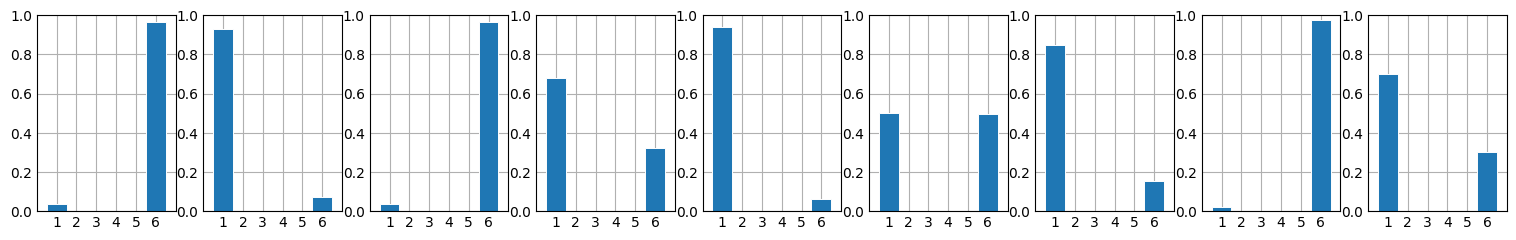

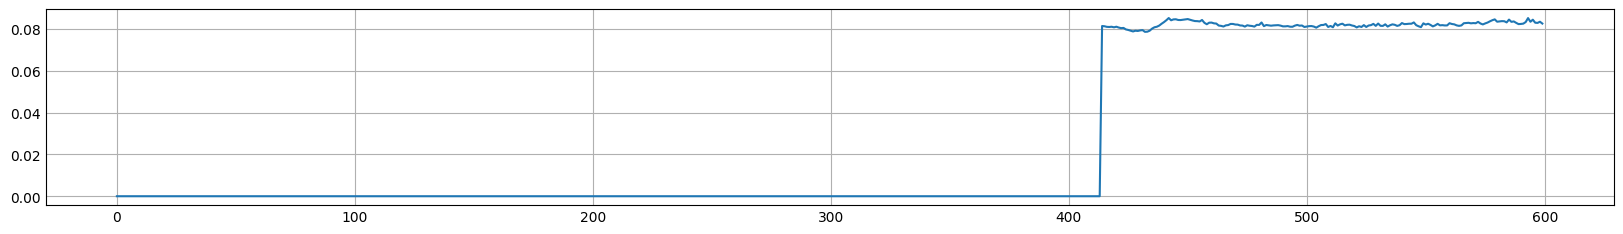

158 313
file: ../data/json/healthy/158_313_01.json pred: [0] real: 0 confusion: [0.25236392]
file: ../data/json/healthy/158_313_02.json pred: [1] real: 0 confusion: [0.00257331]
file: ../data/json/healthy/158_313_03.json pred: [1] real: 0 confusion: [0.07959735]
file: ../data/json/healthy/158_313_04.json pred: [1] real: 0 confusion: [0.00765085]
file: ../data/json/healthy/158_313_05.json pred: [1] real: 0 confusion: [0.0156737]
file: ../data/json/healthy/158_313_06.json pred: [1] real: 0 confusion: [0.2685762]
file: ../data/json/healthy/158_313_07.json pred: [1] real: 0 confusion: [0.00097281]
file: ../data/json/healthy/158_313_08.json pred: [1] real: 0 confusion: [0.00260103]
file: ../data/json/healthy/158_313_09.json pred: [5] real: 0 confusion: [0.02222264]


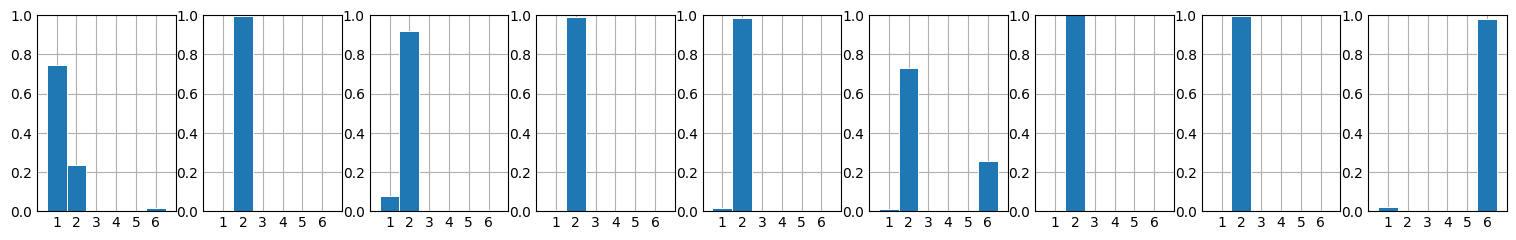

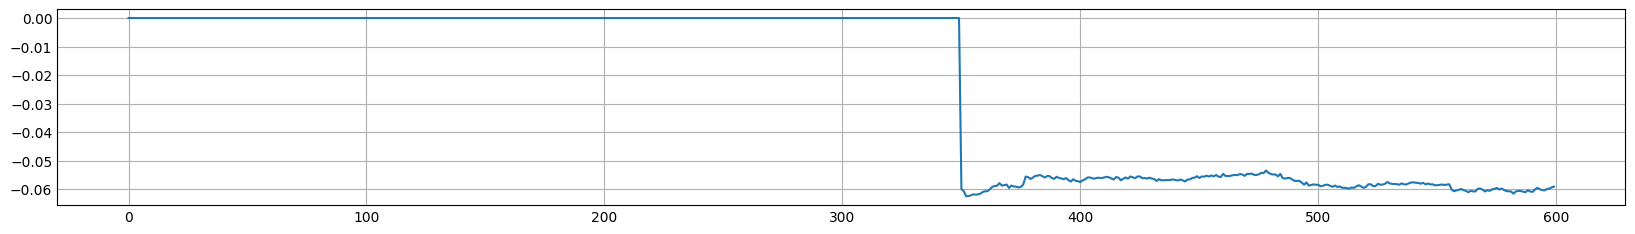

159 314
file: ../data/json/healthy/159_314_01.json pred: [3] real: 0 confusion: [0.05396485]
file: ../data/json/healthy/159_314_02.json pred: [3] real: 0 confusion: [0.26313728]
file: ../data/json/healthy/159_314_03.json pred: [3] real: 0 confusion: [0.01004082]
file: ../data/json/healthy/159_314_04.json pred: [3] real: 0 confusion: [0.34176433]
file: ../data/json/healthy/159_314_05.json pred: [0] real: 0 confusion: [0.09449708]
file: ../data/json/healthy/159_314_06.json pred: [0] real: 0 confusion: [0.11942291]
file: ../data/json/healthy/159_314_07.json pred: [0] real: 0 confusion: [0.31926948]
file: ../data/json/healthy/159_314_08.json pred: [3] real: 0 confusion: [0.00028682]
file: ../data/json/healthy/159_314_09.json pred: [0] real: 0 confusion: [0.11165029]


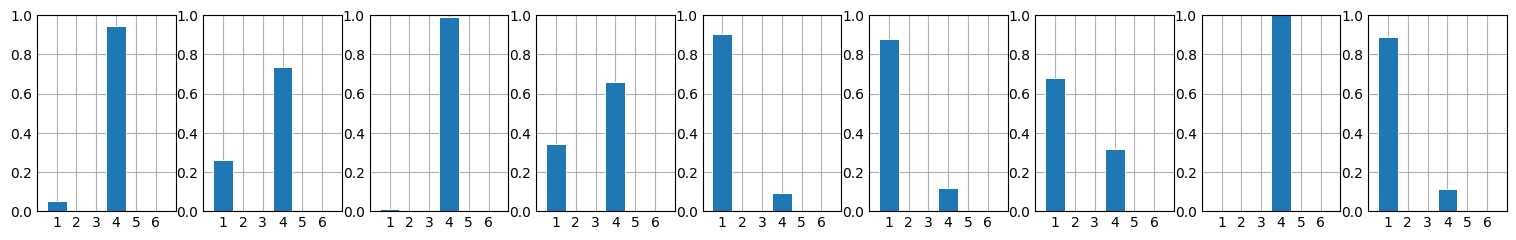

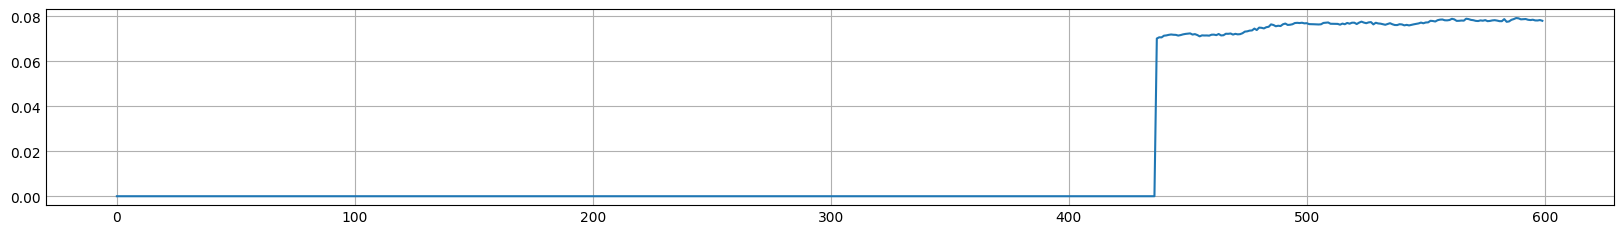

160 316
file: ../data/json/healthy/160_316_01.json pred: [0] real: 0 confusion: [0.26057482]
file: ../data/json/healthy/160_316_02.json pred: [0] real: 0 confusion: [0.2612654]
file: ../data/json/healthy/160_316_03.json pred: [0] real: 0 confusion: [5.6624413e-06]
file: ../data/json/healthy/160_316_04.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/160_316_05.json pred: [0] real: 0 confusion: [2.4914742e-05]
file: ../data/json/healthy/160_316_06.json pred: [0] real: 0 confusion: [0.05659616]
file: ../data/json/healthy/160_316_07.json pred: [0] real: 0 confusion: [0.00865328]
file: ../data/json/healthy/160_316_08.json pred: [0] real: 0 confusion: [0.03781277]
file: ../data/json/healthy/160_316_09.json pred: [1] real: 0 confusion: [0.06814283]


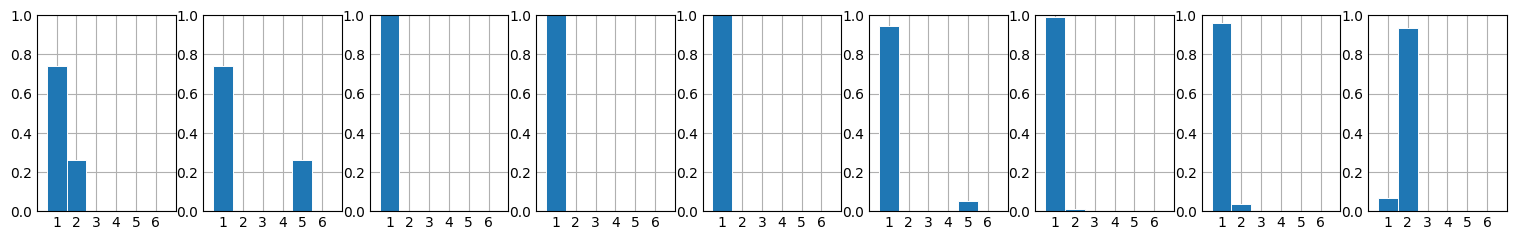

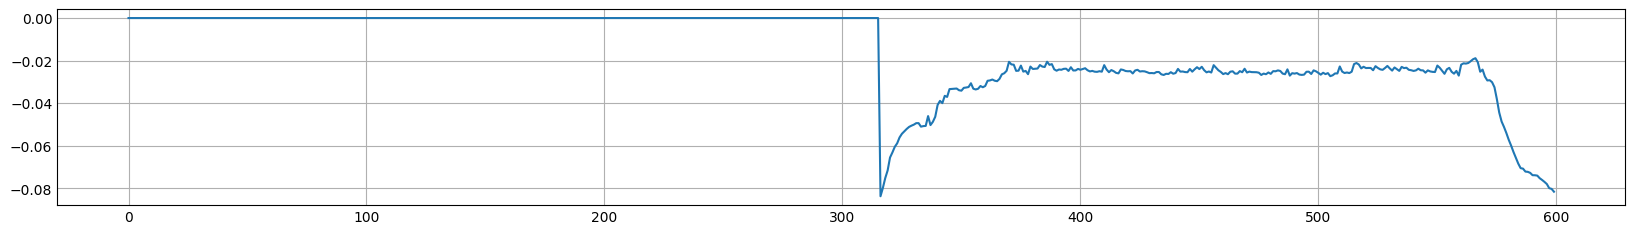

160 315
file: ../data/json/healthy/160_315_01.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/160_315_02.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/160_315_03.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/160_315_04.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/160_315_05.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/160_315_06.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/160_315_07.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/160_315_08.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/160_315_09.json pred: [0] real: 0 confusion: [0.]


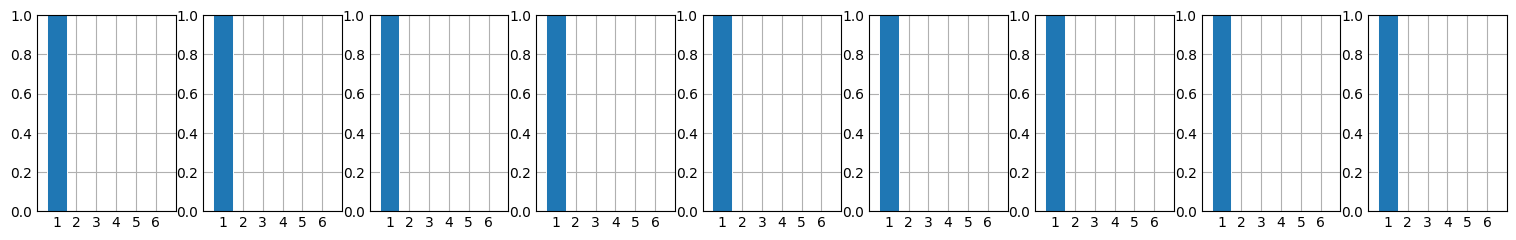

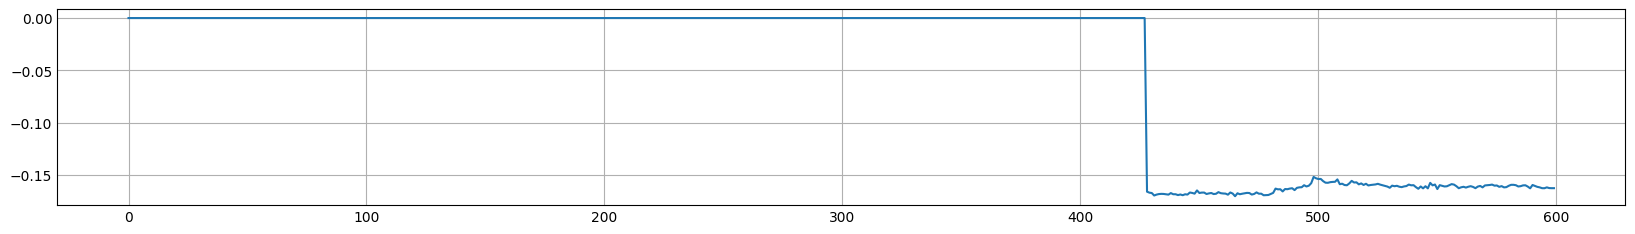

166 322
file: ../data/json/healthy/166_322_01.json pred: [0] real: 0 confusion: [0.00196856]
file: ../data/json/healthy/166_322_02.json pred: [0] real: 0 confusion: [0.00055099]
file: ../data/json/healthy/166_322_03.json pred: [0] real: 0 confusion: [0.0003348]
file: ../data/json/healthy/166_322_04.json pred: [0] real: 0 confusion: [3.5226345e-05]
file: ../data/json/healthy/166_322_05.json pred: [0] real: 0 confusion: [0.00024778]
file: ../data/json/healthy/166_322_06.json pred: [0] real: 0 confusion: [0.00124091]
file: ../data/json/healthy/166_322_07.json pred: [0] real: 0 confusion: [0.0059157]
file: ../data/json/healthy/166_322_08.json pred: [0] real: 0 confusion: [0.00029218]
file: ../data/json/healthy/166_322_09.json pred: [2] real: 0 confusion: [0.3559916]


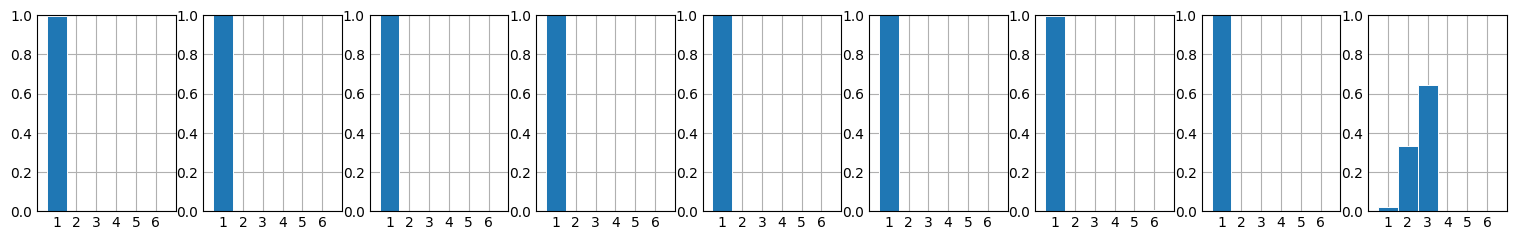

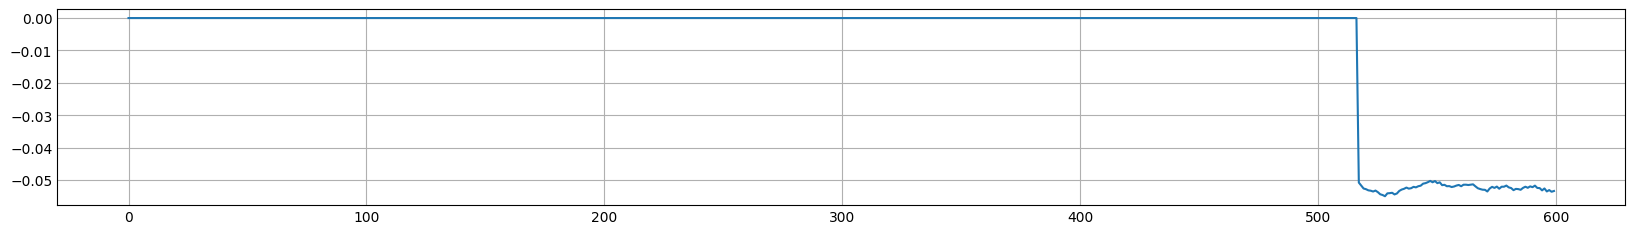

167 323
file: ../data/json/healthy/167_323_01.json pred: [0] real: 0 confusion: [4.8995018e-05]
file: ../data/json/healthy/167_323_02.json pred: [0] real: 0 confusion: [4.1127205e-06]
file: ../data/json/healthy/167_323_03.json pred: [0] real: 0 confusion: [2.515316e-05]
file: ../data/json/healthy/167_323_04.json pred: [0] real: 0 confusion: [9.596348e-06]
file: ../data/json/healthy/167_323_05.json pred: [0] real: 0 confusion: [1.8715858e-05]
file: ../data/json/healthy/167_323_06.json pred: [0] real: 0 confusion: [0.00012362]
file: ../data/json/healthy/167_323_07.json pred: [0] real: 0 confusion: [0.1440993]
file: ../data/json/healthy/167_323_08.json pred: [0] real: 0 confusion: [0.00016725]
file: ../data/json/healthy/167_323_09.json pred: [0] real: 0 confusion: [1.0848045e-05]


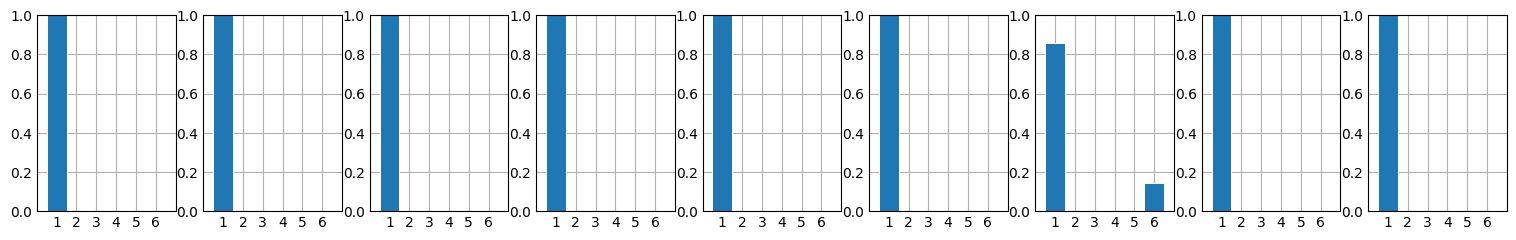

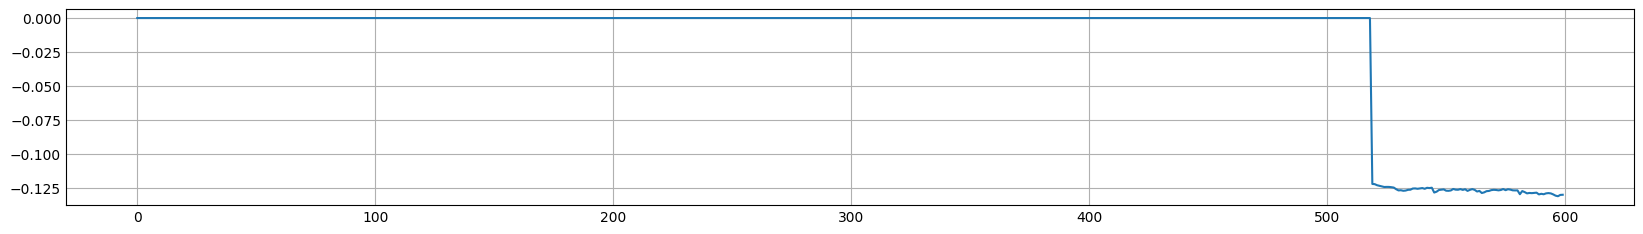

168 324
File ../data/json/healthy/168_324_01.json is missing
File ../data/json/healthy/168_324_02.json is missing
File ../data/json/healthy/168_324_03.json is missing
File ../data/json/healthy/168_324_04.json is missing
File ../data/json/healthy/168_324_05.json is missing
file: ../data/json/healthy/168_324_06.json pred: [0] real: 0 confusion: [0.]
File ../data/json/healthy/168_324_07.json is missing
File ../data/json/healthy/168_324_08.json is missing
File ../data/json/healthy/168_324_09.json is missing


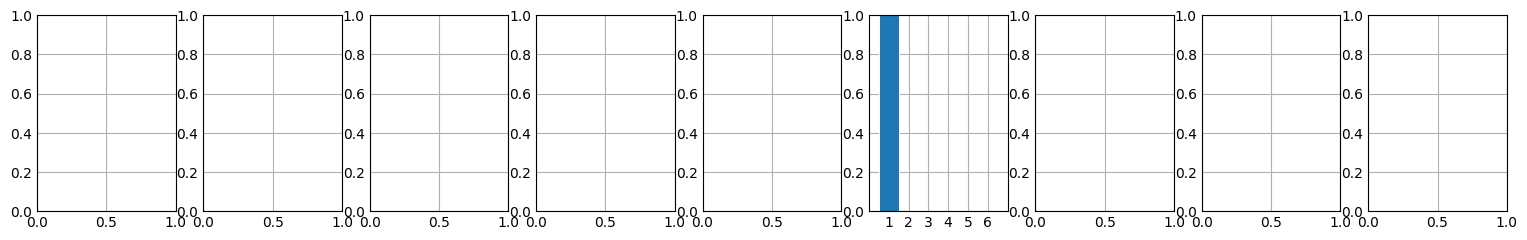

169 325
file: ../data/json/healthy/169_325_01.json pred: [1] real: 0 confusion: [0.0359717]
file: ../data/json/healthy/169_325_02.json pred: [1] real: 0 confusion: [0.00546485]
file: ../data/json/healthy/169_325_03.json pred: [1] real: 0 confusion: [0.00043428]
file: ../data/json/healthy/169_325_04.json pred: [4] real: 0 confusion: [0.00065821]
file: ../data/json/healthy/169_325_05.json pred: [4] real: 0 confusion: [0.0037083]
file: ../data/json/healthy/169_325_06.json pred: [3] real: 0 confusion: [0.3905493]
file: ../data/json/healthy/169_325_07.json pred: [0] real: 0 confusion: [0.2264443]
file: ../data/json/healthy/169_325_08.json pred: [0] real: 0 confusion: [0.0746572]
file: ../data/json/healthy/169_325_09.json pred: [3] real: 0 confusion: [0.00425851]


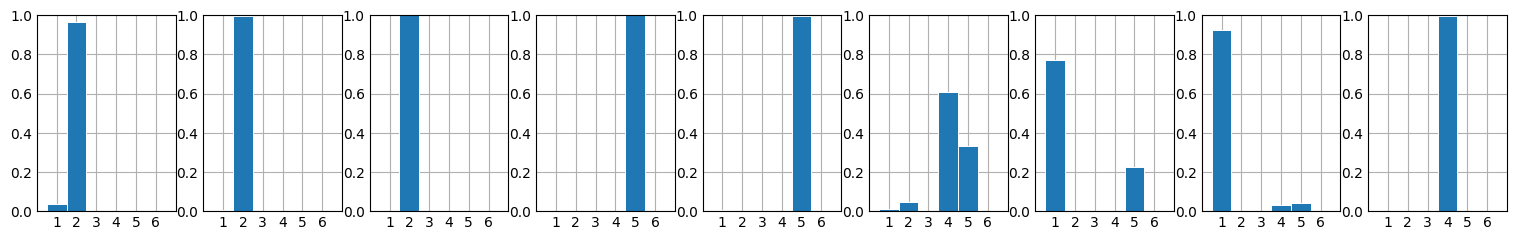

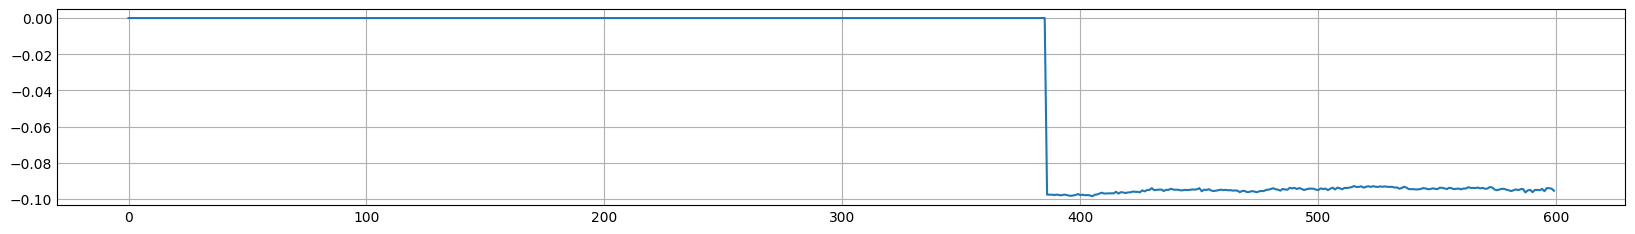

172 328
file: ../data/json/healthy/172_328_01.json pred: [0] real: 0 confusion: [0.00124502]
file: ../data/json/healthy/172_328_02.json pred: [0] real: 0 confusion: [0.2142151]
file: ../data/json/healthy/172_328_03.json pred: [0] real: 0 confusion: [0.01321787]
file: ../data/json/healthy/172_328_04.json pred: [0] real: 0 confusion: [0.14774907]
file: ../data/json/healthy/172_328_05.json pred: [3] real: 0 confusion: [0.44866914]
file: ../data/json/healthy/172_328_06.json pred: [0] real: 0 confusion: [0.00256693]
file: ../data/json/healthy/172_328_07.json pred: [0] real: 0 confusion: [0.01669323]
file: ../data/json/healthy/172_328_08.json pred: [0] real: 0 confusion: [0.00406361]
file: ../data/json/healthy/172_328_09.json pred: [0] real: 0 confusion: [0.43690974]


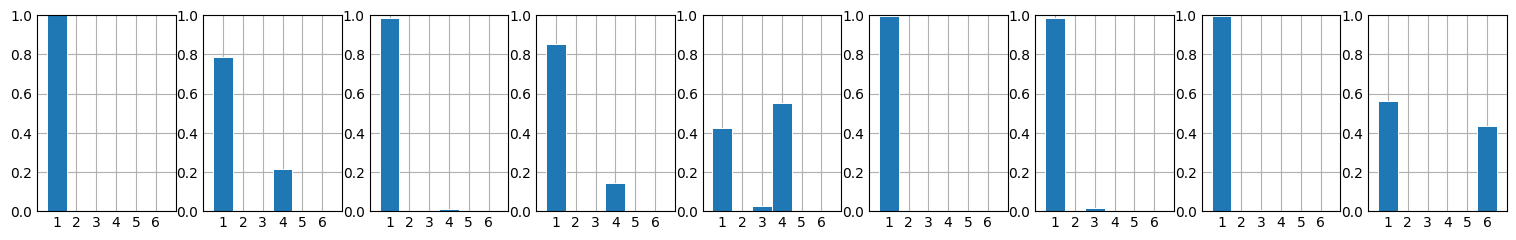

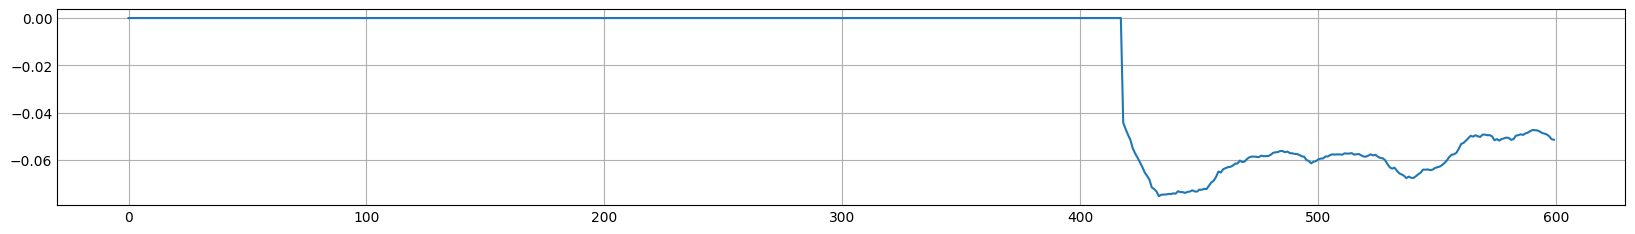

175 331
file: ../data/json/healthy/175_331_01.json pred: [0] real: 0 confusion: [0.03087592]
file: ../data/json/healthy/175_331_02.json pred: [0] real: 0 confusion: [0.00724232]
file: ../data/json/healthy/175_331_03.json pred: [0] real: 0 confusion: [0.37212372]
file: ../data/json/healthy/175_331_04.json pred: [0] real: 0 confusion: [0.01936108]
file: ../data/json/healthy/175_331_05.json pred: [1] real: 0 confusion: [0.0133341]
file: ../data/json/healthy/175_331_06.json pred: [3] real: 0 confusion: [0.2919144]
file: ../data/json/healthy/175_331_07.json pred: [3] real: 0 confusion: [0.03302664]
file: ../data/json/healthy/175_331_08.json pred: [1] real: 0 confusion: [0.49553818]
file: ../data/json/healthy/175_331_09.json pred: [0] real: 0 confusion: [0.14393365]


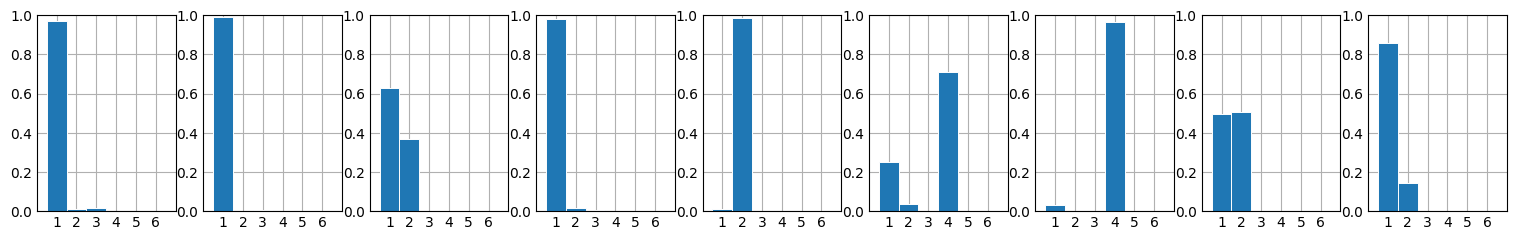

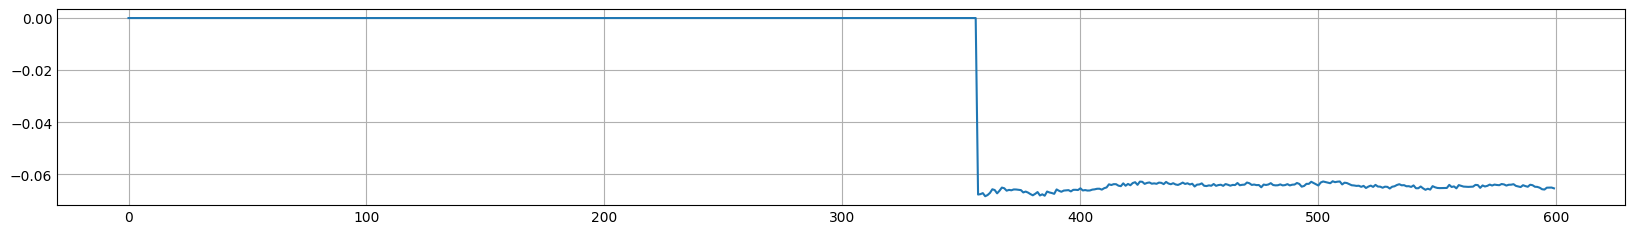

176 333
file: ../data/json/healthy/176_333_01.json pred: [0] real: 0 confusion: [4.7683716e-06]
file: ../data/json/healthy/176_333_02.json pred: [0] real: 0 confusion: [0.03180277]
file: ../data/json/healthy/176_333_03.json pred: [0] real: 0 confusion: [0.22642612]
file: ../data/json/healthy/176_333_04.json pred: [0] real: 0 confusion: [0.00399595]
file: ../data/json/healthy/176_333_05.json pred: [0] real: 0 confusion: [0.08296466]
file: ../data/json/healthy/176_333_06.json pred: [5] real: 0 confusion: [0.15381813]
file: ../data/json/healthy/176_333_07.json pred: [0] real: 0 confusion: [0.10553348]
file: ../data/json/healthy/176_333_08.json pred: [0] real: 0 confusion: [0.02069616]
file: ../data/json/healthy/176_333_09.json pred: [0] real: 0 confusion: [0.0286867]


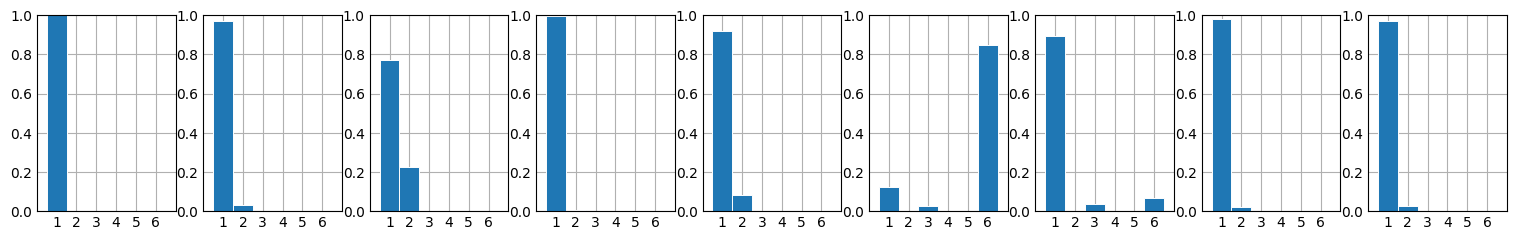

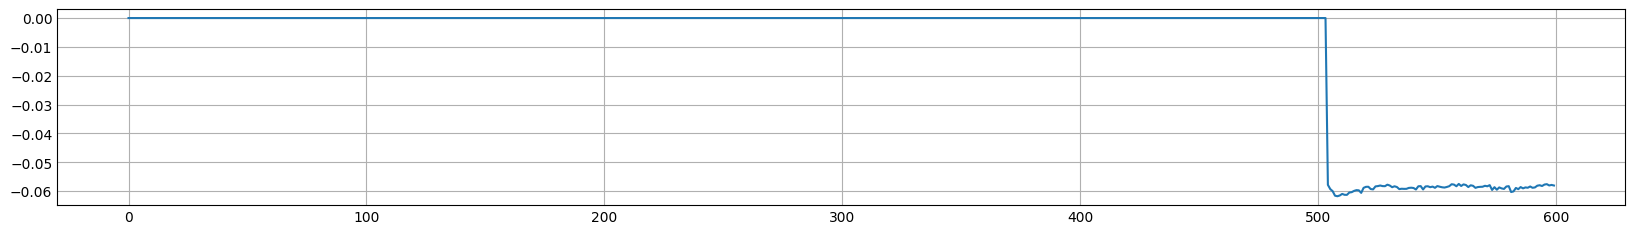

177 334
file: ../data/json/healthy/177_334_01.json pred: [0] real: 0 confusion: [0.06774145]
file: ../data/json/healthy/177_334_02.json pred: [0] real: 0 confusion: [0.23360306]
file: ../data/json/healthy/177_334_03.json pred: [0] real: 0 confusion: [0.00977671]
file: ../data/json/healthy/177_334_04.json pred: [0] real: 0 confusion: [0.00059676]
file: ../data/json/healthy/177_334_05.json pred: [0] real: 0 confusion: [0.01850969]
file: ../data/json/healthy/177_334_06.json pred: [0] real: 0 confusion: [0.01043934]
file: ../data/json/healthy/177_334_07.json pred: [0] real: 0 confusion: [0.04862124]
file: ../data/json/healthy/177_334_08.json pred: [0] real: 0 confusion: [0.04359472]
file: ../data/json/healthy/177_334_09.json pred: [0] real: 0 confusion: [0.01998234]


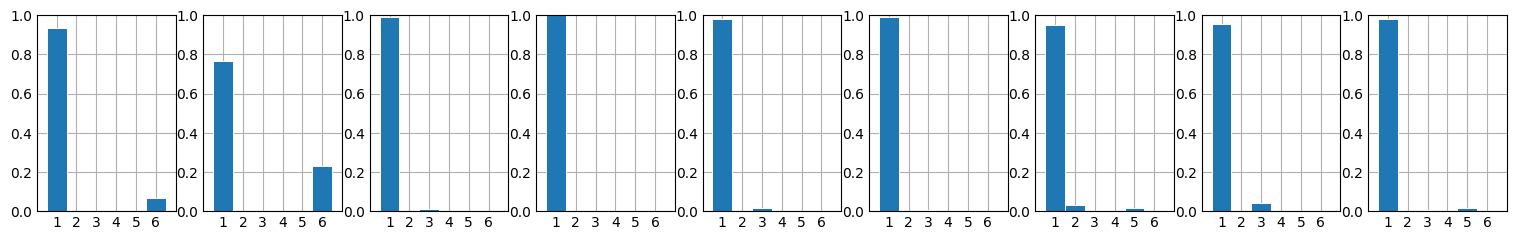

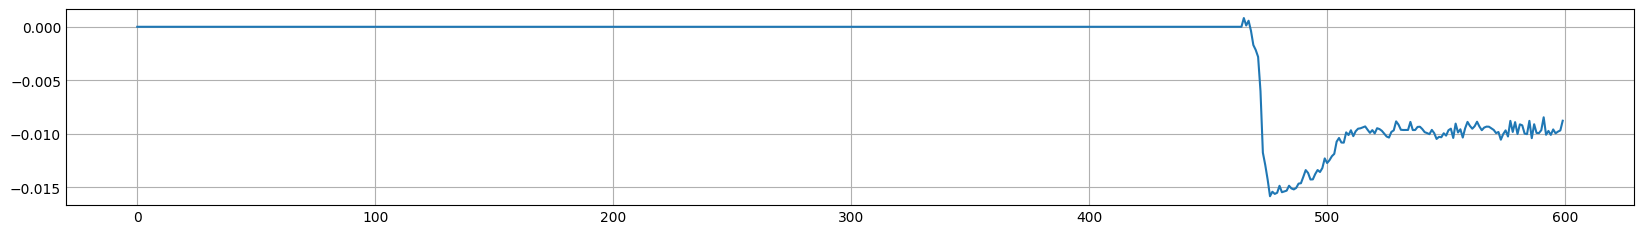

178 335
file: ../data/json/healthy/178_335_01.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/178_335_02.json pred: [0] real: 0 confusion: [0.00307924]
file: ../data/json/healthy/178_335_03.json pred: [0] real: 0 confusion: [0.00149226]
file: ../data/json/healthy/178_335_04.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/178_335_05.json pred: [0] real: 0 confusion: [1.1920929e-07]
file: ../data/json/healthy/178_335_06.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/178_335_07.json pred: [0] real: 0 confusion: [4.7683716e-07]
file: ../data/json/healthy/178_335_08.json pred: [0] real: 0 confusion: [7.1525574e-07]
file: ../data/json/healthy/178_335_09.json pred: [0] real: 0 confusion: [4.172325e-06]


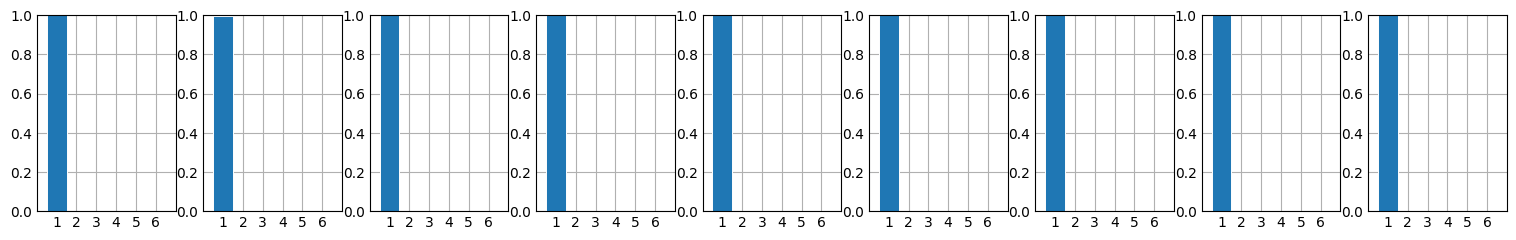

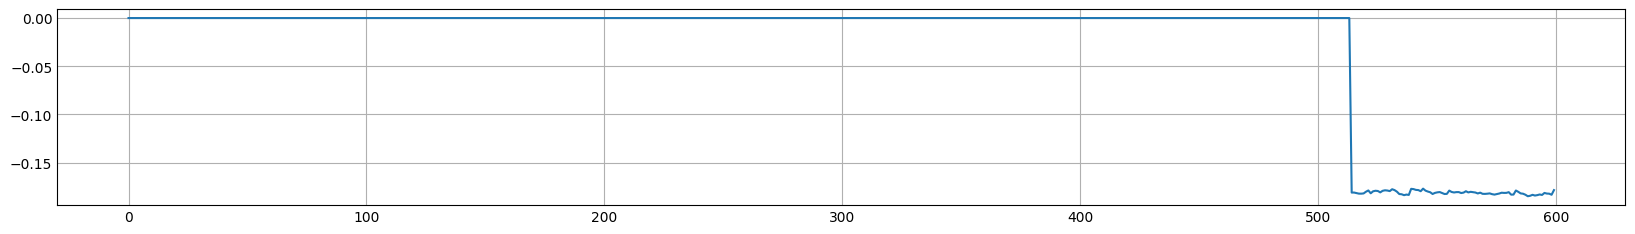

179 336
file: ../data/json/healthy/179_336_01.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/179_336_02.json pred: [0] real: 0 confusion: [5.9604645e-08]
file: ../data/json/healthy/179_336_03.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/179_336_04.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/179_336_05.json pred: [0] real: 0 confusion: [1.1920929e-07]
file: ../data/json/healthy/179_336_06.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/179_336_07.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/179_336_08.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/179_336_09.json pred: [0] real: 0 confusion: [8.34465e-07]


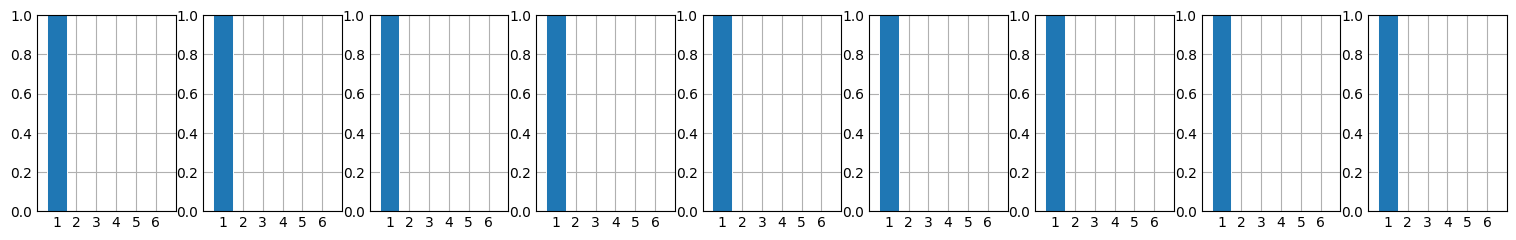

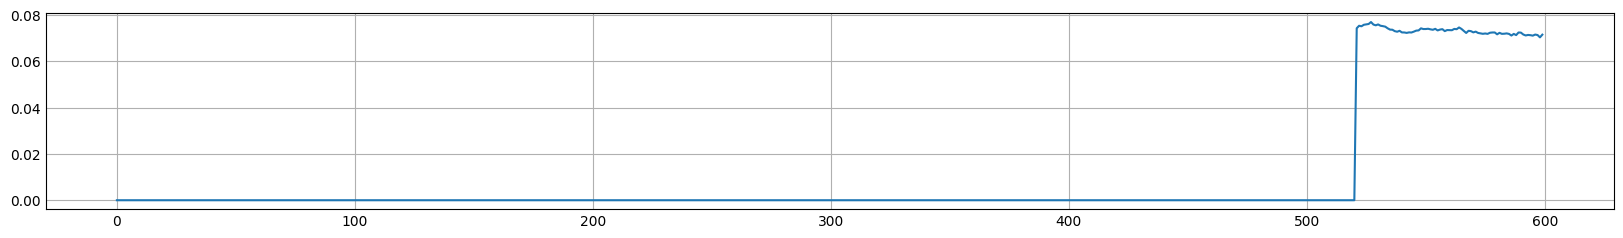

181 338
file: ../data/json/healthy/181_338_01.json pred: [0] real: 0 confusion: [0.03166205]
file: ../data/json/healthy/181_338_02.json pred: [0] real: 0 confusion: [0.00347418]
file: ../data/json/healthy/181_338_03.json pred: [0] real: 0 confusion: [0.01392335]
file: ../data/json/healthy/181_338_04.json pred: [0] real: 0 confusion: [0.04354268]
file: ../data/json/healthy/181_338_05.json pred: [0] real: 0 confusion: [0.02427506]
file: ../data/json/healthy/181_338_06.json pred: [0] real: 0 confusion: [0.00107944]
file: ../data/json/healthy/181_338_07.json pred: [0] real: 0 confusion: [0.00303346]
file: ../data/json/healthy/181_338_08.json pred: [0] real: 0 confusion: [0.00944901]
file: ../data/json/healthy/181_338_09.json pred: [0] real: 0 confusion: [0.00154811]


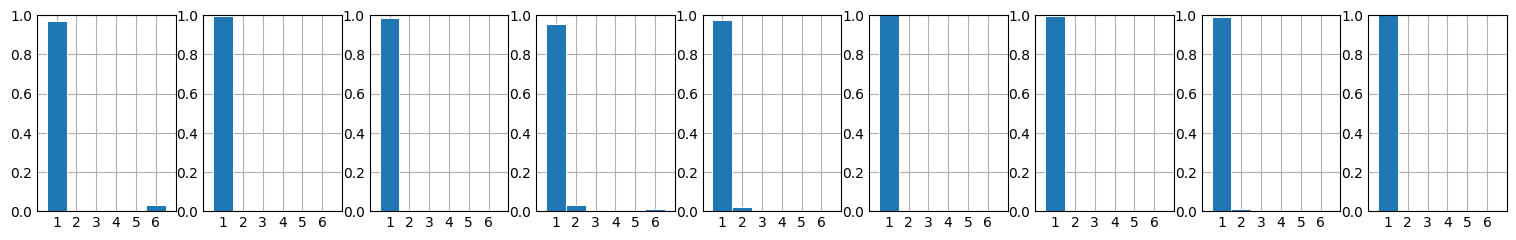

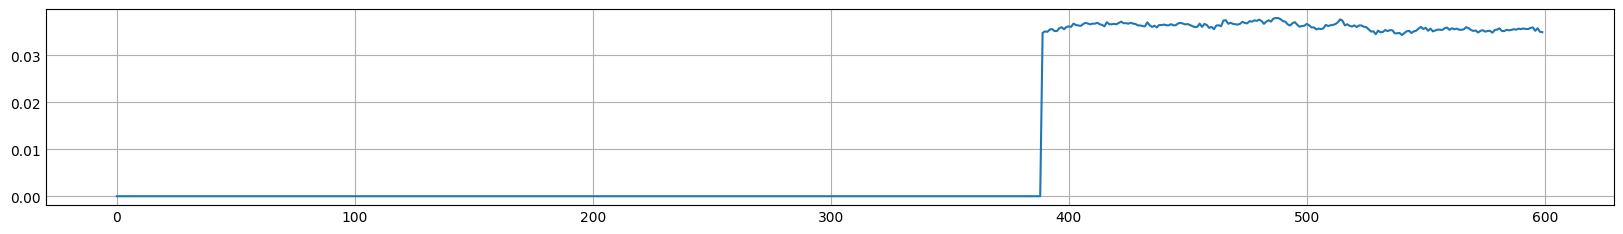

184 341
file: ../data/json/healthy/184_341_01.json pred: [0] real: 0 confusion: [0.09428561]
file: ../data/json/healthy/184_341_02.json pred: [1] real: 0 confusion: [0.02156806]
file: ../data/json/healthy/184_341_03.json pred: [0] real: 0 confusion: [0.00693631]
file: ../data/json/healthy/184_341_04.json pred: [0] real: 0 confusion: [4.2915344e-06]
file: ../data/json/healthy/184_341_05.json pred: [0] real: 0 confusion: [0.00013286]
file: ../data/json/healthy/184_341_06.json pred: [0] real: 0 confusion: [3.7550926e-05]
file: ../data/json/healthy/184_341_07.json pred: [0] real: 0 confusion: [1.7881393e-07]
file: ../data/json/healthy/184_341_08.json pred: [0] real: 0 confusion: [1.2397766e-05]
file: ../data/json/healthy/184_341_09.json pred: [0] real: 0 confusion: [2.3841858e-06]


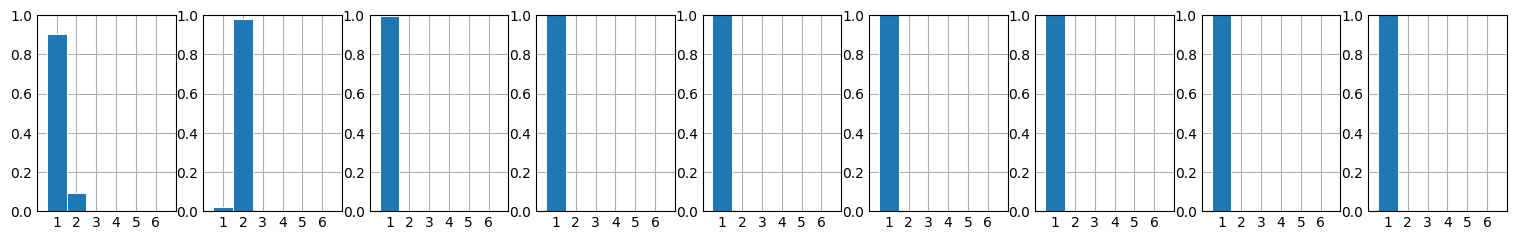

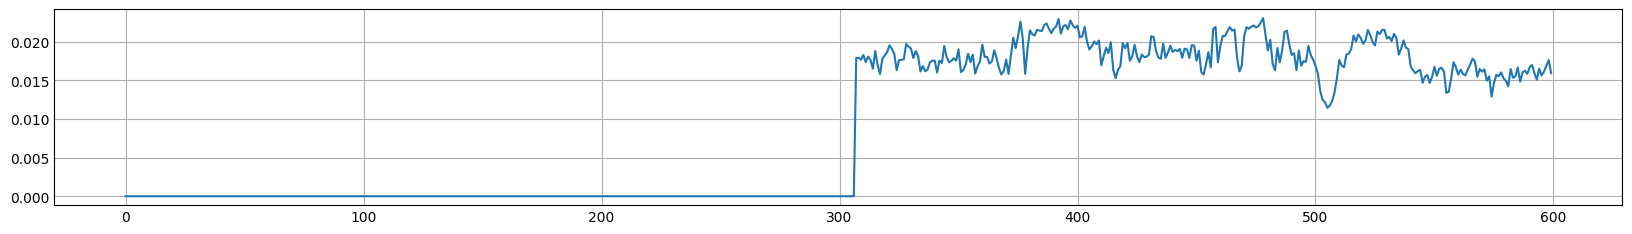

185 342
file: ../data/json/healthy/185_342_01.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/185_342_02.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/185_342_03.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/185_342_04.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/185_342_05.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/185_342_06.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/185_342_07.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/185_342_08.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/185_342_09.json pred: [0] real: 0 confusion: [0.]


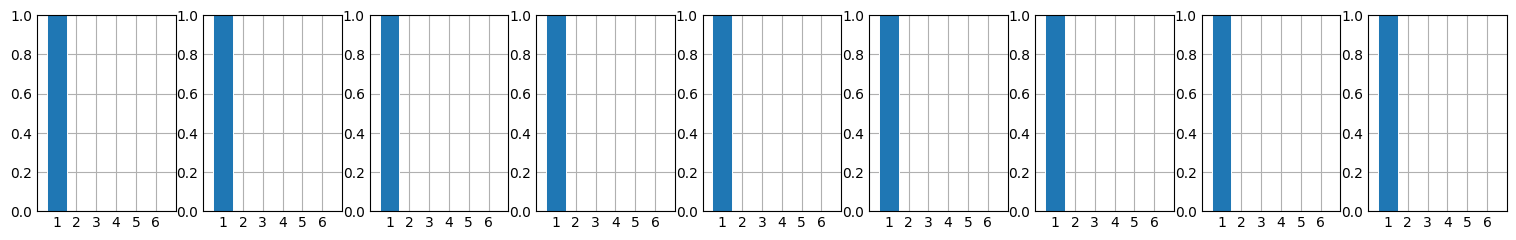

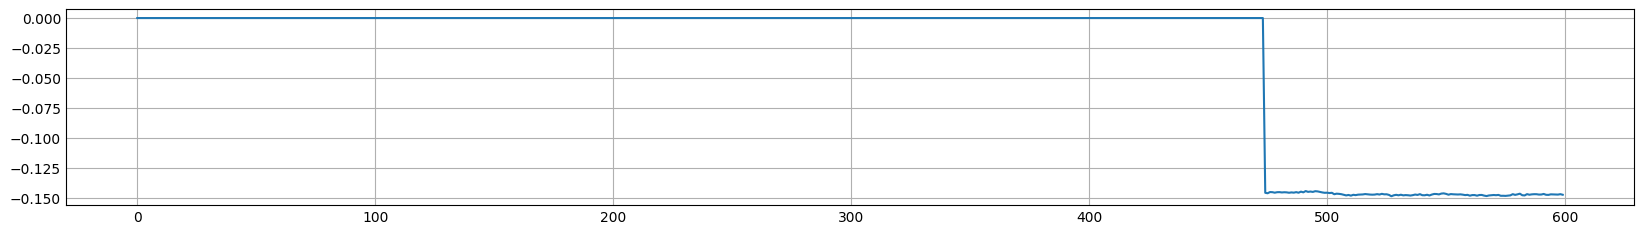

186 343
file: ../data/json/healthy/186_343_01.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/186_343_02.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/186_343_03.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/186_343_04.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/186_343_05.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/186_343_06.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/186_343_07.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/186_343_08.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/186_343_09.json pred: [0] real: 0 confusion: [0.]


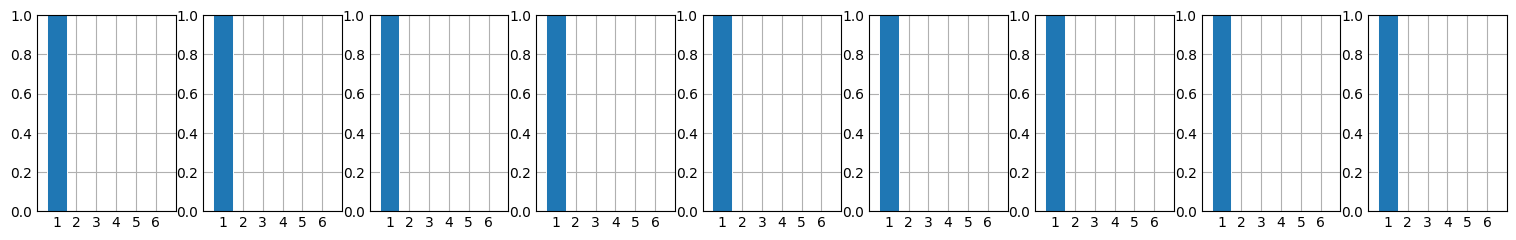

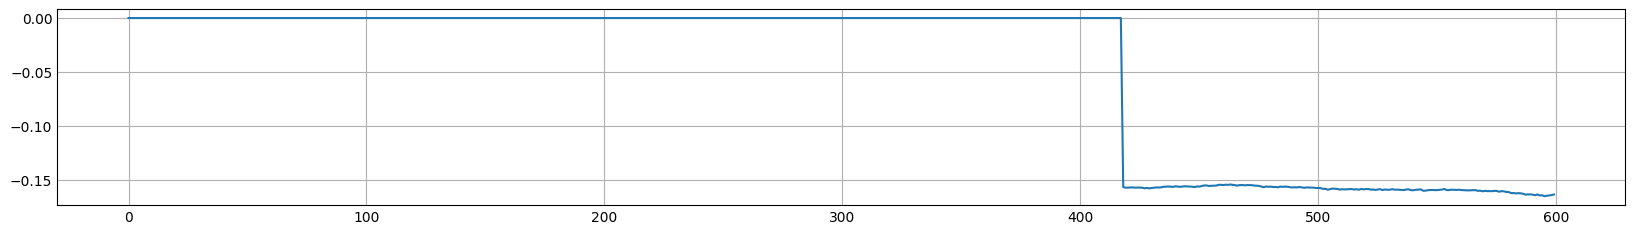

189 345
file: ../data/json/healthy/189_345_01.json pred: [1] real: 0 confusion: [2.3841858e-06]
file: ../data/json/healthy/189_345_02.json pred: [0] real: 0 confusion: [0.4048642]
file: ../data/json/healthy/189_345_03.json pred: [1] real: 0 confusion: [0.]
file: ../data/json/healthy/189_345_04.json pred: [0] real: 0 confusion: [4.7683716e-05]
file: ../data/json/healthy/189_345_05.json pred: [0] real: 0 confusion: [1.4305115e-06]
file: ../data/json/healthy/189_345_06.json pred: [0] real: 0 confusion: [2.1457672e-06]
file: ../data/json/healthy/189_345_07.json pred: [1] real: 0 confusion: [0.00275469]
file: ../data/json/healthy/189_345_08.json pred: [0] real: 0 confusion: [0.32387924]
file: ../data/json/healthy/189_345_09.json pred: [0] real: 0 confusion: [0.01610684]


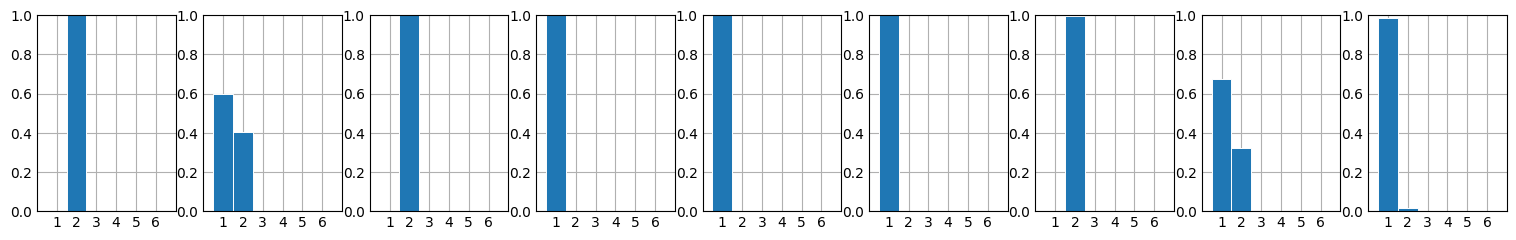

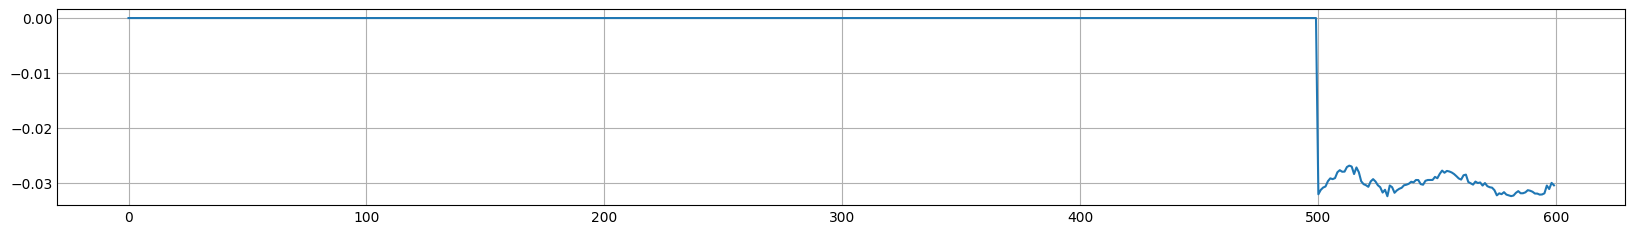

190 346
file: ../data/json/healthy/190_346_01.json pred: [0] real: 0 confusion: [6.03199e-05]
file: ../data/json/healthy/190_346_02.json pred: [0] real: 0 confusion: [4.595518e-05]
file: ../data/json/healthy/190_346_03.json pred: [0] real: 0 confusion: [2.1100044e-05]
file: ../data/json/healthy/190_346_04.json pred: [0] real: 0 confusion: [5.00679e-06]
file: ../data/json/healthy/190_346_05.json pred: [0] real: 0 confusion: [4.440546e-05]
file: ../data/json/healthy/190_346_06.json pred: [0] real: 0 confusion: [0.00010788]
file: ../data/json/healthy/190_346_07.json pred: [0] real: 0 confusion: [0.0030489]
file: ../data/json/healthy/190_346_08.json pred: [0] real: 0 confusion: [0.0001334]
file: ../data/json/healthy/190_346_09.json pred: [2] real: 0 confusion: [0.57021105]


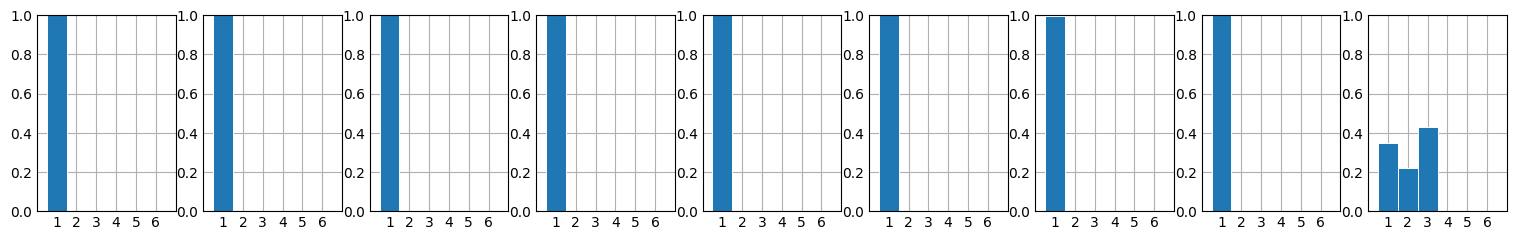

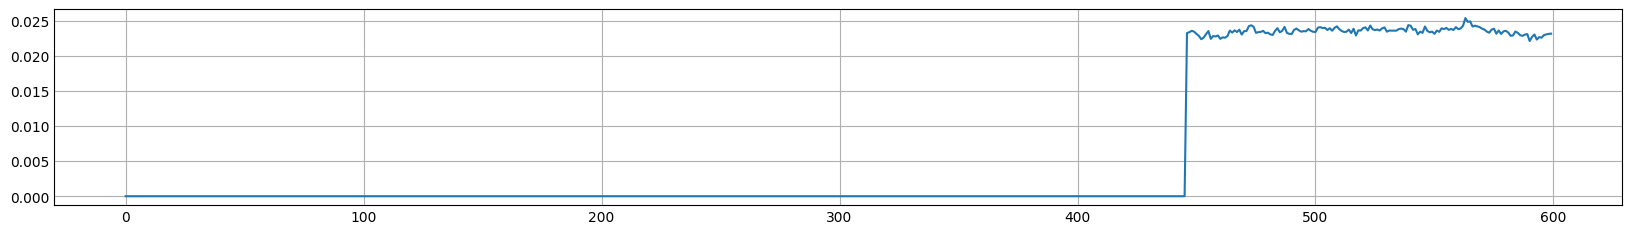

191 349
File ../data/json/healthy/191_349_01.json is missing
File ../data/json/healthy/191_349_02.json is missing
File ../data/json/healthy/191_349_03.json is missing
file: ../data/json/healthy/191_349_04.json pred: [0] real: 0 confusion: [0.00728977]
file: ../data/json/healthy/191_349_05.json pred: [0] real: 0 confusion: [2.2411346e-05]
file: ../data/json/healthy/191_349_06.json pred: [0] real: 0 confusion: [0.00020057]
file: ../data/json/healthy/191_349_07.json pred: [0] real: 0 confusion: [1.1205673e-05]
file: ../data/json/healthy/191_349_08.json pred: [0] real: 0 confusion: [0.00045311]
file: ../data/json/healthy/191_349_09.json pred: [0] real: 0 confusion: [0.2946077]


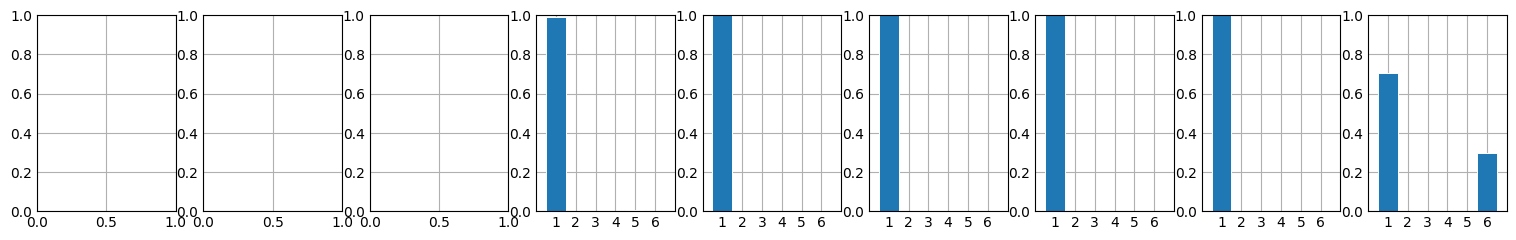

192 350
file: ../data/json/healthy/192_350_01.json pred: [0] real: 0 confusion: [5.6624413e-06]
file: ../data/json/healthy/192_350_02.json pred: [0] real: 0 confusion: [3.0398369e-06]
file: ../data/json/healthy/192_350_03.json pred: [0] real: 0 confusion: [1.1920929e-07]
file: ../data/json/healthy/192_350_04.json pred: [0] real: 0 confusion: [2.0384789e-05]
file: ../data/json/healthy/192_350_05.json pred: [0] real: 0 confusion: [4.4107437e-06]
file: ../data/json/healthy/192_350_06.json pred: [0] real: 0 confusion: [4.2915344e-06]
file: ../data/json/healthy/192_350_07.json pred: [0] real: 0 confusion: [1.1920929e-06]
file: ../data/json/healthy/192_350_08.json pred: [0] real: 0 confusion: [1.2516975e-06]
file: ../data/json/healthy/192_350_09.json pred: [0] real: 0 confusion: [0.03580672]


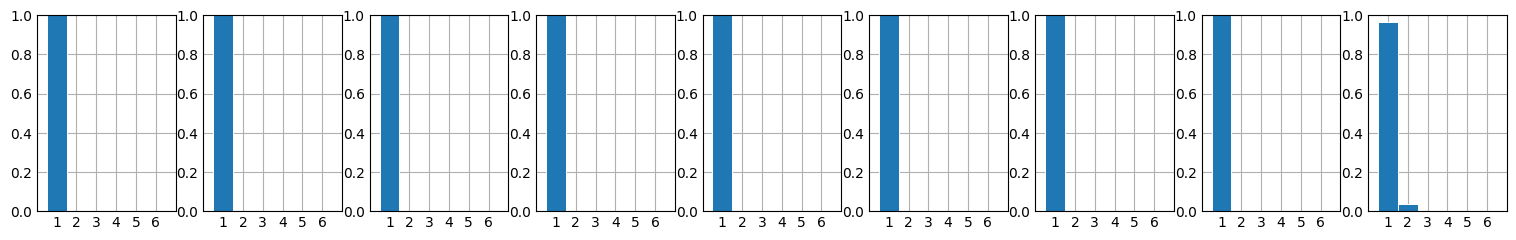

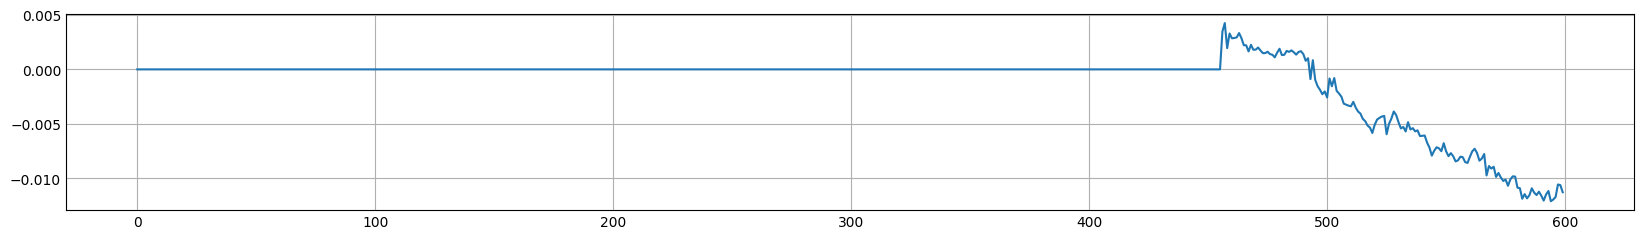

193 351
file: ../data/json/healthy/193_351_01.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/193_351_02.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/193_351_03.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/193_351_04.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/193_351_05.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/193_351_06.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/193_351_07.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/193_351_08.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/193_351_09.json pred: [0] real: 0 confusion: [0.]


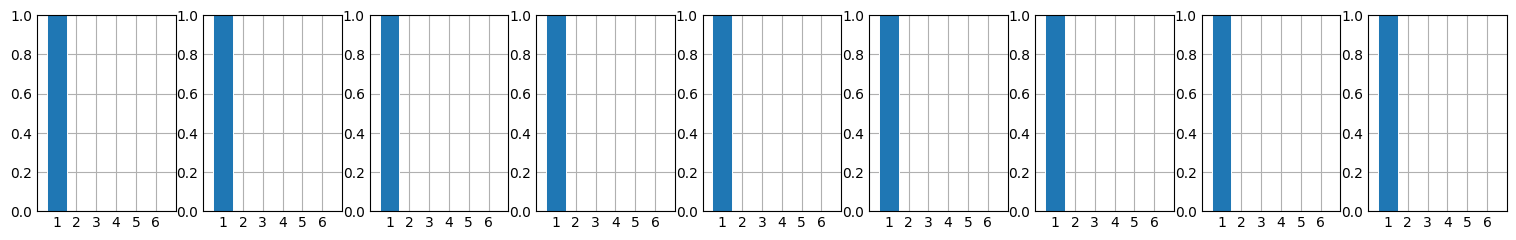

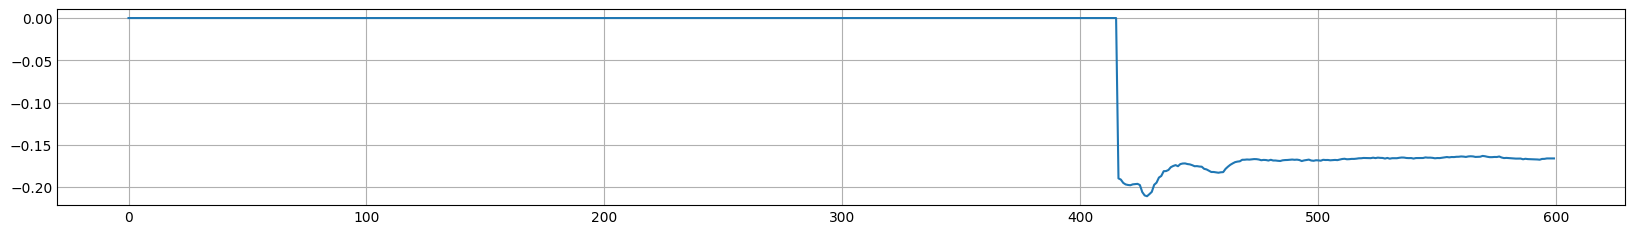

196 354
file: ../data/json/healthy/196_354_01.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/196_354_02.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/196_354_03.json pred: [0] real: 0 confusion: [9.894371e-06]
file: ../data/json/healthy/196_354_04.json pred: [0] real: 0 confusion: [8.34465e-07]
file: ../data/json/healthy/196_354_05.json pred: [1] real: 0 confusion: [0.00935495]
file: ../data/json/healthy/196_354_06.json pred: [0] real: 0 confusion: [8.106232e-06]
file: ../data/json/healthy/196_354_07.json pred: [3] real: 0 confusion: [0.3929689]
file: ../data/json/healthy/196_354_08.json pred: [0] real: 0 confusion: [4.172325e-07]
file: ../data/json/healthy/196_354_09.json pred: [0] real: 0 confusion: [0.46507746]


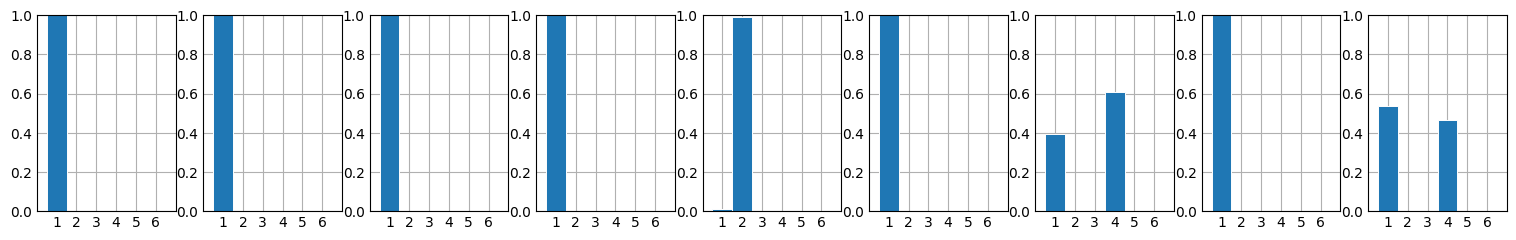

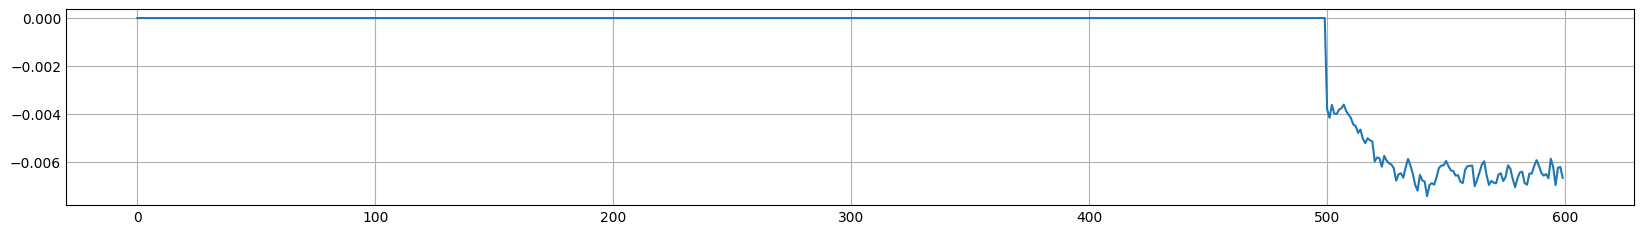

197 355
file: ../data/json/healthy/197_355_01.json pred: [5] real: 0 confusion: [0.1890381]
file: ../data/json/healthy/197_355_02.json pred: [5] real: 0 confusion: [0.39751112]
file: ../data/json/healthy/197_355_03.json pred: [5] real: 0 confusion: [0.3749016]
file: ../data/json/healthy/197_355_04.json pred: [0] real: 0 confusion: [0.00368273]
file: ../data/json/healthy/197_355_05.json pred: [0] real: 0 confusion: [0.19637293]
file: ../data/json/healthy/197_355_06.json pred: [0] real: 0 confusion: [0.22567546]
file: ../data/json/healthy/197_355_07.json pred: [0] real: 0 confusion: [0.41751868]
file: ../data/json/healthy/197_355_08.json pred: [0] real: 0 confusion: [0.00074685]
file: ../data/json/healthy/197_355_09.json pred: [5] real: 0 confusion: [0.34368652]


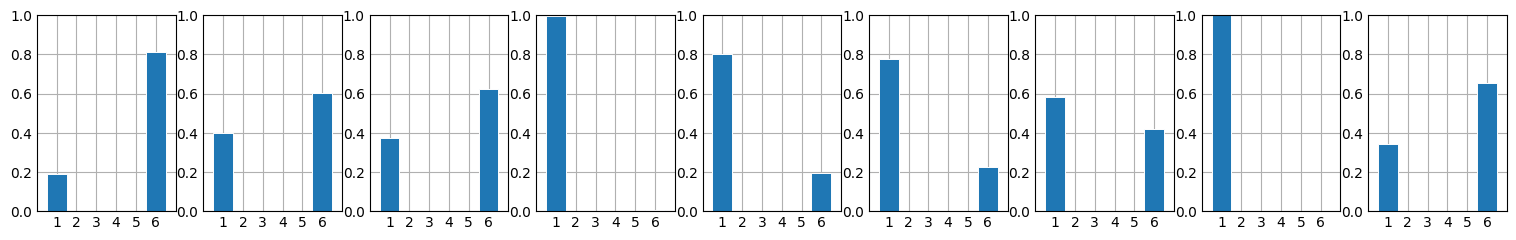

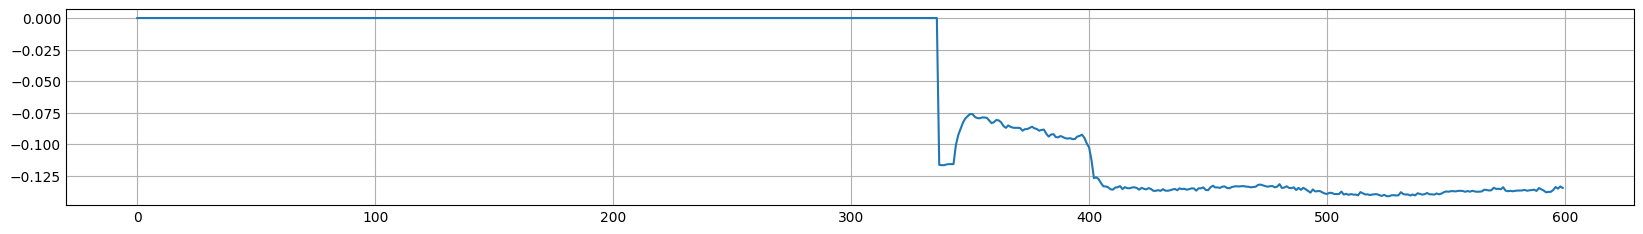

198 356
file: ../data/json/healthy/198_356_01.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/198_356_02.json pred: [0] real: 0 confusion: [6.377697e-06]
file: ../data/json/healthy/198_356_03.json pred: [0] real: 0 confusion: [0.03552794]
file: ../data/json/healthy/198_356_04.json pred: [0] real: 0 confusion: [1.001358e-05]
file: ../data/json/healthy/198_356_05.json pred: [0] real: 0 confusion: [2.104044e-05]
file: ../data/json/healthy/198_356_06.json pred: [0] real: 0 confusion: [1.513958e-05]
file: ../data/json/healthy/198_356_07.json pred: [0] real: 0 confusion: [0.45196158]
file: ../data/json/healthy/198_356_08.json pred: [0] real: 0 confusion: [0.01132894]
file: ../data/json/healthy/198_356_09.json pred: [0] real: 0 confusion: [0.00012964]


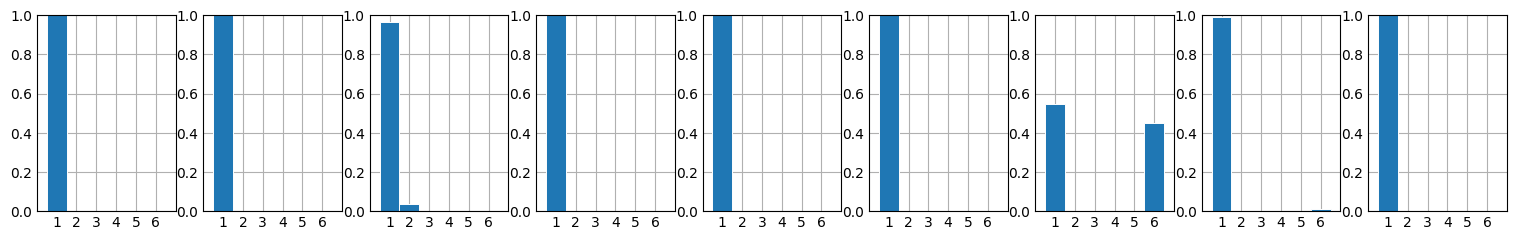

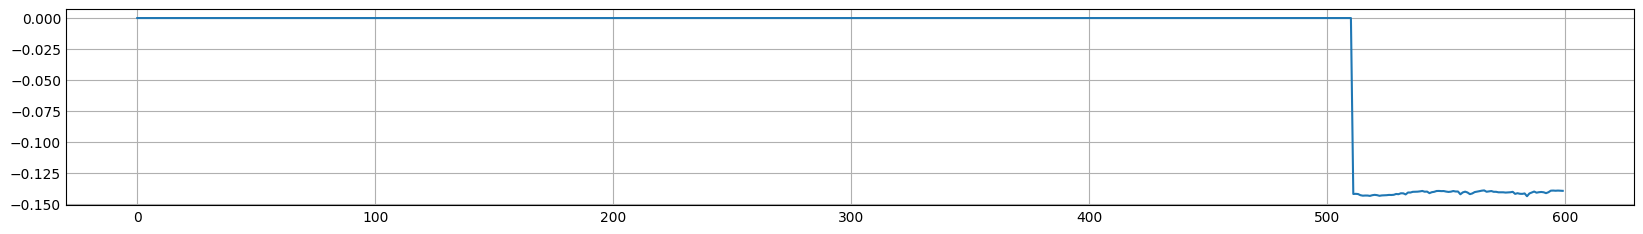

199 357
file: ../data/json/healthy/199_357_01.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/199_357_02.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/199_357_03.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/199_357_04.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/199_357_05.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/199_357_06.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/199_357_07.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/199_357_08.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/199_357_09.json pred: [0] real: 0 confusion: [0.]


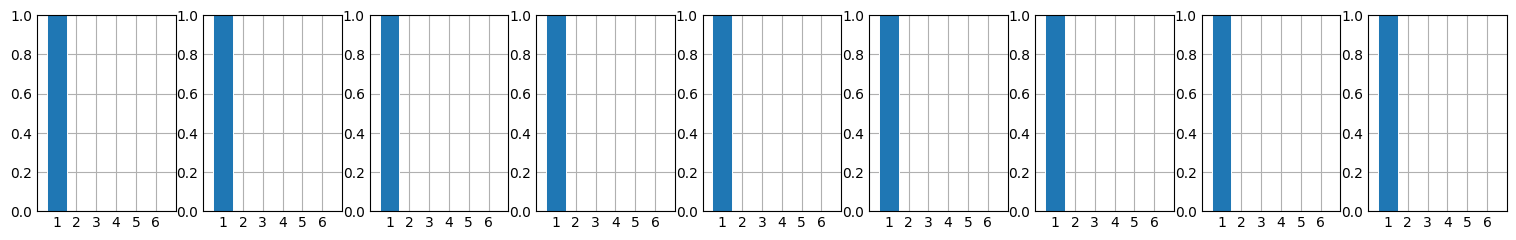

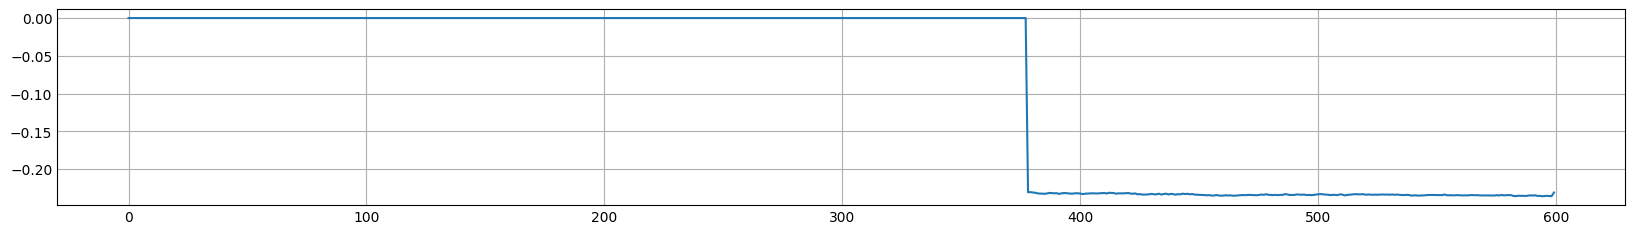

200 358
file: ../data/json/healthy/200_358_01.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/200_358_02.json pred: [0] real: 0 confusion: [5.1259995e-06]
file: ../data/json/healthy/200_358_03.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/200_358_04.json pred: [0] real: 0 confusion: [8.34465e-07]
file: ../data/json/healthy/200_358_05.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/200_358_06.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/200_358_07.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/200_358_08.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/200_358_09.json pred: [0] real: 0 confusion: [0.]


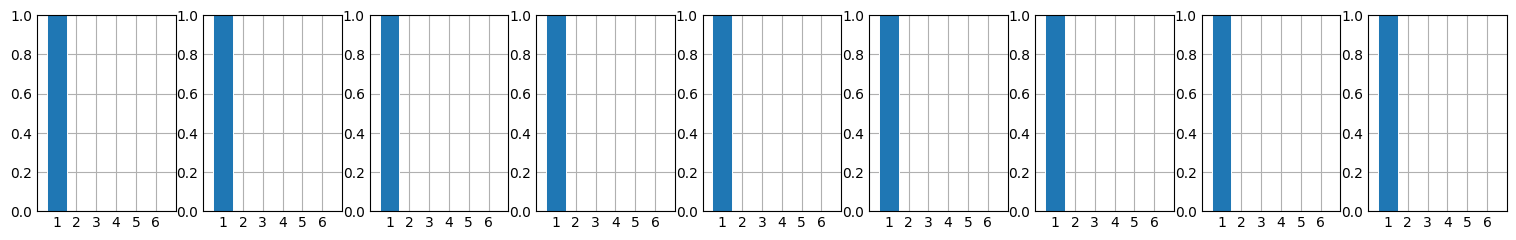

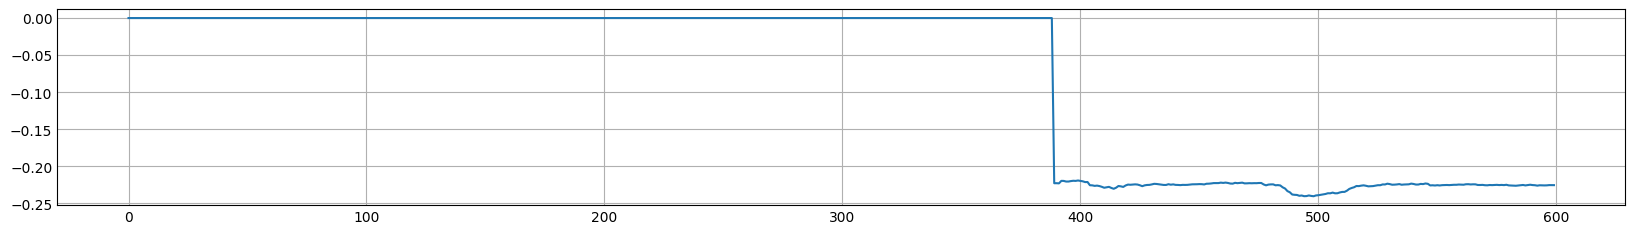

201 359
file: ../data/json/healthy/201_359_01.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/201_359_02.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/201_359_03.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/201_359_04.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/201_359_05.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/201_359_06.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/201_359_07.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/201_359_08.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/201_359_09.json pred: [0] real: 0 confusion: [0.]


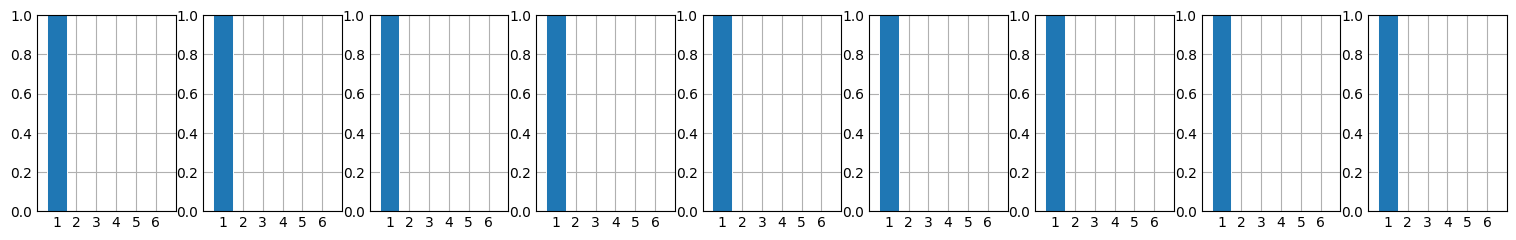

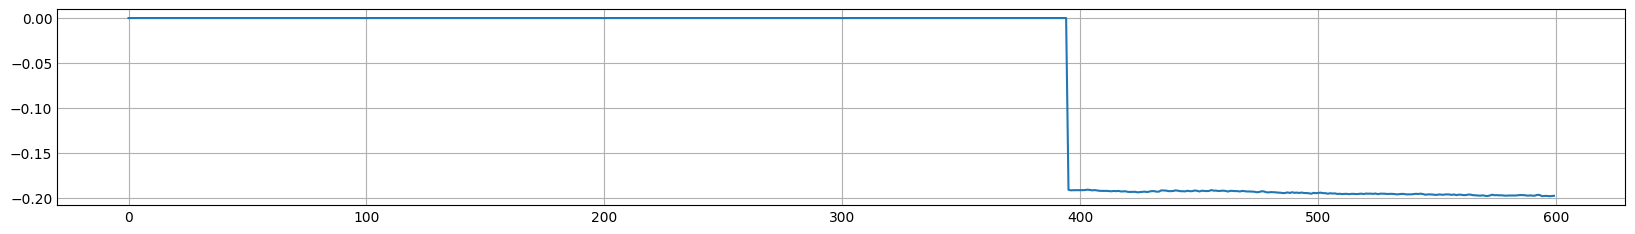

202 360
file: ../data/json/healthy/202_360_01.json pred: [5] real: 0 confusion: [0.03960121]
file: ../data/json/healthy/202_360_02.json pred: [5] real: 0 confusion: [0.3919171]
file: ../data/json/healthy/202_360_03.json pred: [0] real: 0 confusion: [0.17031956]
file: ../data/json/healthy/202_360_04.json pred: [5] real: 0 confusion: [0.3909698]
file: ../data/json/healthy/202_360_05.json pred: [5] real: 0 confusion: [0.4957949]
file: ../data/json/healthy/202_360_06.json pred: [5] real: 0 confusion: [0.00022382]
file: ../data/json/healthy/202_360_07.json pred: [5] real: 0 confusion: [9.417534e-06]
file: ../data/json/healthy/202_360_08.json pred: [2] real: 0 confusion: [0.10551828]
file: ../data/json/healthy/202_360_09.json pred: [0] real: 0 confusion: [0.01703924]


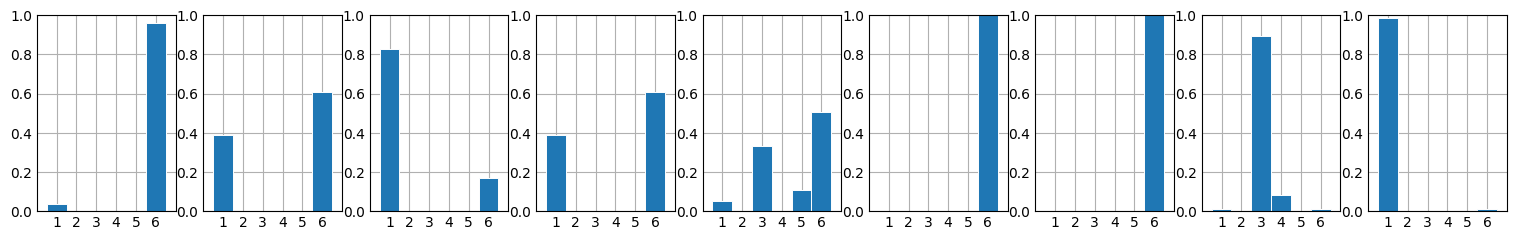

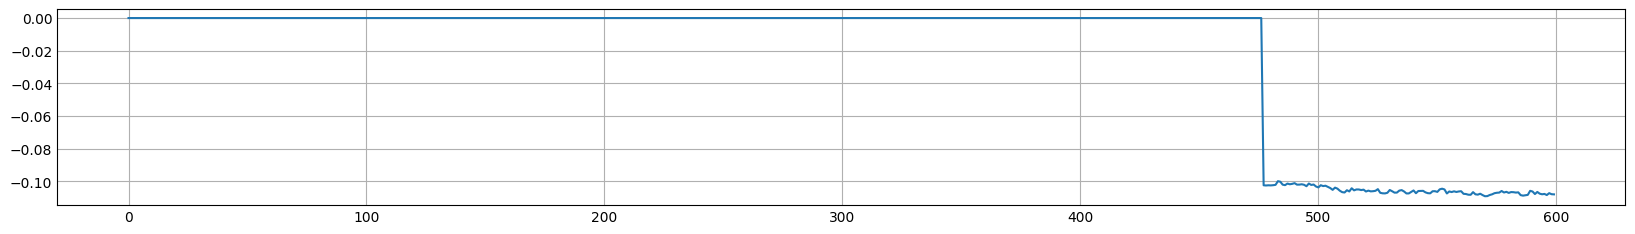

203 361
file: ../data/json/healthy/203_361_01.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/203_361_02.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/203_361_03.json pred: [0] real: 0 confusion: [1.66893e-06]
file: ../data/json/healthy/203_361_04.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/203_361_05.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/203_361_06.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/203_361_07.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/203_361_08.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/203_361_09.json pred: [0] real: 0 confusion: [0.]


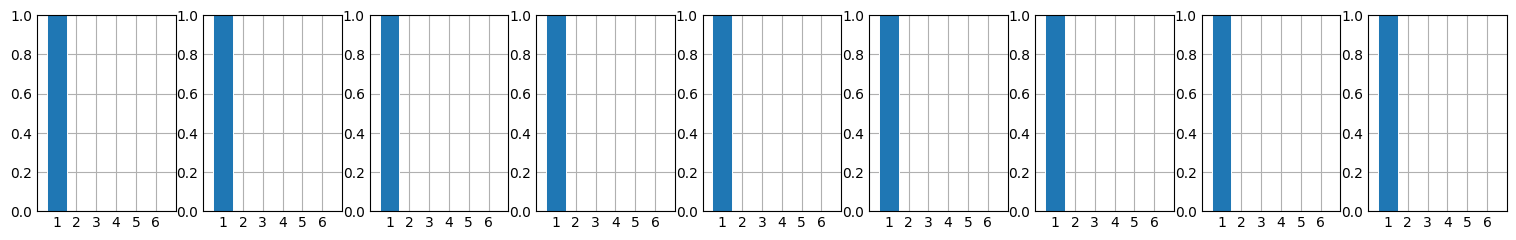

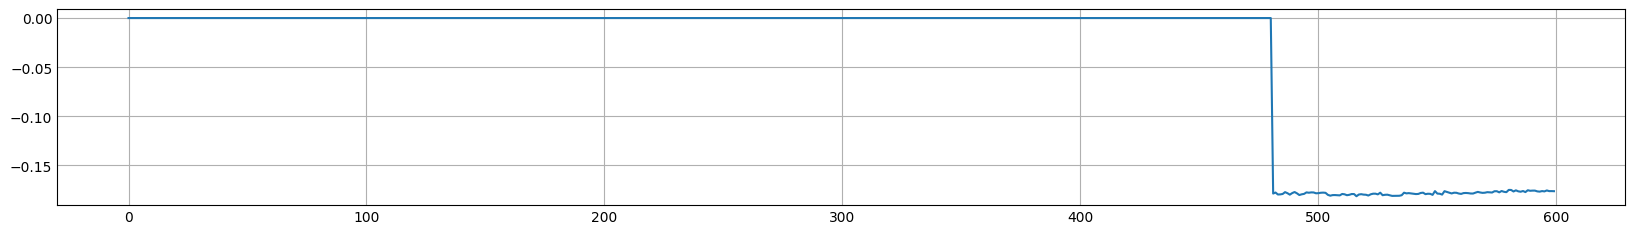

205 363
file: ../data/json/healthy/205_363_01.json pred: [1] real: 0 confusion: [5.722046e-06]
file: ../data/json/healthy/205_363_02.json pred: [0] real: 0 confusion: [4.4345856e-05]
file: ../data/json/healthy/205_363_03.json pred: [1] real: 0 confusion: [0.41571903]
file: ../data/json/healthy/205_363_04.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/205_363_05.json pred: [1] real: 0 confusion: [0.2835635]
file: ../data/json/healthy/205_363_06.json pred: [0] real: 0 confusion: [5.9604645e-06]
file: ../data/json/healthy/205_363_07.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/205_363_08.json pred: [1] real: 0 confusion: [0.02081662]
file: ../data/json/healthy/205_363_09.json pred: [0] real: 0 confusion: [1.1920929e-07]


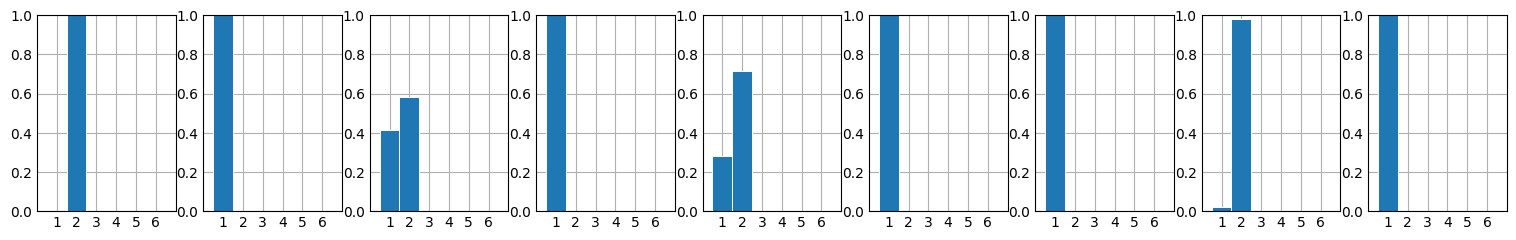

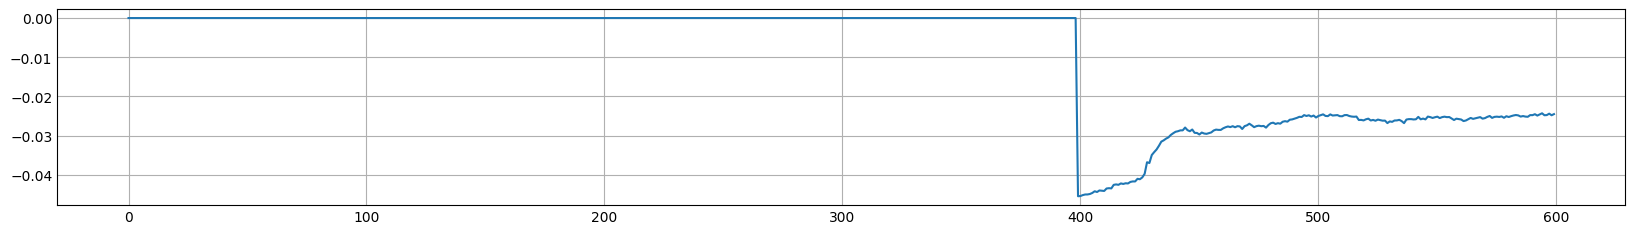

206 364
file: ../data/json/healthy/206_364_01.json pred: [0] real: 0 confusion: [0.0558368]
file: ../data/json/healthy/206_364_02.json pred: [1] real: 0 confusion: [0.00488812]
file: ../data/json/healthy/206_364_03.json pred: [1] real: 0 confusion: [0.00693041]
file: ../data/json/healthy/206_364_04.json pred: [1] real: 0 confusion: [0.0003069]
file: ../data/json/healthy/206_364_05.json pred: [1] real: 0 confusion: [0.00040966]
file: ../data/json/healthy/206_364_06.json pred: [1] real: 0 confusion: [0.00180954]
file: ../data/json/healthy/206_364_07.json pred: [1] real: 0 confusion: [0.00795507]
file: ../data/json/healthy/206_364_08.json pred: [0] real: 0 confusion: [0.14553756]
file: ../data/json/healthy/206_364_09.json pred: [0] real: 0 confusion: [0.4196015]


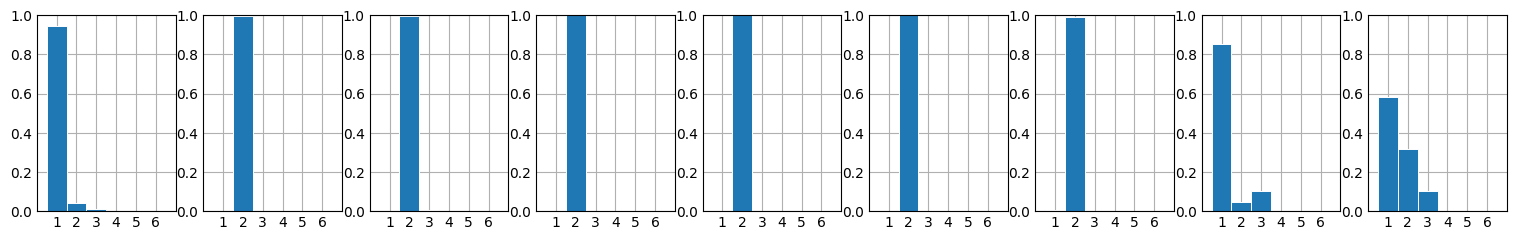

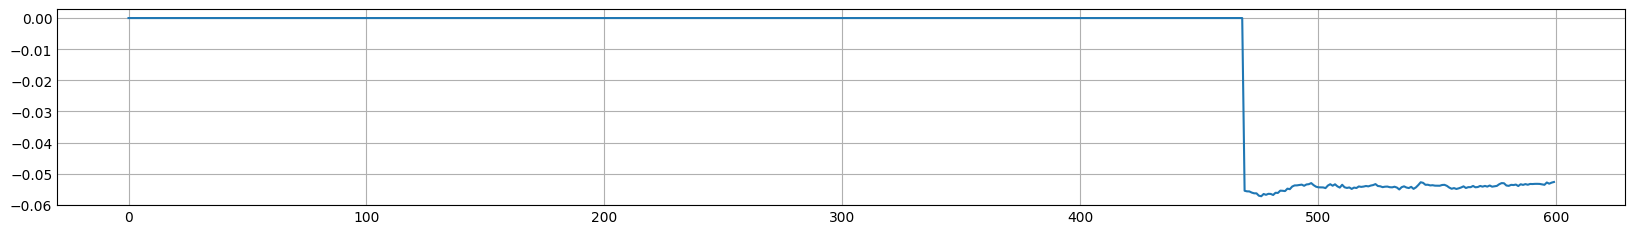

207 365
file: ../data/json/healthy/207_365_01.json pred: [0] real: 0 confusion: [0.10610616]
file: ../data/json/healthy/207_365_02.json pred: [0] real: 0 confusion: [0.2700985]
file: ../data/json/healthy/207_365_03.json pred: [2] real: 0 confusion: [0.01830953]
file: ../data/json/healthy/207_365_04.json pred: [0] real: 0 confusion: [2.9802322e-07]
file: ../data/json/healthy/207_365_05.json pred: [0] real: 0 confusion: [0.00025988]
file: ../data/json/healthy/207_365_06.json pred: [0] real: 0 confusion: [0.23911709]
file: ../data/json/healthy/207_365_07.json pred: [2] real: 0 confusion: [0.00583297]
file: ../data/json/healthy/207_365_08.json pred: [1] real: 0 confusion: [0.02588397]
file: ../data/json/healthy/207_365_09.json pred: [1] real: 0 confusion: [0.32114005]


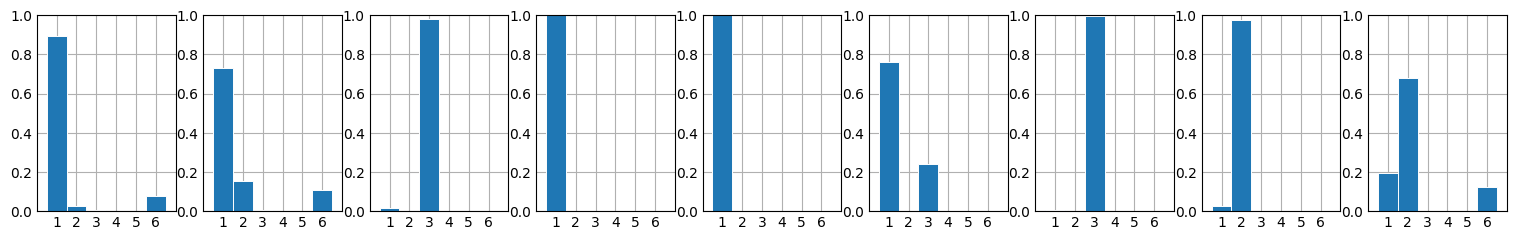

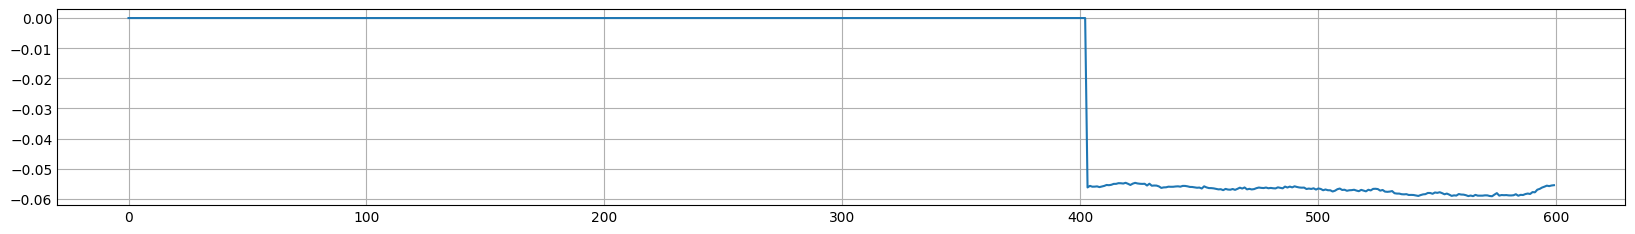

208 366
file: ../data/json/healthy/208_366_01.json pred: [1] real: 0 confusion: [0.00160593]
file: ../data/json/healthy/208_366_02.json pred: [1] real: 0 confusion: [0.25086534]
file: ../data/json/healthy/208_366_03.json pred: [1] real: 0 confusion: [0.22812754]
file: ../data/json/healthy/208_366_04.json pred: [0] real: 0 confusion: [0.19357169]
file: ../data/json/healthy/208_366_05.json pred: [0] real: 0 confusion: [0.00411016]
file: ../data/json/healthy/208_366_06.json pred: [0] real: 0 confusion: [0.00900078]
file: ../data/json/healthy/208_366_07.json pred: [0] real: 0 confusion: [0.00541228]
file: ../data/json/healthy/208_366_08.json pred: [0] real: 0 confusion: [0.02561563]
file: ../data/json/healthy/208_366_09.json pred: [0] real: 0 confusion: [0.01370102]


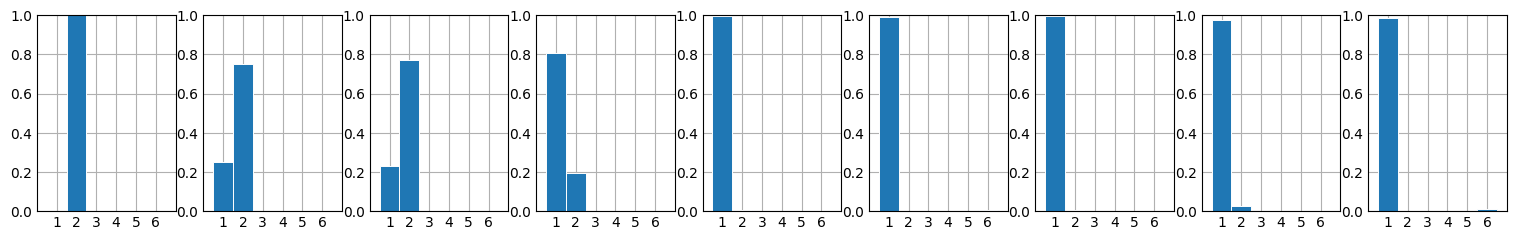

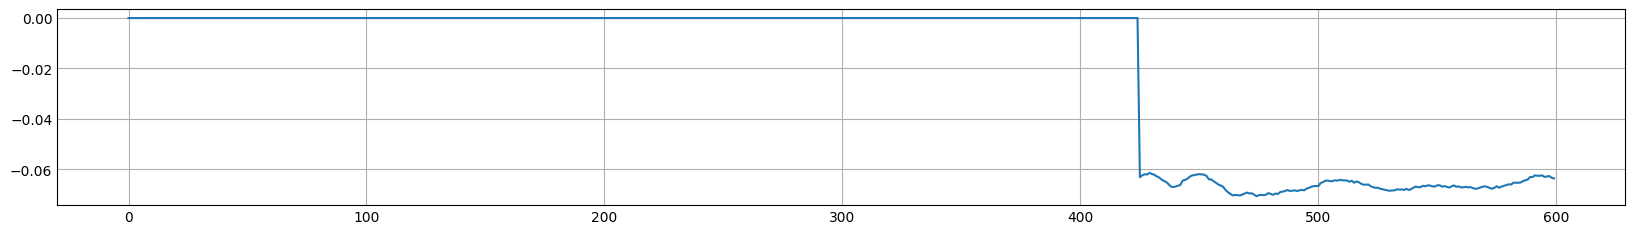

209 367
file: ../data/json/healthy/209_367_01.json pred: [0] real: 0 confusion: [0.00048149]
file: ../data/json/healthy/209_367_02.json pred: [1] real: 0 confusion: [0.00509703]
file: ../data/json/healthy/209_367_03.json pred: [0] real: 0 confusion: [0.00054252]
file: ../data/json/healthy/209_367_04.json pred: [0] real: 0 confusion: [0.03947276]
file: ../data/json/healthy/209_367_05.json pred: [0] real: 0 confusion: [1.6093254e-06]
file: ../data/json/healthy/209_367_06.json pred: [0] real: 0 confusion: [1.2814999e-05]
file: ../data/json/healthy/209_367_07.json pred: [0] real: 0 confusion: [0.00020164]
file: ../data/json/healthy/209_367_08.json pred: [0] real: 0 confusion: [5.9604645e-07]
file: ../data/json/healthy/209_367_09.json pred: [0] real: 0 confusion: [0.04523641]


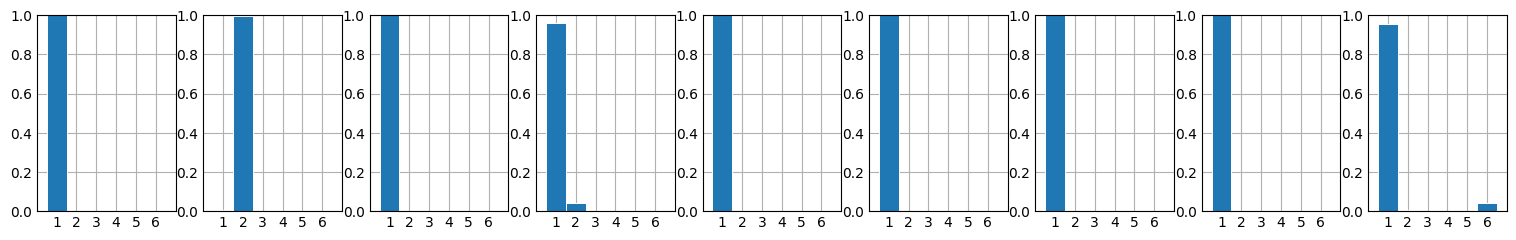

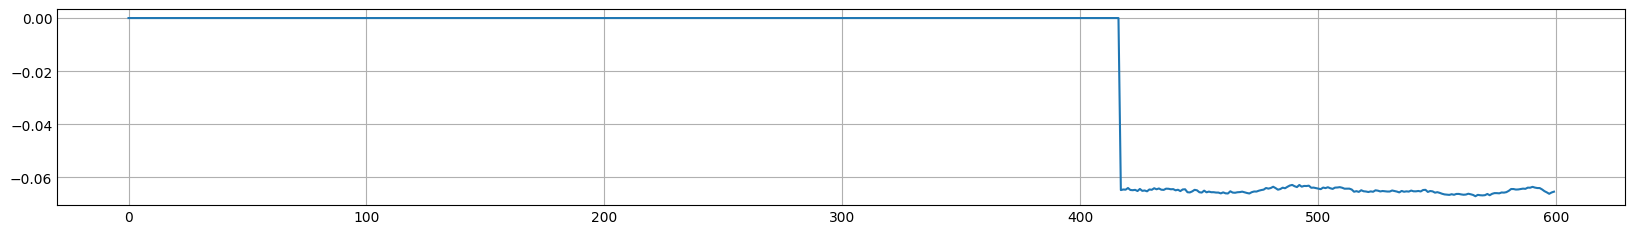

210 368
file: ../data/json/healthy/210_368_01.json pred: [0] real: 0 confusion: [7.158518e-05]
file: ../data/json/healthy/210_368_02.json pred: [5] real: 0 confusion: [0.00311816]
file: ../data/json/healthy/210_368_03.json pred: [0] real: 0 confusion: [0.00177598]
file: ../data/json/healthy/210_368_04.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/210_368_05.json pred: [0] real: 0 confusion: [0.00241369]
file: ../data/json/healthy/210_368_06.json pred: [0] real: 0 confusion: [7.2717667e-06]
file: ../data/json/healthy/210_368_07.json pred: [4] real: 0 confusion: [0.241943]
file: ../data/json/healthy/210_368_08.json pred: [0] real: 0 confusion: [0.00369883]
file: ../data/json/healthy/210_368_09.json pred: [0] real: 0 confusion: [0.01961631]


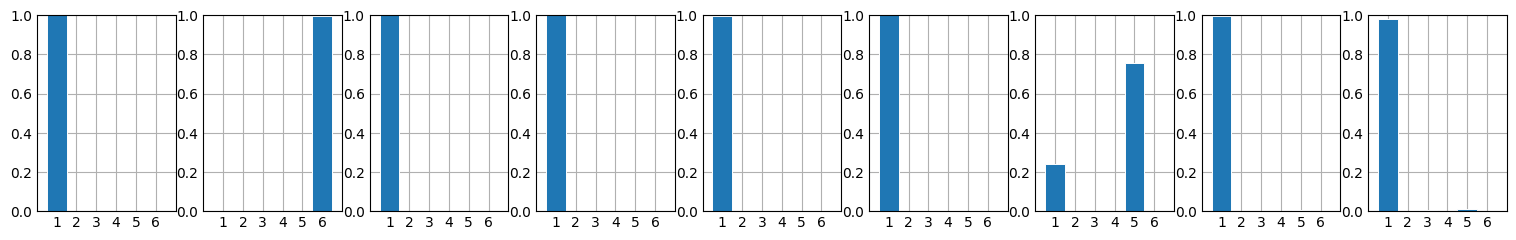

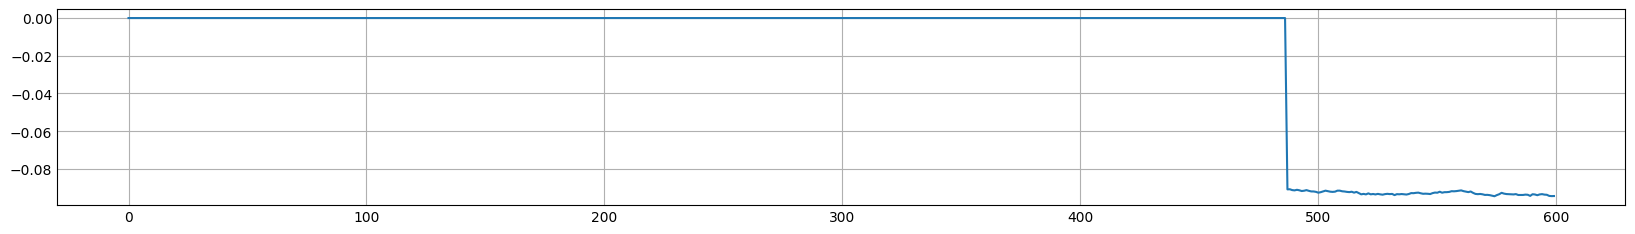

211 369
file: ../data/json/healthy/211_369_01.json pred: [0] real: 0 confusion: [0.34325242]
file: ../data/json/healthy/211_369_02.json pred: [1] real: 0 confusion: [6.4373016e-06]
file: ../data/json/healthy/211_369_03.json pred: [1] real: 0 confusion: [0.59820783]
file: ../data/json/healthy/211_369_04.json pred: [1] real: 0 confusion: [0.04915529]
file: ../data/json/healthy/211_369_05.json pred: [1] real: 0 confusion: [0.00029564]
file: ../data/json/healthy/211_369_06.json pred: [0] real: 0 confusion: [0.37876678]
file: ../data/json/healthy/211_369_07.json pred: [1] real: 0 confusion: [6.198883e-06]
file: ../data/json/healthy/211_369_08.json pred: [1] real: 0 confusion: [8.821487e-06]
file: ../data/json/healthy/211_369_09.json pred: [1] real: 0 confusion: [2.604723e-05]


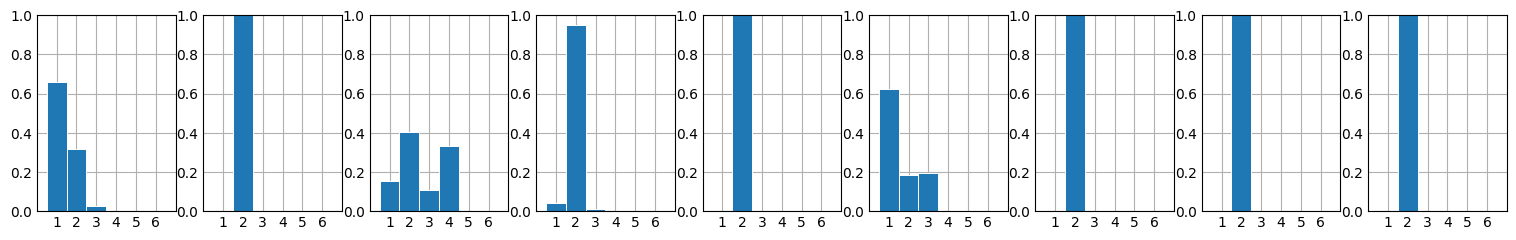

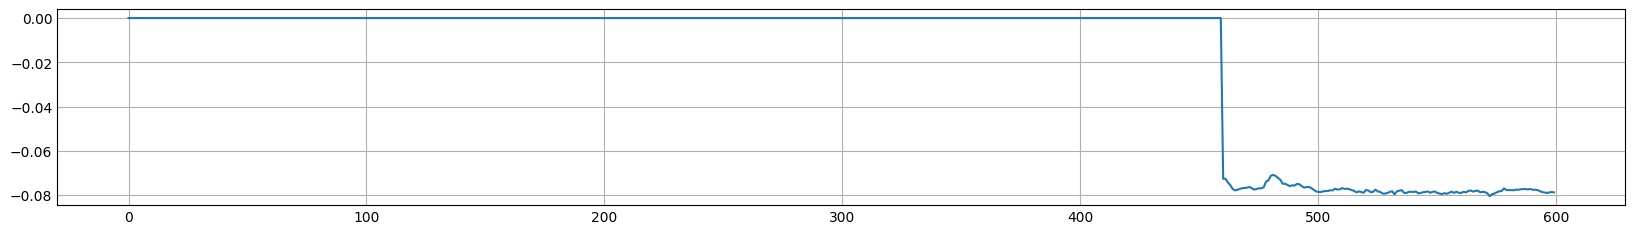

212 370
file: ../data/json/healthy/212_370_01.json pred: [1] real: 0 confusion: [0.00110227]
file: ../data/json/healthy/212_370_02.json pred: [1] real: 0 confusion: [0.0865708]
file: ../data/json/healthy/212_370_03.json pred: [1] real: 0 confusion: [0.00028688]
file: ../data/json/healthy/212_370_04.json pred: [1] real: 0 confusion: [7.748604e-07]
file: ../data/json/healthy/212_370_05.json pred: [0] real: 0 confusion: [0.00225419]
file: ../data/json/healthy/212_370_06.json pred: [0] real: 0 confusion: [0.00204515]
file: ../data/json/healthy/212_370_07.json pred: [0] real: 0 confusion: [0.02099878]
file: ../data/json/healthy/212_370_08.json pred: [0] real: 0 confusion: [0.22175258]
file: ../data/json/healthy/212_370_09.json pred: [1] real: 0 confusion: [0.00648814]


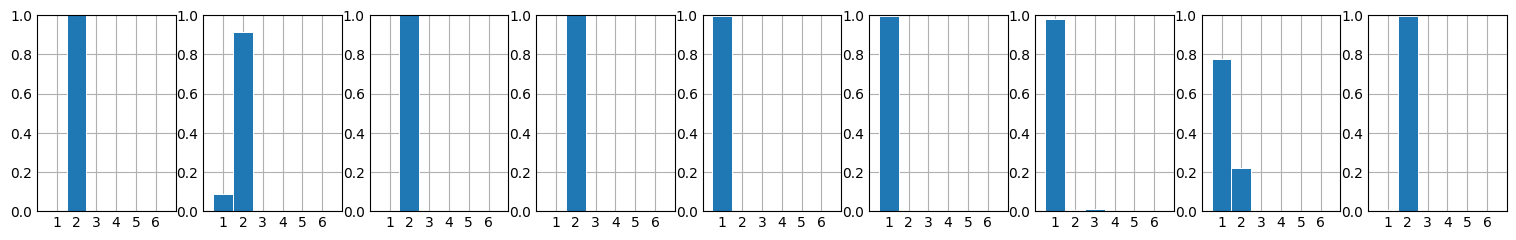

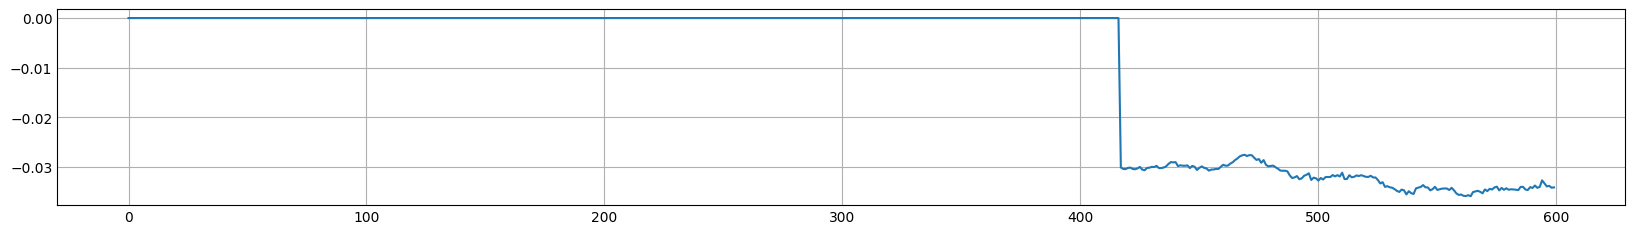

213 371
file: ../data/json/healthy/213_371_01.json pred: [2] real: 0 confusion: [2.193451e-05]
file: ../data/json/healthy/213_371_02.json pred: [2] real: 0 confusion: [8.022785e-05]
file: ../data/json/healthy/213_371_03.json pred: [1] real: 0 confusion: [0.16491878]
file: ../data/json/healthy/213_371_04.json pred: [1] real: 0 confusion: [0.18965322]
file: ../data/json/healthy/213_371_05.json pred: [2] real: 0 confusion: [1.8179417e-05]
file: ../data/json/healthy/213_371_06.json pred: [2] real: 0 confusion: [0.04008687]
file: ../data/json/healthy/213_371_07.json pred: [1] real: 0 confusion: [0.18851781]
file: ../data/json/healthy/213_371_08.json pred: [0] real: 0 confusion: [0.3898276]
file: ../data/json/healthy/213_371_09.json pred: [2] real: 0 confusion: [0.30355483]


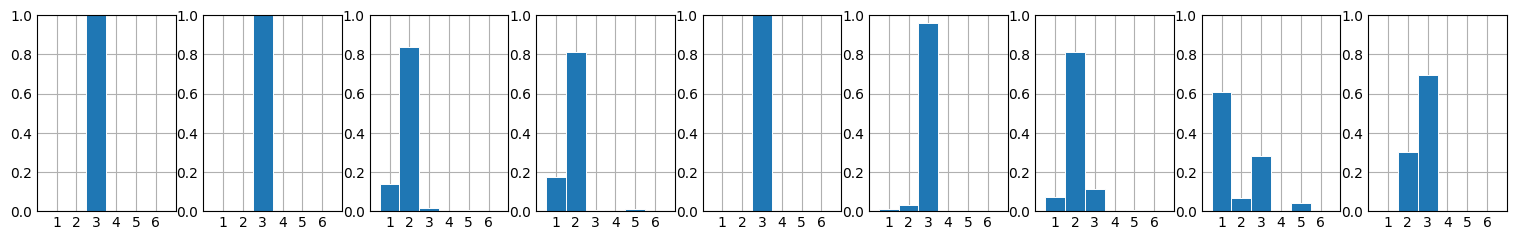

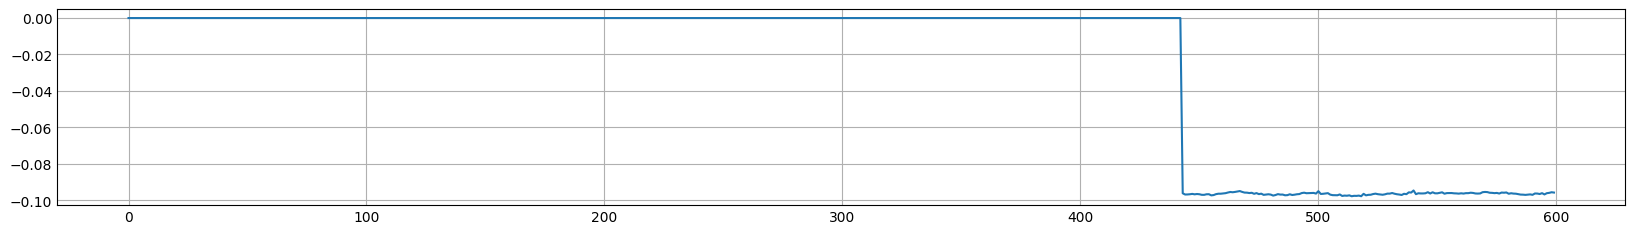

214 372
file: ../data/json/healthy/214_372_01.json pred: [2] real: 0 confusion: [0.00018424]
file: ../data/json/healthy/214_372_02.json pred: [2] real: 0 confusion: [3.3020973e-05]
file: ../data/json/healthy/214_372_03.json pred: [2] real: 0 confusion: [3.0398369e-06]
file: ../data/json/healthy/214_372_04.json pred: [2] real: 0 confusion: [0.00021726]
file: ../data/json/healthy/214_372_05.json pred: [2] real: 0 confusion: [7.390976e-06]
file: ../data/json/healthy/214_372_06.json pred: [2] real: 0 confusion: [0.08288926]
file: ../data/json/healthy/214_372_07.json pred: [2] real: 0 confusion: [3.886223e-05]
file: ../data/json/healthy/214_372_08.json pred: [2] real: 0 confusion: [6.777048e-05]
file: ../data/json/healthy/214_372_09.json pred: [2] real: 0 confusion: [1.4305115e-06]


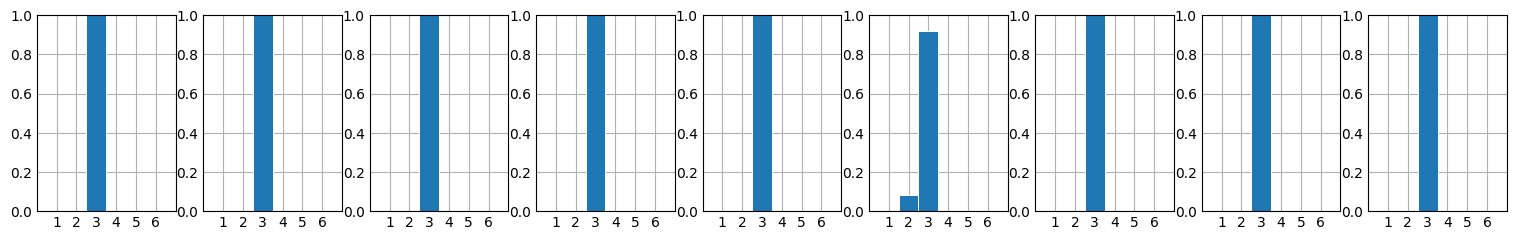

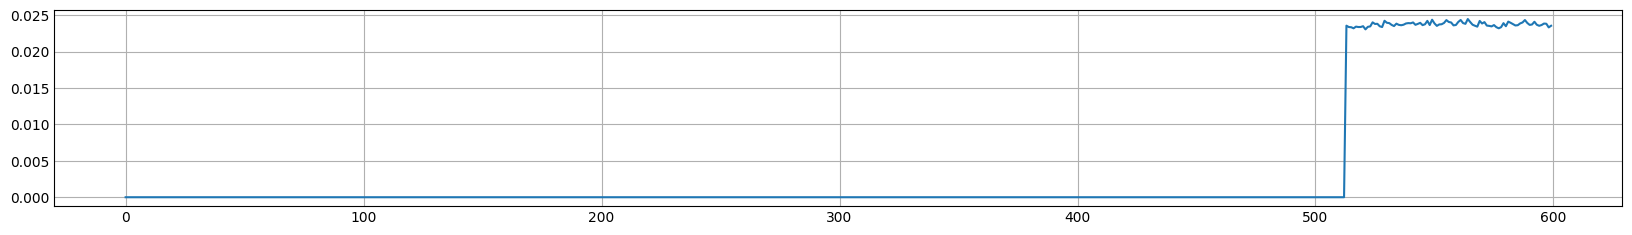

215 373
file: ../data/json/healthy/215_373_01.json pred: [0] real: 0 confusion: [0.00015026]
file: ../data/json/healthy/215_373_02.json pred: [0] real: 0 confusion: [0.0052855]
file: ../data/json/healthy/215_373_03.json pred: [0] real: 0 confusion: [0.01241237]
file: ../data/json/healthy/215_373_04.json pred: [0] real: 0 confusion: [0.05236888]
file: ../data/json/healthy/215_373_05.json pred: [0] real: 0 confusion: [0.0020873]
file: ../data/json/healthy/215_373_06.json pred: [0] real: 0 confusion: [0.33063018]
file: ../data/json/healthy/215_373_07.json pred: [0] real: 0 confusion: [0.49375248]
file: ../data/json/healthy/215_373_08.json pred: [0] real: 0 confusion: [0.00038075]
file: ../data/json/healthy/215_373_09.json pred: [5] real: 0 confusion: [0.04875427]


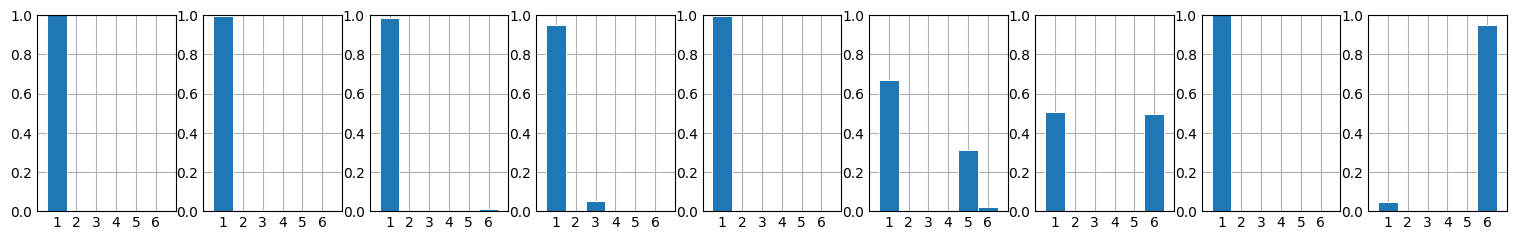

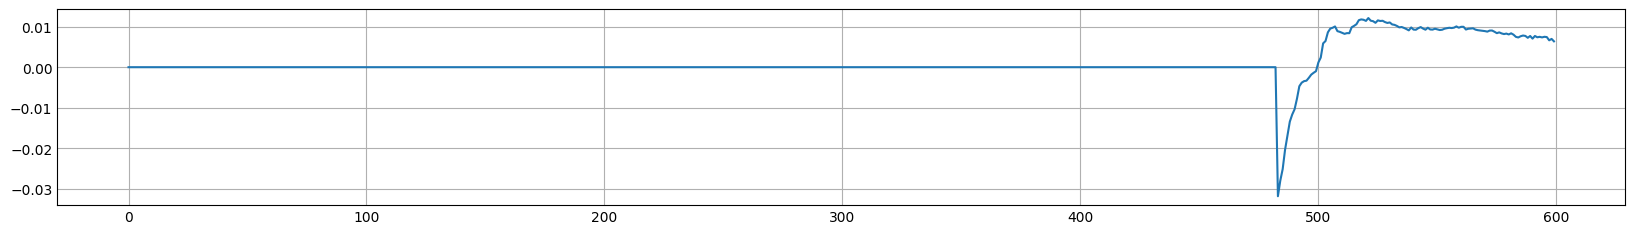

216 374
file: ../data/json/healthy/216_374_01.json pred: [0] real: 0 confusion: [0.10464615]
file: ../data/json/healthy/216_374_02.json pred: [0] real: 0 confusion: [0.00170076]
file: ../data/json/healthy/216_374_03.json pred: [0] real: 0 confusion: [0.49456978]
file: ../data/json/healthy/216_374_04.json pred: [0] real: 0 confusion: [0.01681501]
file: ../data/json/healthy/216_374_05.json pred: [0] real: 0 confusion: [0.01032811]
file: ../data/json/healthy/216_374_06.json pred: [0] real: 0 confusion: [0.32835847]
file: ../data/json/healthy/216_374_07.json pred: [0] real: 0 confusion: [0.03551435]
file: ../data/json/healthy/216_374_08.json pred: [0] real: 0 confusion: [0.42055237]
file: ../data/json/healthy/216_374_09.json pred: [1] real: 0 confusion: [0.18942064]


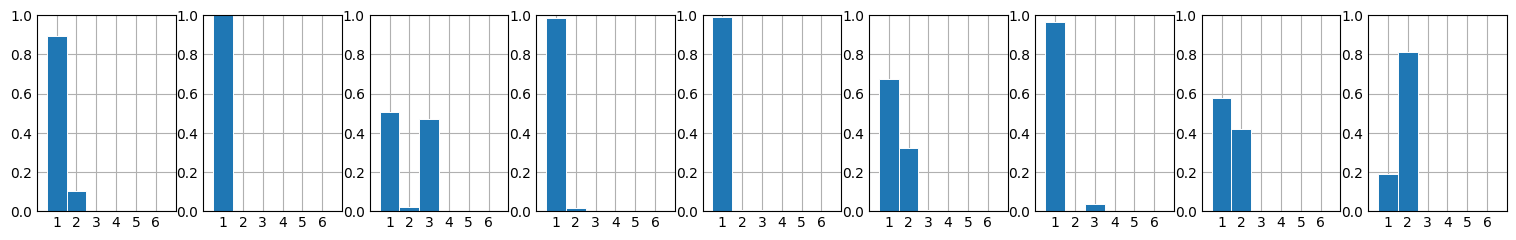

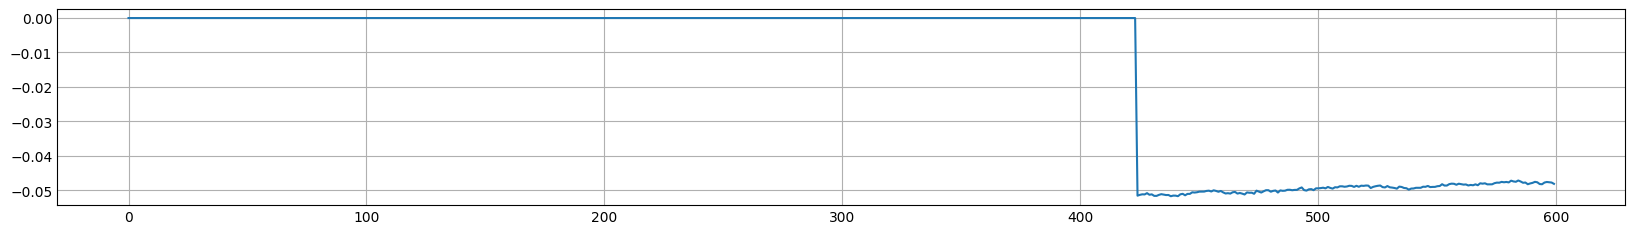

217 375
file: ../data/json/healthy/217_375_01.json pred: [1] real: 0 confusion: [0.44523853]
file: ../data/json/healthy/217_375_02.json pred: [2] real: 0 confusion: [0.08804142]
file: ../data/json/healthy/217_375_03.json pred: [3] real: 0 confusion: [0.04302186]
file: ../data/json/healthy/217_375_04.json pred: [2] real: 0 confusion: [0.12968534]
file: ../data/json/healthy/217_375_05.json pred: [2] real: 0 confusion: [0.01431316]
file: ../data/json/healthy/217_375_06.json pred: [2] real: 0 confusion: [0.13043892]
file: ../data/json/healthy/217_375_07.json pred: [1] real: 0 confusion: [0.00011033]
file: ../data/json/healthy/217_375_08.json pred: [0] real: 0 confusion: [0.0013864]
file: ../data/json/healthy/217_375_09.json pred: [0] real: 0 confusion: [0.00111192]


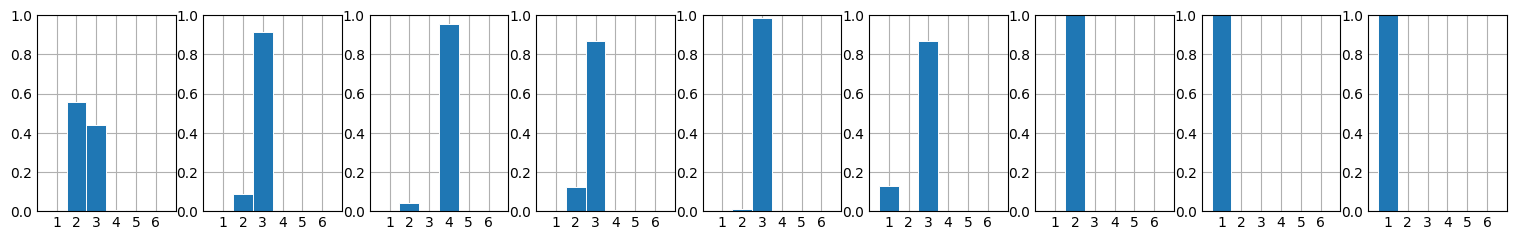

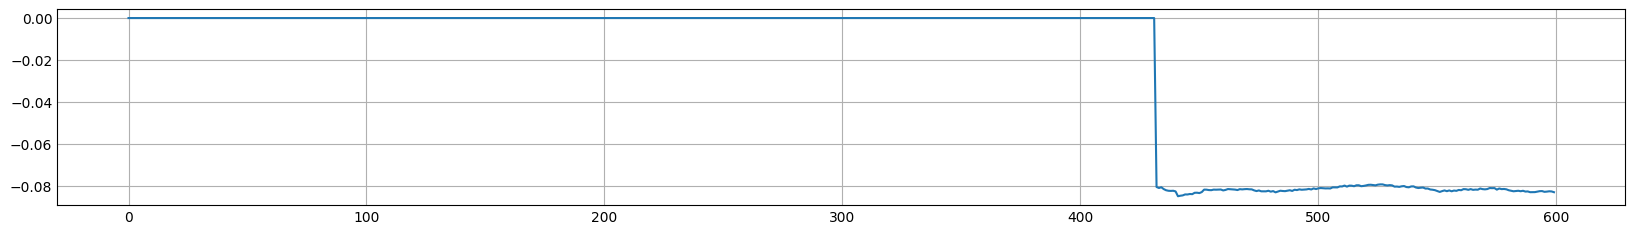

218 376
file: ../data/json/healthy/218_376_01.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/218_376_02.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/218_376_03.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/218_376_04.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/218_376_05.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/218_376_06.json pred: [0] real: 0 confusion: [7.748604e-07]
file: ../data/json/healthy/218_376_07.json pred: [0] real: 0 confusion: [2.3841858e-07]
file: ../data/json/healthy/218_376_08.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/218_376_09.json pred: [0] real: 0 confusion: [0.]


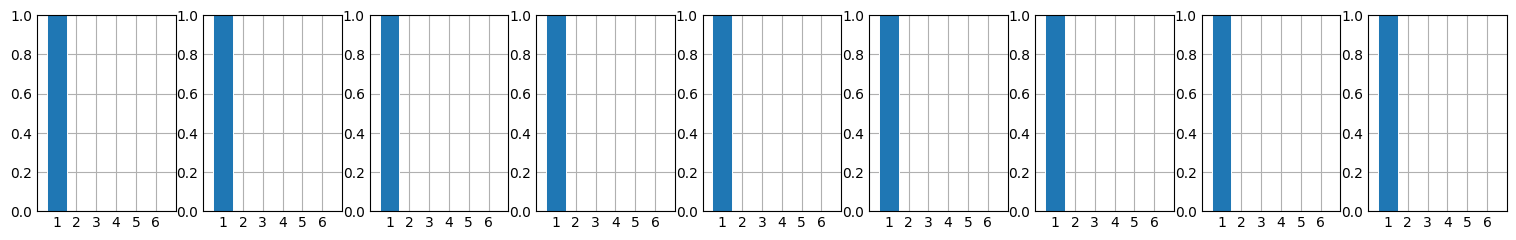

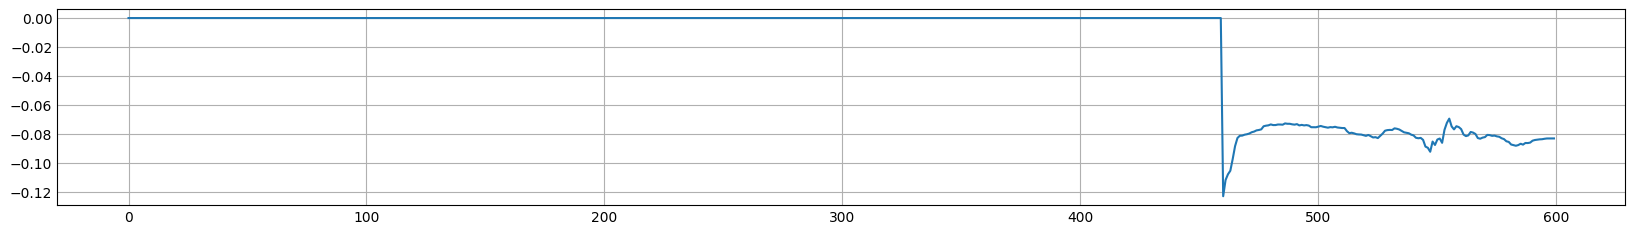

219 377
file: ../data/json/healthy/219_377_01.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/219_377_02.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/219_377_03.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/219_377_04.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/219_377_05.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/219_377_06.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/219_377_07.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/219_377_08.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/219_377_09.json pred: [0] real: 0 confusion: [5.5789948e-05]


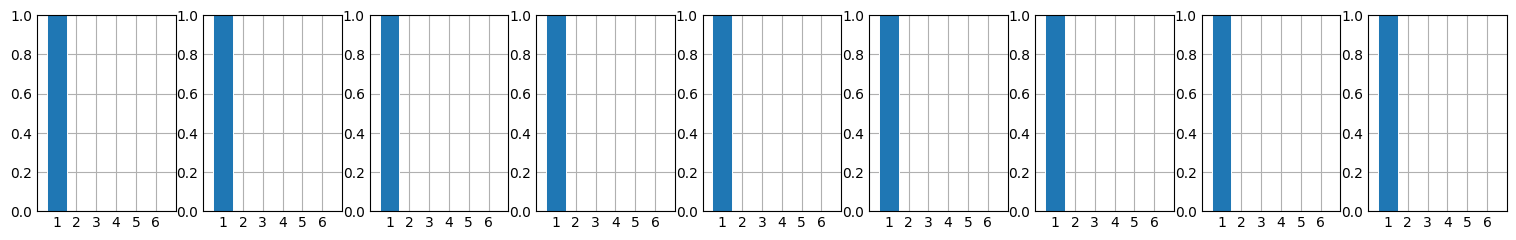

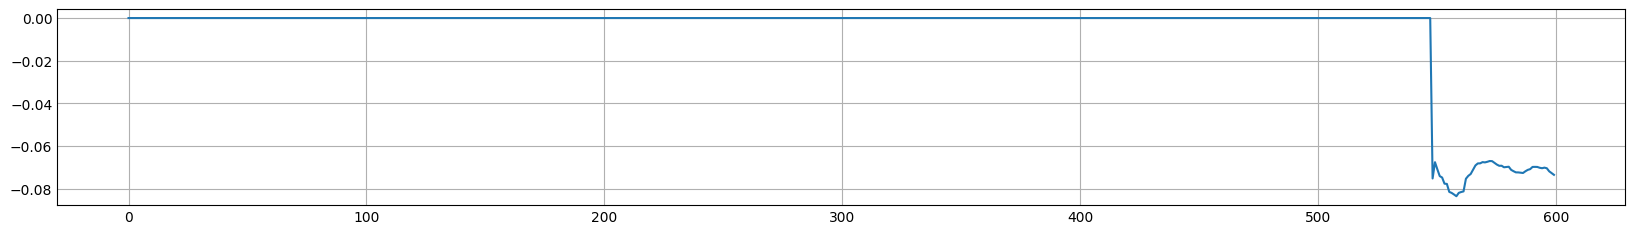

220 378
file: ../data/json/healthy/220_378_01.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/220_378_02.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/220_378_03.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/220_378_04.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/220_378_05.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/220_378_06.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/220_378_07.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/220_378_08.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/220_378_09.json pred: [0] real: 0 confusion: [0.]


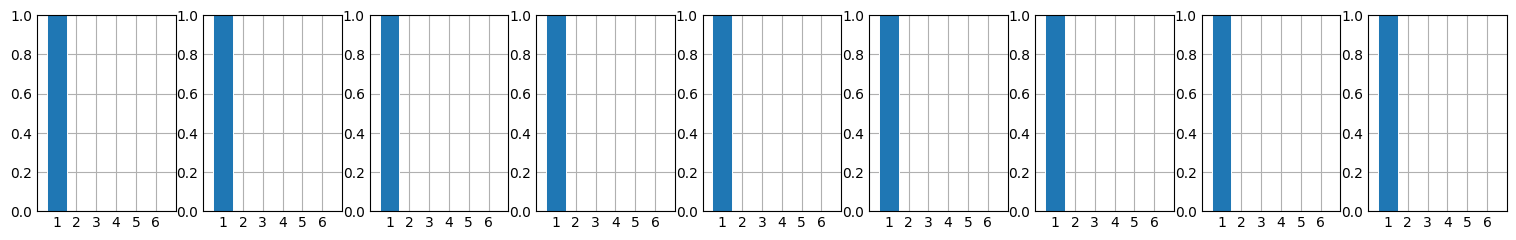

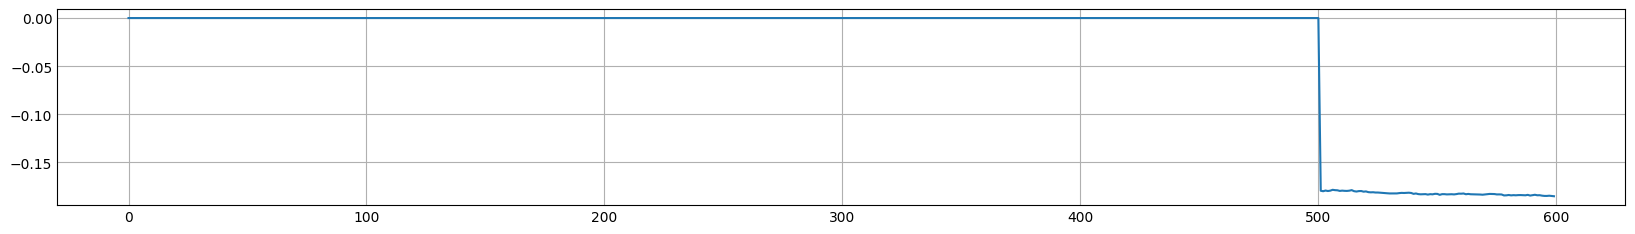

221 379
file: ../data/json/healthy/221_379_01.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/221_379_02.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/221_379_03.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/221_379_04.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/221_379_05.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/221_379_06.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/221_379_07.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/221_379_08.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/221_379_09.json pred: [0] real: 0 confusion: [0.]


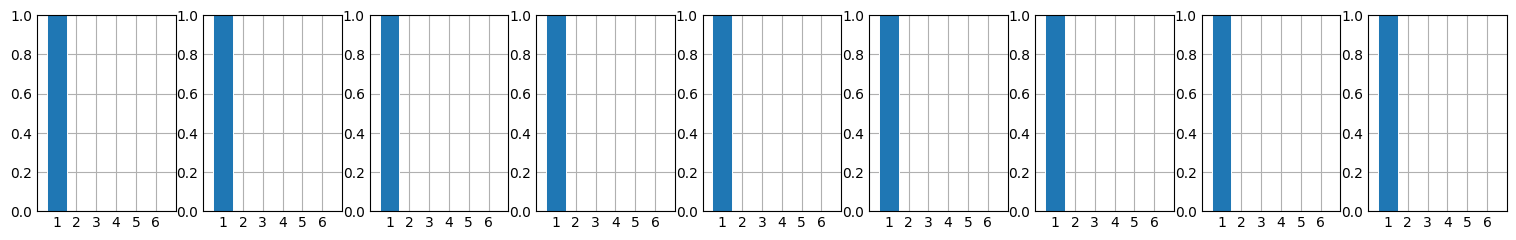

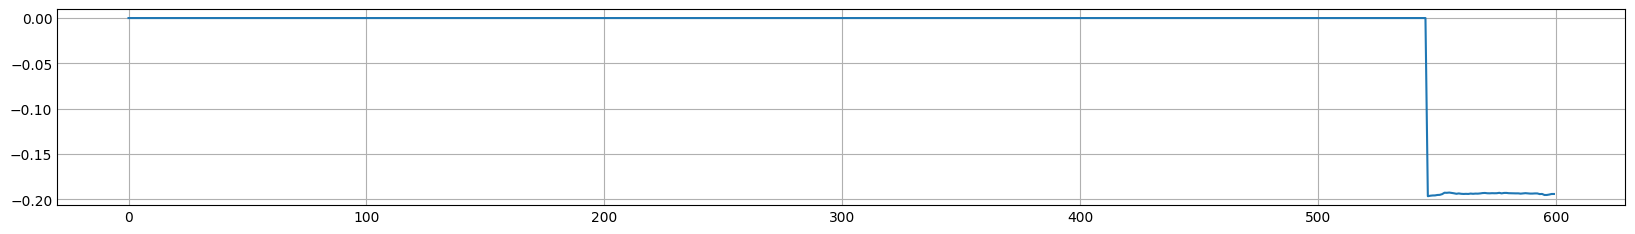

222 380
file: ../data/json/healthy/222_380_01.json pred: [0] real: 0 confusion: [0.00729424]
file: ../data/json/healthy/222_380_02.json pred: [0] real: 0 confusion: [0.00137293]
file: ../data/json/healthy/222_380_03.json pred: [0] real: 0 confusion: [0.00026208]
file: ../data/json/healthy/222_380_04.json pred: [0] real: 0 confusion: [1.835823e-05]
file: ../data/json/healthy/222_380_05.json pred: [0] real: 0 confusion: [0.00049114]
file: ../data/json/healthy/222_380_06.json pred: [0] real: 0 confusion: [3.5762787e-07]
file: ../data/json/healthy/222_380_07.json pred: [1] real: 0 confusion: [0.1191898]
file: ../data/json/healthy/222_380_08.json pred: [0] real: 0 confusion: [0.00168526]
file: ../data/json/healthy/222_380_09.json pred: [0] real: 0 confusion: [0.00052124]


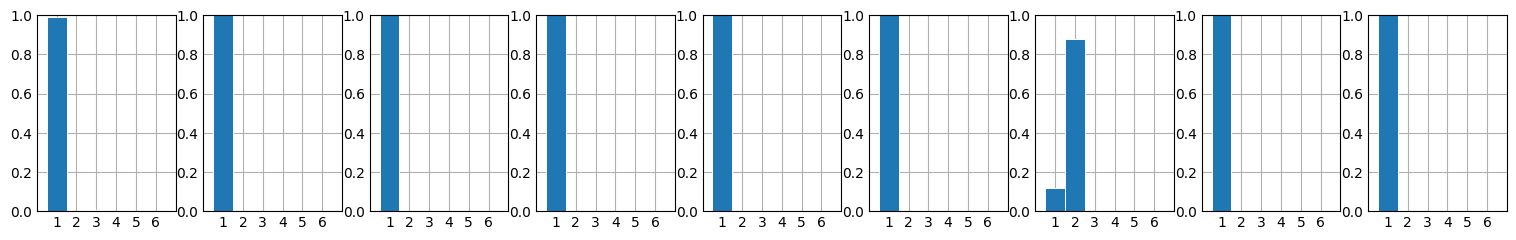

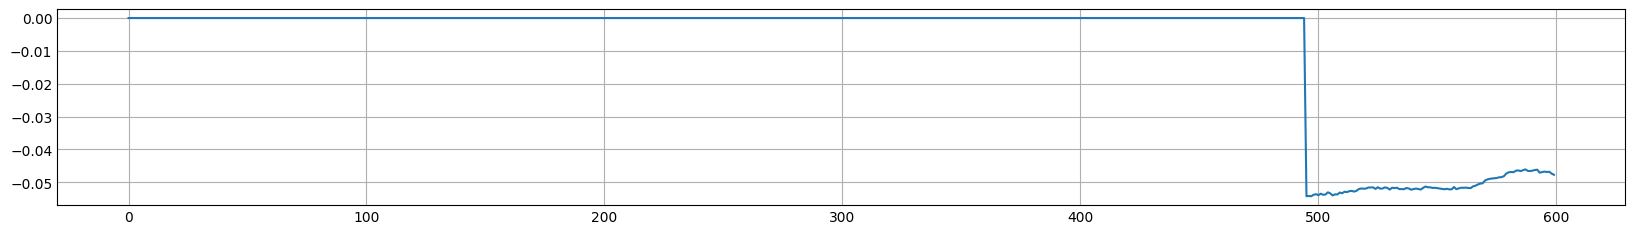

223 381
file: ../data/json/healthy/223_381_01.json pred: [0] real: 0 confusion: [0.0004378]
file: ../data/json/healthy/223_381_02.json pred: [0] real: 0 confusion: [4.172325e-05]
file: ../data/json/healthy/223_381_03.json pred: [0] real: 0 confusion: [0.11673939]
file: ../data/json/healthy/223_381_04.json pred: [0] real: 0 confusion: [0.00827384]
file: ../data/json/healthy/223_381_05.json pred: [2] real: 0 confusion: [0.39843297]
file: ../data/json/healthy/223_381_06.json pred: [0] real: 0 confusion: [0.0003987]
file: ../data/json/healthy/223_381_07.json pred: [4] real: 0 confusion: [0.00077617]
file: ../data/json/healthy/223_381_08.json pred: [0] real: 0 confusion: [0.00020534]
file: ../data/json/healthy/223_381_09.json pred: [4] real: 0 confusion: [0.08970523]


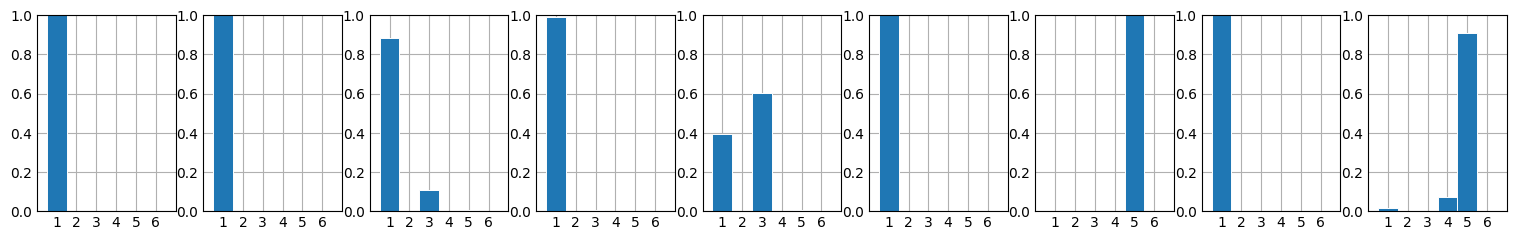

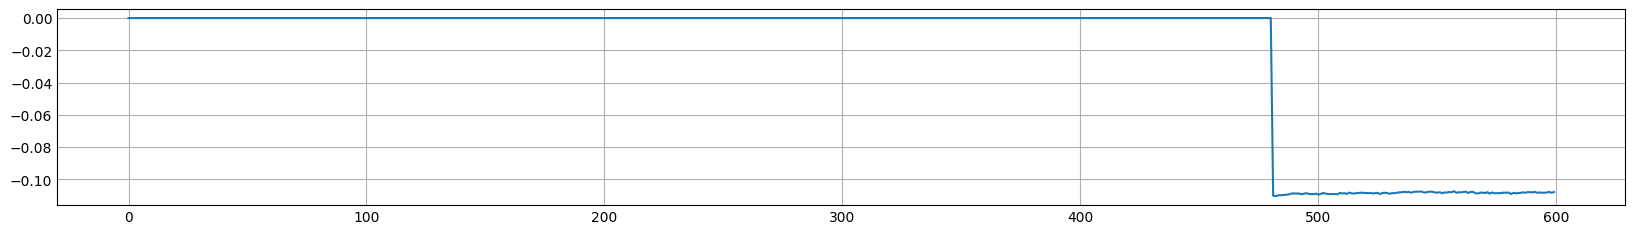

224 382
file: ../data/json/healthy/224_382_01.json pred: [0] real: 0 confusion: [0.47657198]
file: ../data/json/healthy/224_382_02.json pred: [0] real: 0 confusion: [0.00102735]
file: ../data/json/healthy/224_382_03.json pred: [0] real: 0 confusion: [0.00033188]
file: ../data/json/healthy/224_382_04.json pred: [0] real: 0 confusion: [0.00018245]
file: ../data/json/healthy/224_382_05.json pred: [0] real: 0 confusion: [0.04010123]
file: ../data/json/healthy/224_382_06.json pred: [0] real: 0 confusion: [0.00077045]
file: ../data/json/healthy/224_382_07.json pred: [0] real: 0 confusion: [0.42310756]
file: ../data/json/healthy/224_382_08.json pred: [2] real: 0 confusion: [0.28006977]
file: ../data/json/healthy/224_382_09.json pred: [0] real: 0 confusion: [0.00050986]


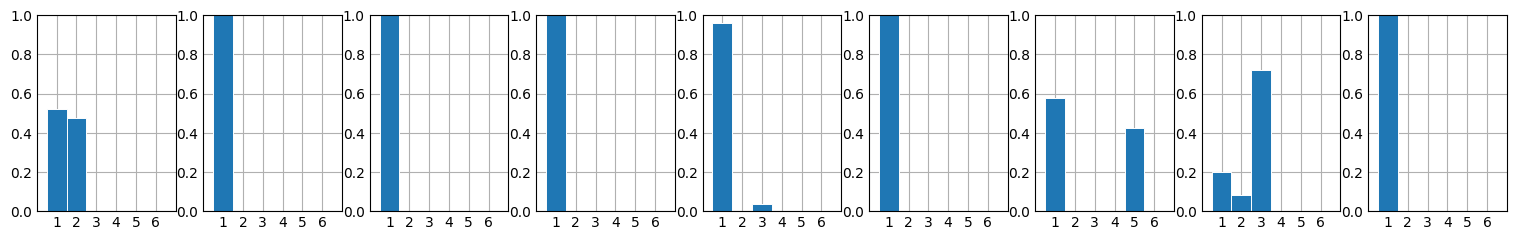

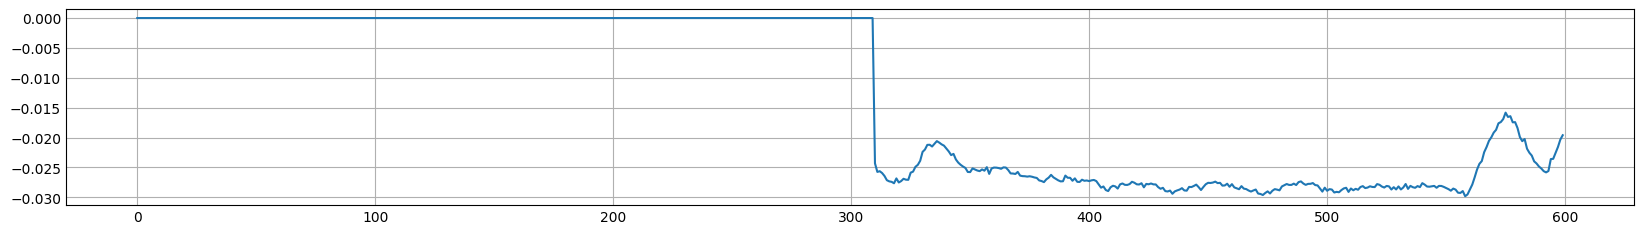

225 383
file: ../data/json/healthy/225_383_01.json pred: [0] real: 0 confusion: [0.10533667]
file: ../data/json/healthy/225_383_02.json pred: [2] real: 0 confusion: [0.1980859]
file: ../data/json/healthy/225_383_03.json pred: [0] real: 0 confusion: [0.02058315]
file: ../data/json/healthy/225_383_04.json pred: [0] real: 0 confusion: [0.49036556]
file: ../data/json/healthy/225_383_05.json pred: [2] real: 0 confusion: [0.07238048]
file: ../data/json/healthy/225_383_06.json pred: [0] real: 0 confusion: [0.42656165]
file: ../data/json/healthy/225_383_07.json pred: [2] real: 0 confusion: [0.00014305]
file: ../data/json/healthy/225_383_08.json pred: [2] real: 0 confusion: [0.04542708]
file: ../data/json/healthy/225_383_09.json pred: [1] real: 0 confusion: [1.2516975e-06]


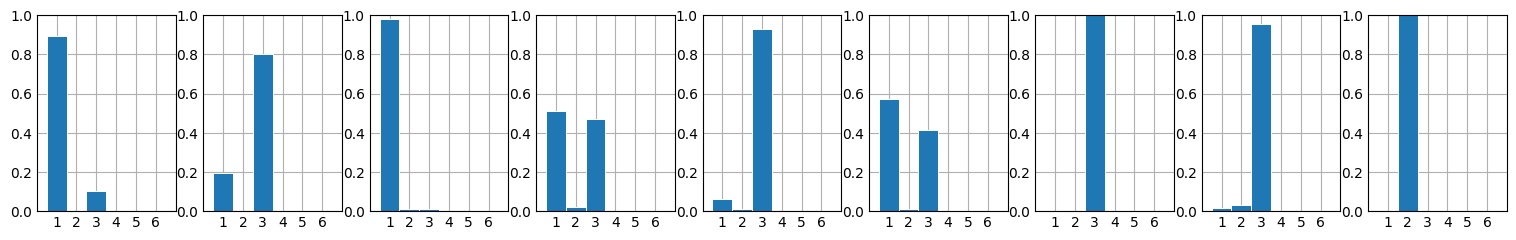

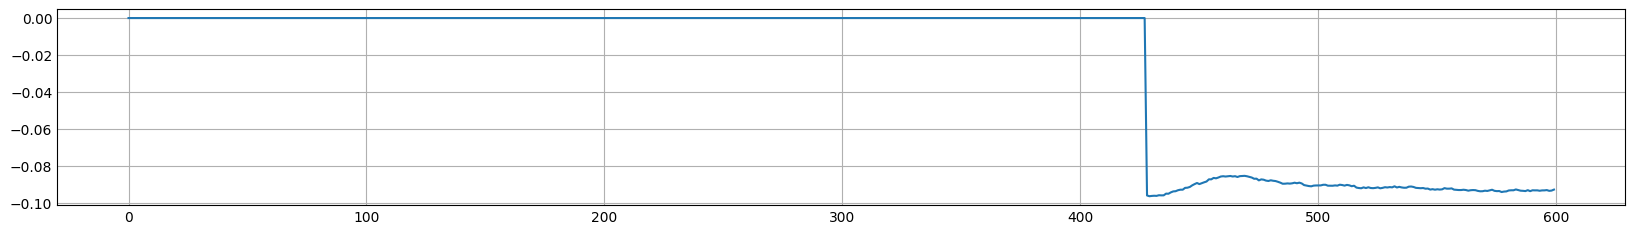

226 384
file: ../data/json/healthy/226_384_01.json pred: [0] real: 0 confusion: [0.00042516]
file: ../data/json/healthy/226_384_02.json pred: [2] real: 0 confusion: [1.1920929e-07]
file: ../data/json/healthy/226_384_03.json pred: [0] real: 0 confusion: [0.01019281]
file: ../data/json/healthy/226_384_04.json pred: [0] real: 0 confusion: [0.00435531]
file: ../data/json/healthy/226_384_05.json pred: [0] real: 0 confusion: [0.16104424]
file: ../data/json/healthy/226_384_06.json pred: [0] real: 0 confusion: [0.03244114]
file: ../data/json/healthy/226_384_07.json pred: [0] real: 0 confusion: [0.5917787]
file: ../data/json/healthy/226_384_08.json pred: [2] real: 0 confusion: [0.02744943]
file: ../data/json/healthy/226_384_09.json pred: [0] real: 0 confusion: [0.00245196]


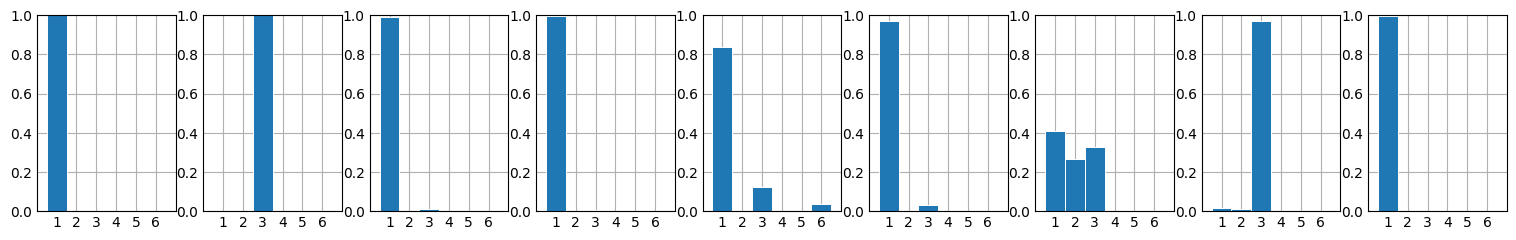

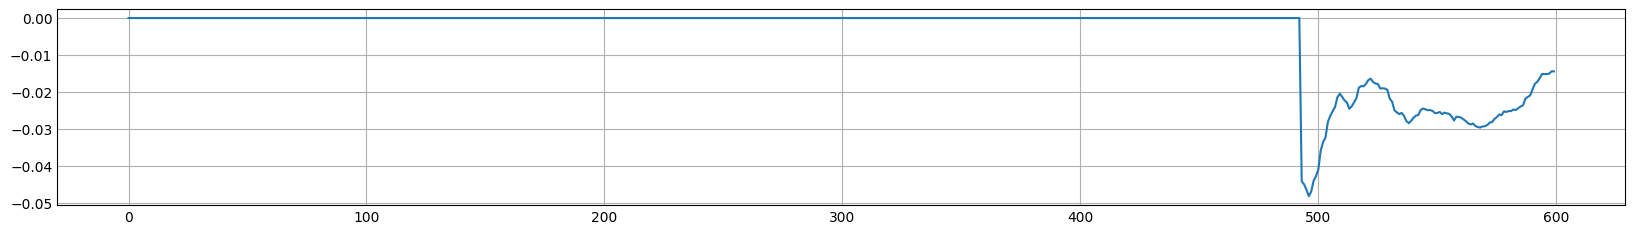

227 385
file: ../data/json/healthy/227_385_01.json pred: [0] real: 0 confusion: [0.08504653]
file: ../data/json/healthy/227_385_02.json pred: [0] real: 0 confusion: [0.00039059]
file: ../data/json/healthy/227_385_03.json pred: [0] real: 0 confusion: [0.00172752]
file: ../data/json/healthy/227_385_04.json pred: [0] real: 0 confusion: [0.00030851]
file: ../data/json/healthy/227_385_05.json pred: [0] real: 0 confusion: [7.092953e-05]
file: ../data/json/healthy/227_385_06.json pred: [0] real: 0 confusion: [0.00152749]
file: ../data/json/healthy/227_385_07.json pred: [0] real: 0 confusion: [0.00022751]
file: ../data/json/healthy/227_385_08.json pred: [0] real: 0 confusion: [0.00029361]
file: ../data/json/healthy/227_385_09.json pred: [0] real: 0 confusion: [0.00089353]


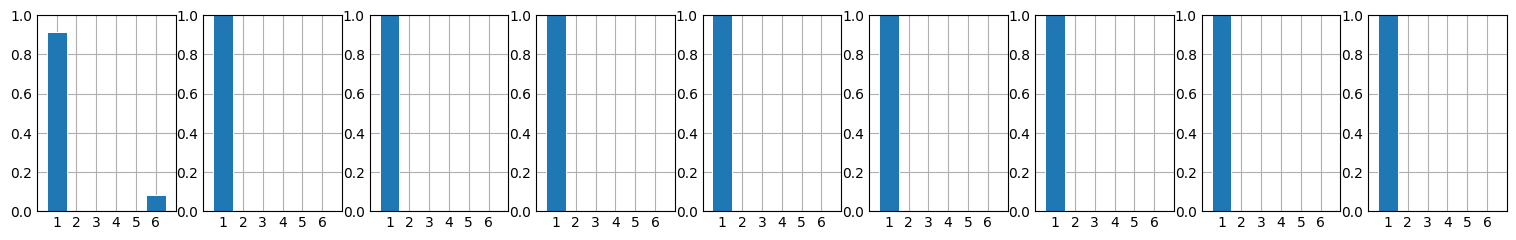

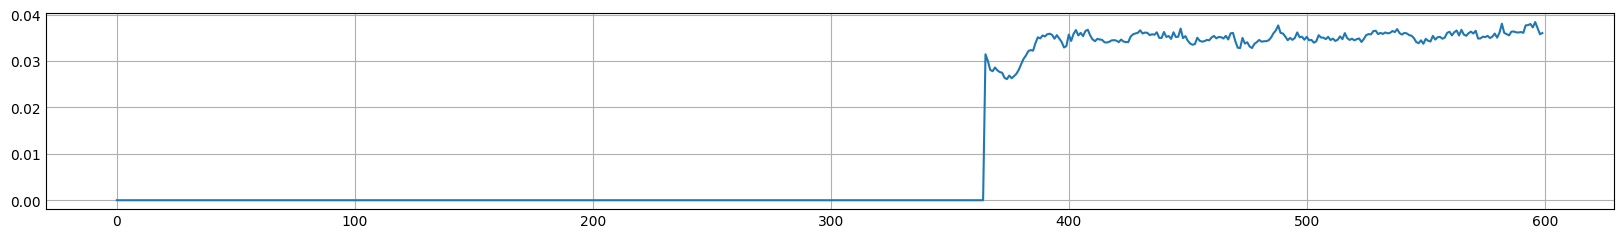

228 386
file: ../data/json/healthy/228_386_01.json pred: [0] real: 0 confusion: [0.02429765]
file: ../data/json/healthy/228_386_02.json pred: [0] real: 0 confusion: [0.00036192]
file: ../data/json/healthy/228_386_03.json pred: [4] real: 0 confusion: [0.00471836]
file: ../data/json/healthy/228_386_04.json pred: [0] real: 0 confusion: [0.24086332]
file: ../data/json/healthy/228_386_05.json pred: [0] real: 0 confusion: [0.1680376]
file: ../data/json/healthy/228_386_06.json pred: [0] real: 0 confusion: [0.00892472]
file: ../data/json/healthy/228_386_07.json pred: [0] real: 0 confusion: [0.00218749]
file: ../data/json/healthy/228_386_08.json pred: [0] real: 0 confusion: [0.00119287]
file: ../data/json/healthy/228_386_09.json pred: [0] real: 0 confusion: [0.16674072]


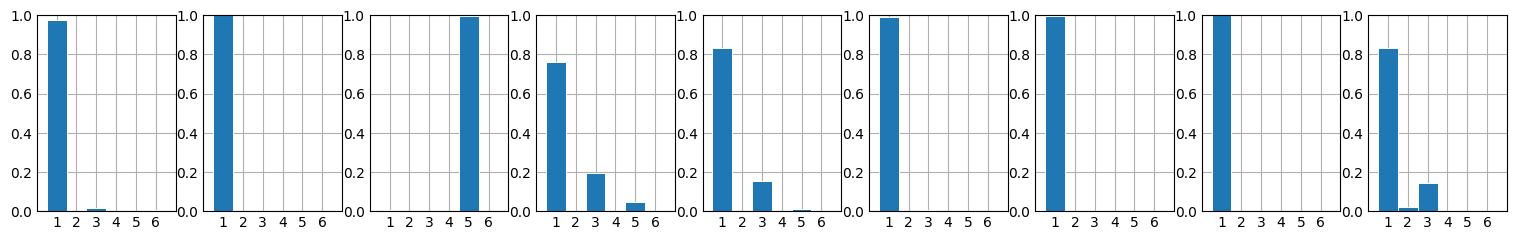

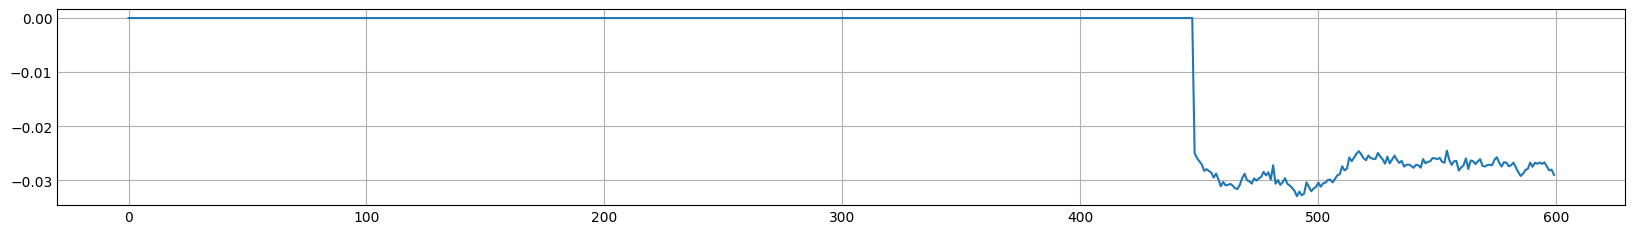

229 387
file: ../data/json/healthy/229_387_01.json pred: [0] real: 0 confusion: [0.12228906]
file: ../data/json/healthy/229_387_02.json pred: [0] real: 0 confusion: [0.03210795]
file: ../data/json/healthy/229_387_03.json pred: [5] real: 0 confusion: [3.0398369e-06]
file: ../data/json/healthy/229_387_04.json pred: [5] real: 0 confusion: [0.00161231]
file: ../data/json/healthy/229_387_05.json pred: [2] real: 0 confusion: [0.51605564]
file: ../data/json/healthy/229_387_06.json pred: [5] real: 0 confusion: [0.01268739]
file: ../data/json/healthy/229_387_07.json pred: [5] real: 0 confusion: [0.49483716]
file: ../data/json/healthy/229_387_08.json pred: [2] real: 0 confusion: [0.10356057]
file: ../data/json/healthy/229_387_09.json pred: [1] real: 0 confusion: [0.04014218]


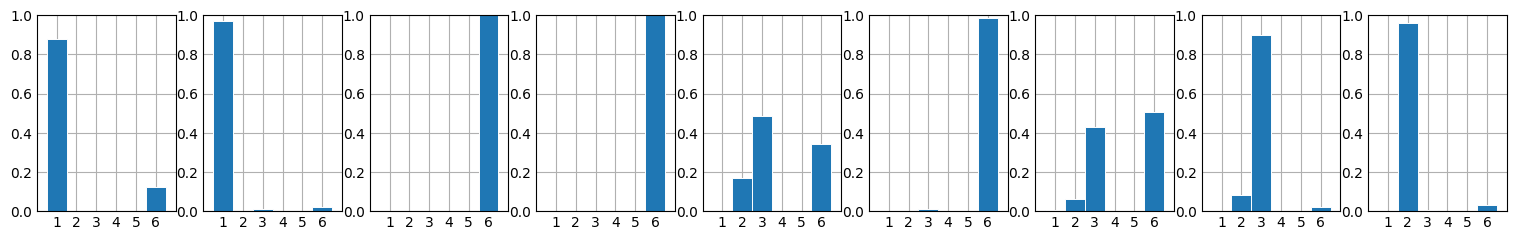

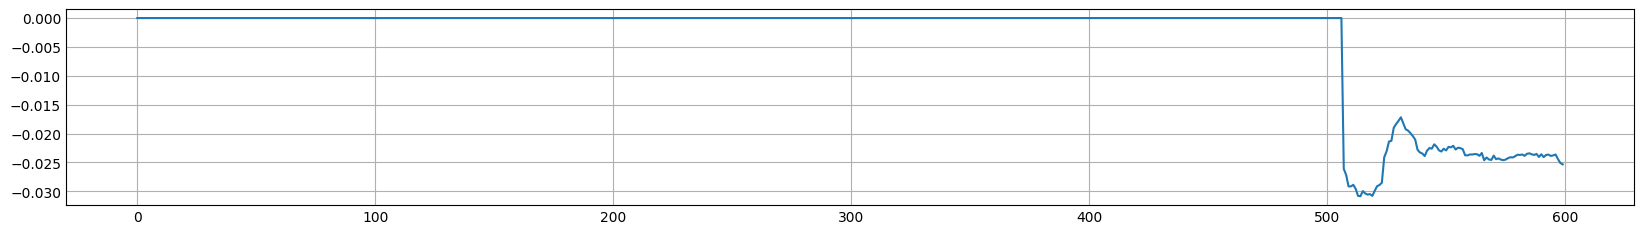

230 388
file: ../data/json/healthy/230_388_01.json pred: [4] real: 0 confusion: [0.36088413]
file: ../data/json/healthy/230_388_02.json pred: [0] real: 0 confusion: [0.10144138]
file: ../data/json/healthy/230_388_03.json pred: [4] real: 0 confusion: [0.00140673]
file: ../data/json/healthy/230_388_04.json pred: [2] real: 0 confusion: [0.1338293]
file: ../data/json/healthy/230_388_05.json pred: [2] real: 0 confusion: [0.3518322]
file: ../data/json/healthy/230_388_06.json pred: [0] real: 0 confusion: [0.01882118]
file: ../data/json/healthy/230_388_07.json pred: [0] real: 0 confusion: [0.09823787]
file: ../data/json/healthy/230_388_08.json pred: [0] real: 0 confusion: [0.00026375]
file: ../data/json/healthy/230_388_09.json pred: [0] real: 0 confusion: [0.27503031]


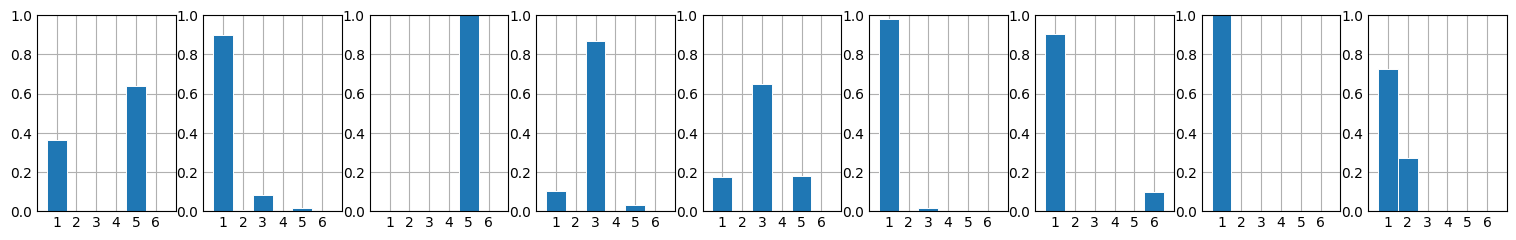

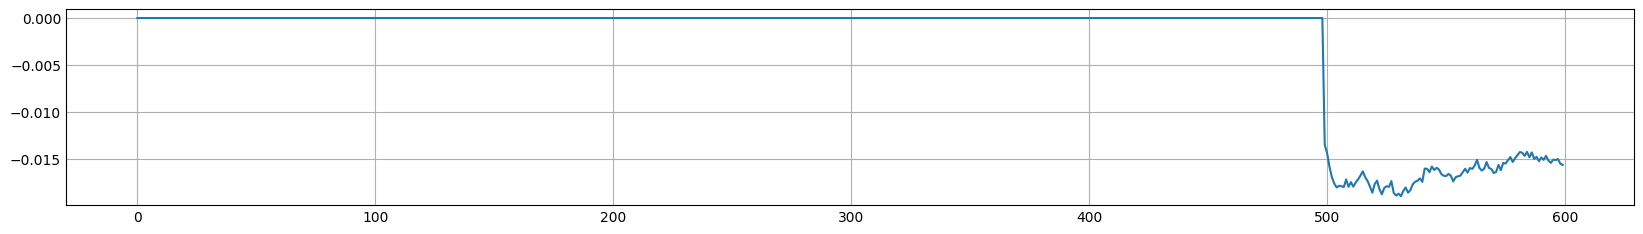

231 389
file: ../data/json/healthy/231_389_01.json pred: [0] real: 0 confusion: [0.00066549]
file: ../data/json/healthy/231_389_02.json pred: [0] real: 0 confusion: [0.00048375]
file: ../data/json/healthy/231_389_03.json pred: [0] real: 0 confusion: [0.00099212]
file: ../data/json/healthy/231_389_04.json pred: [5] real: 0 confusion: [0.06014103]
file: ../data/json/healthy/231_389_05.json pred: [0] real: 0 confusion: [0.06981093]
file: ../data/json/healthy/231_389_06.json pred: [3] real: 0 confusion: [0.1117422]
file: ../data/json/healthy/231_389_07.json pred: [0] real: 0 confusion: [0.1836214]
file: ../data/json/healthy/231_389_08.json pred: [0] real: 0 confusion: [0.17373401]
file: ../data/json/healthy/231_389_09.json pred: [0] real: 0 confusion: [0.03809577]


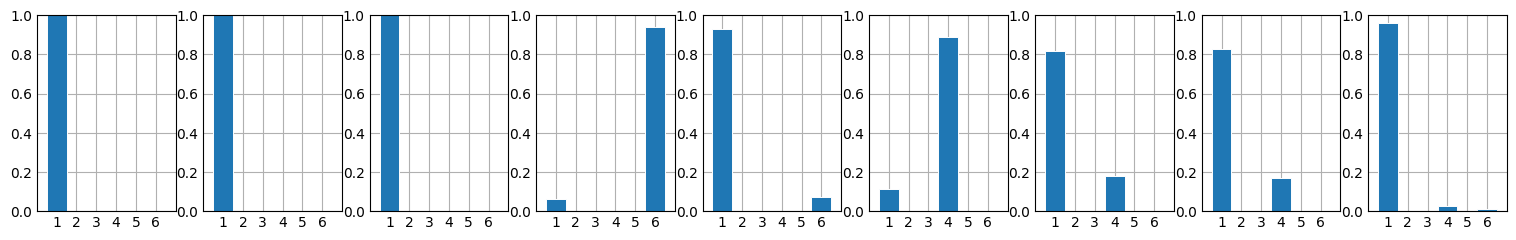

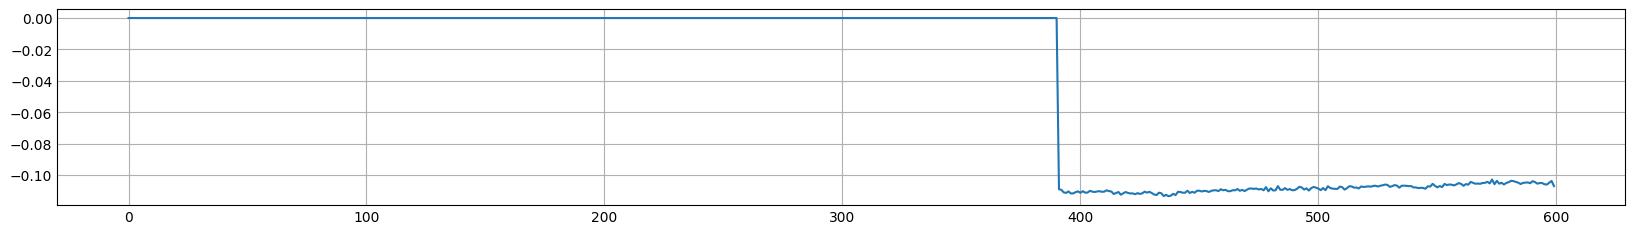

232 390
file: ../data/json/healthy/232_390_01.json pred: [0] real: 0 confusion: [3.6239624e-05]
file: ../data/json/healthy/232_390_02.json pred: [0] real: 0 confusion: [8.940697e-07]
file: ../data/json/healthy/232_390_03.json pred: [0] real: 0 confusion: [2.9087067e-05]
file: ../data/json/healthy/232_390_04.json pred: [0] real: 0 confusion: [6.556511e-07]
file: ../data/json/healthy/232_390_05.json pred: [0] real: 0 confusion: [1.0848045e-05]
file: ../data/json/healthy/232_390_06.json pred: [0] real: 0 confusion: [5.7816505e-06]
file: ../data/json/healthy/232_390_07.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/232_390_08.json pred: [0] real: 0 confusion: [1.1920929e-07]
file: ../data/json/healthy/232_390_09.json pred: [0] real: 0 confusion: [0.00085628]


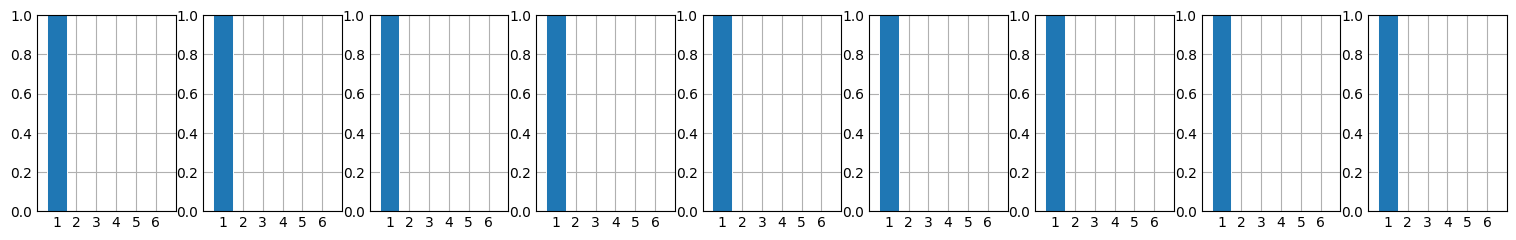

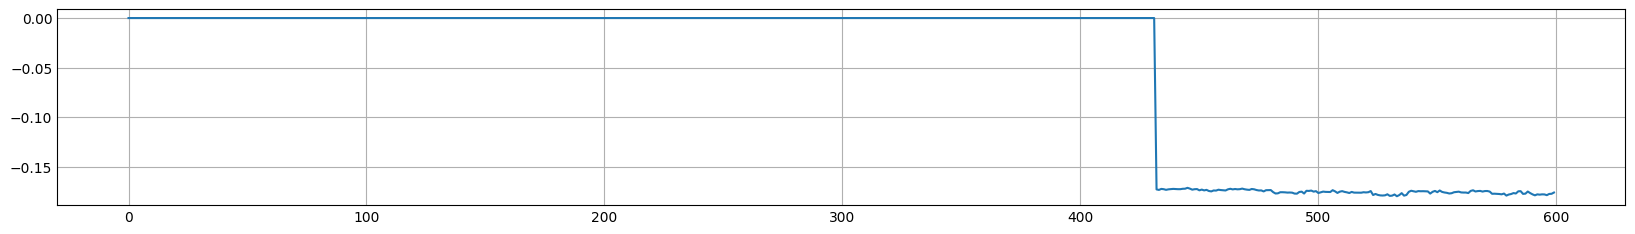

233 391
file: ../data/json/healthy/233_391_01.json pred: [0] real: 0 confusion: [0.00678688]
file: ../data/json/healthy/233_391_02.json pred: [2] real: 0 confusion: [0.15120286]
file: ../data/json/healthy/233_391_03.json pred: [2] real: 0 confusion: [0.01262027]
file: ../data/json/healthy/233_391_04.json pred: [2] real: 0 confusion: [3.5703182e-05]
file: ../data/json/healthy/233_391_05.json pred: [0] real: 0 confusion: [0.01020765]
file: ../data/json/healthy/233_391_06.json pred: [2] real: 0 confusion: [0.01960927]
file: ../data/json/healthy/233_391_07.json pred: [0] real: 0 confusion: [4.851818e-05]
file: ../data/json/healthy/233_391_08.json pred: [2] real: 0 confusion: [0.31710333]
file: ../data/json/healthy/233_391_09.json pred: [0] real: 0 confusion: [0.06229264]


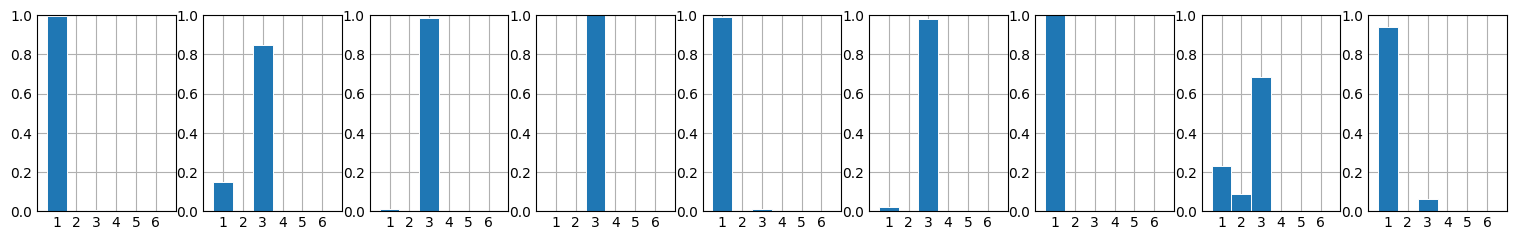

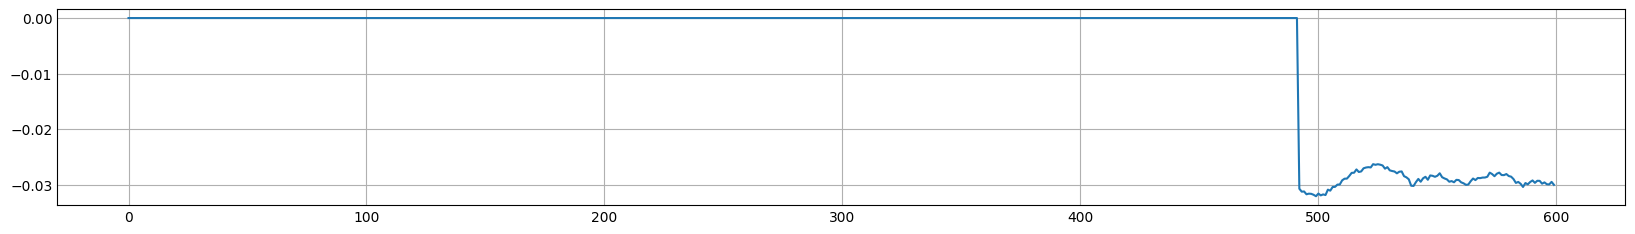

236 394
file: ../data/json/healthy/236_394_01.json pred: [0] real: 0 confusion: [0.05919433]
file: ../data/json/healthy/236_394_02.json pred: [3] real: 0 confusion: [0.00449038]
file: ../data/json/healthy/236_394_03.json pred: [2] real: 0 confusion: [0.00028884]
file: ../data/json/healthy/236_394_04.json pred: [0] real: 0 confusion: [0.00588846]
file: ../data/json/healthy/236_394_05.json pred: [0] real: 0 confusion: [0.269297]
file: ../data/json/healthy/236_394_06.json pred: [2] real: 0 confusion: [0.00018293]
file: ../data/json/healthy/236_394_07.json pred: [0] real: 0 confusion: [0.02335274]
file: ../data/json/healthy/236_394_08.json pred: [2] real: 0 confusion: [0.01695704]
file: ../data/json/healthy/236_394_09.json pred: [2] real: 0 confusion: [0.00019151]


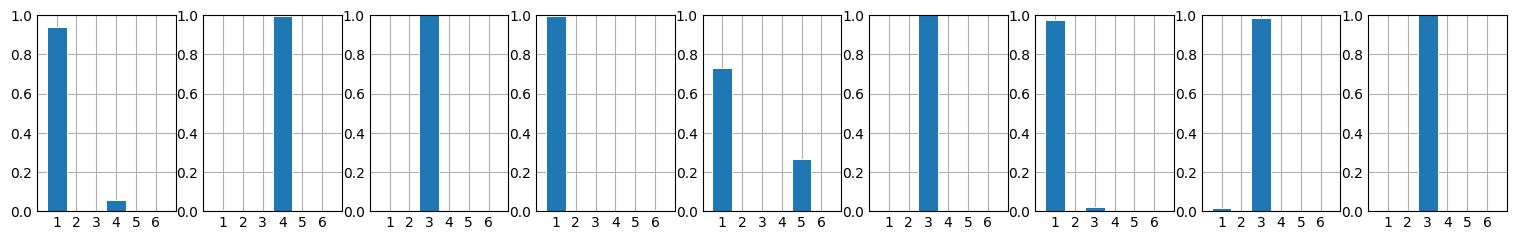

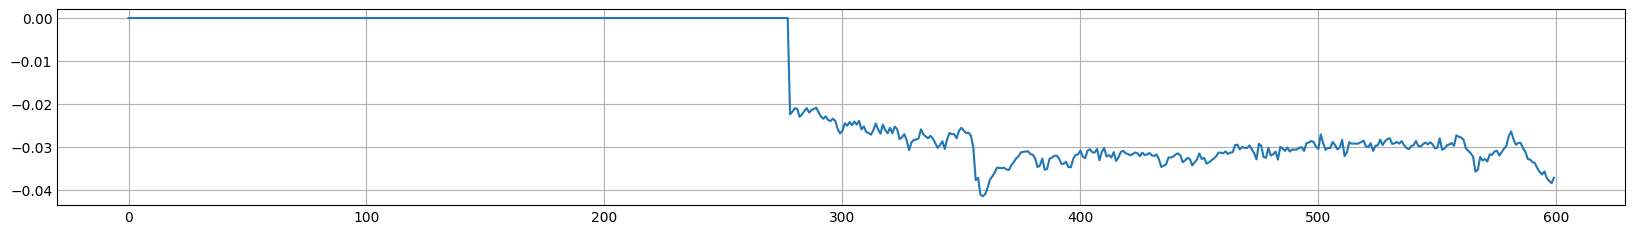

237 395
file: ../data/json/healthy/237_395_01.json pred: [2] real: 0 confusion: [0.12846047]
file: ../data/json/healthy/237_395_02.json pred: [0] real: 0 confusion: [0.06180656]
file: ../data/json/healthy/237_395_03.json pred: [0] real: 0 confusion: [0.01961082]
file: ../data/json/healthy/237_395_04.json pred: [0] real: 0 confusion: [0.18985248]
file: ../data/json/healthy/237_395_05.json pred: [0] real: 0 confusion: [0.19755626]
file: ../data/json/healthy/237_395_06.json pred: [2] real: 0 confusion: [0.04150313]
file: ../data/json/healthy/237_395_07.json pred: [2] real: 0 confusion: [0.00903261]
file: ../data/json/healthy/237_395_08.json pred: [2] real: 0 confusion: [0.07934242]
file: ../data/json/healthy/237_395_09.json pred: [0] real: 0 confusion: [0.00361031]


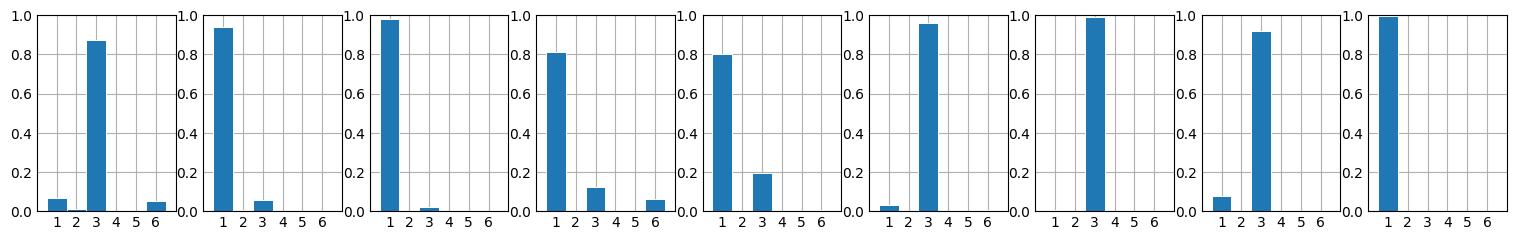

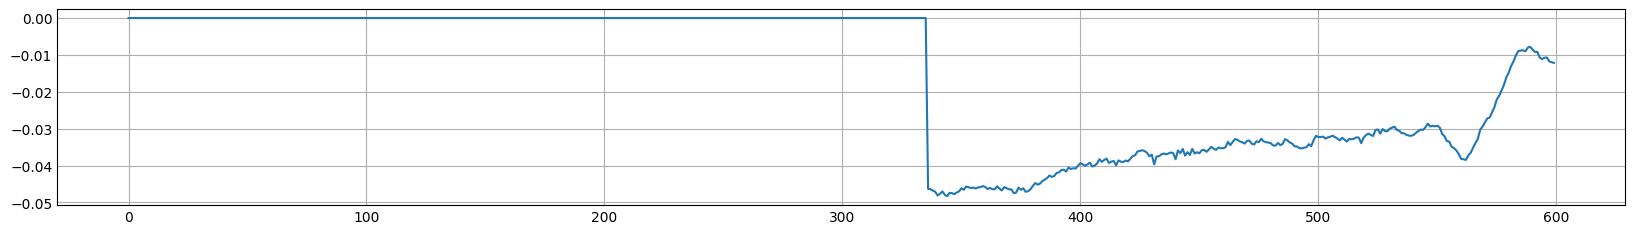

238 396
file: ../data/json/healthy/238_396_01.json pred: [5] real: 0 confusion: [0.01017123]
file: ../data/json/healthy/238_396_02.json pred: [5] real: 0 confusion: [0.00165701]
file: ../data/json/healthy/238_396_03.json pred: [5] real: 0 confusion: [0.01110446]
file: ../data/json/healthy/238_396_04.json pred: [5] real: 0 confusion: [0.24475068]
file: ../data/json/healthy/238_396_05.json pred: [1] real: 0 confusion: [0.07770538]
file: ../data/json/healthy/238_396_06.json pred: [5] real: 0 confusion: [0.00297779]
file: ../data/json/healthy/238_396_07.json pred: [5] real: 0 confusion: [0.01260328]
file: ../data/json/healthy/238_396_08.json pred: [5] real: 0 confusion: [0.28148198]
file: ../data/json/healthy/238_396_09.json pred: [2] real: 0 confusion: [0.33089852]


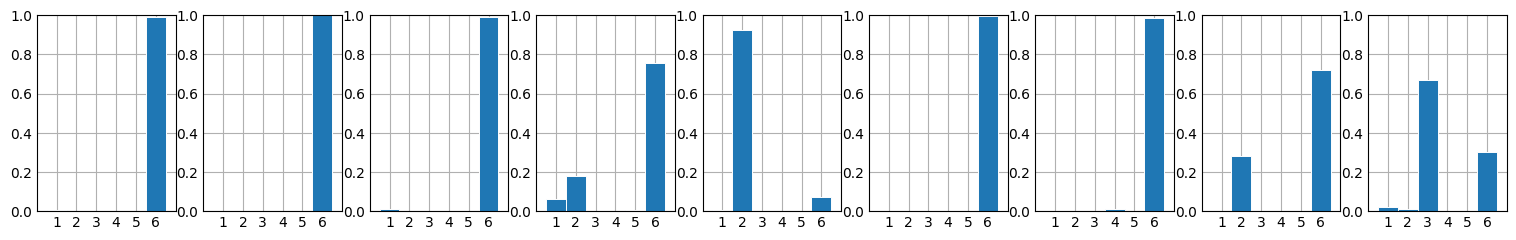

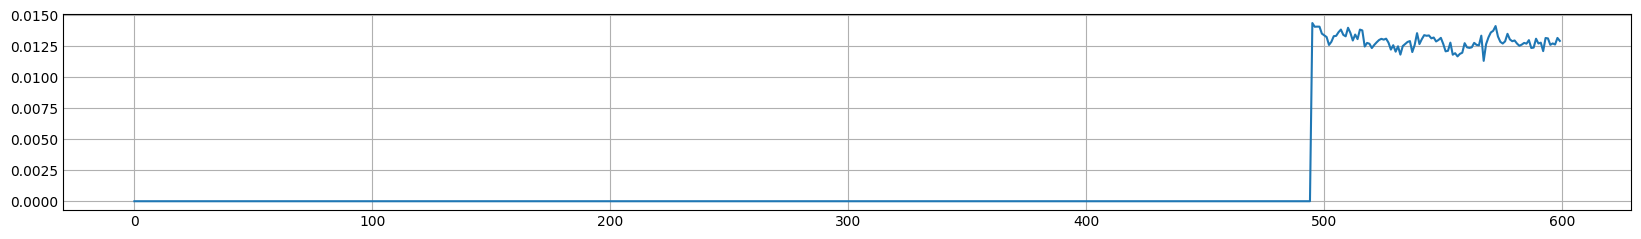

239 397
file: ../data/json/healthy/239_397_01.json pred: [0] real: 0 confusion: [3.9339066e-05]
file: ../data/json/healthy/239_397_02.json pred: [0] real: 0 confusion: [0.00040042]
file: ../data/json/healthy/239_397_03.json pred: [0] real: 0 confusion: [2.7120113e-05]
file: ../data/json/healthy/239_397_04.json pred: [0] real: 0 confusion: [0.00048935]
file: ../data/json/healthy/239_397_05.json pred: [0] real: 0 confusion: [4.5657158e-05]
file: ../data/json/healthy/239_397_06.json pred: [0] real: 0 confusion: [0.0516631]
file: ../data/json/healthy/239_397_07.json pred: [5] real: 0 confusion: [0.0114947]
file: ../data/json/healthy/239_397_08.json pred: [0] real: 0 confusion: [1.1086464e-05]
file: ../data/json/healthy/239_397_09.json pred: [0] real: 0 confusion: [5.3465366e-05]


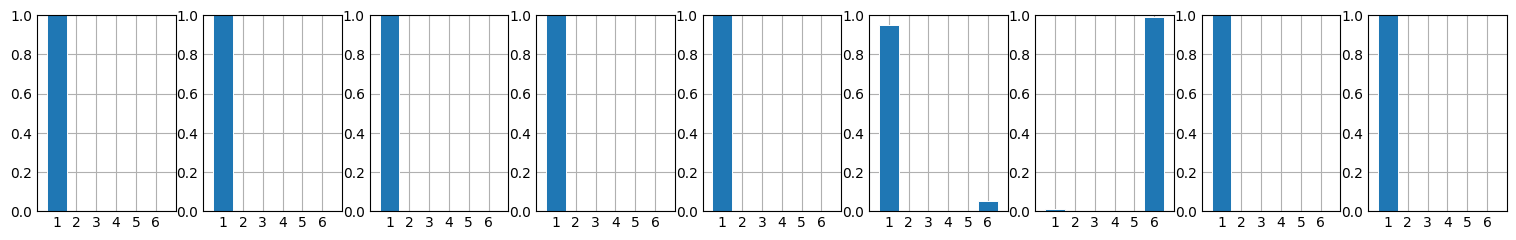

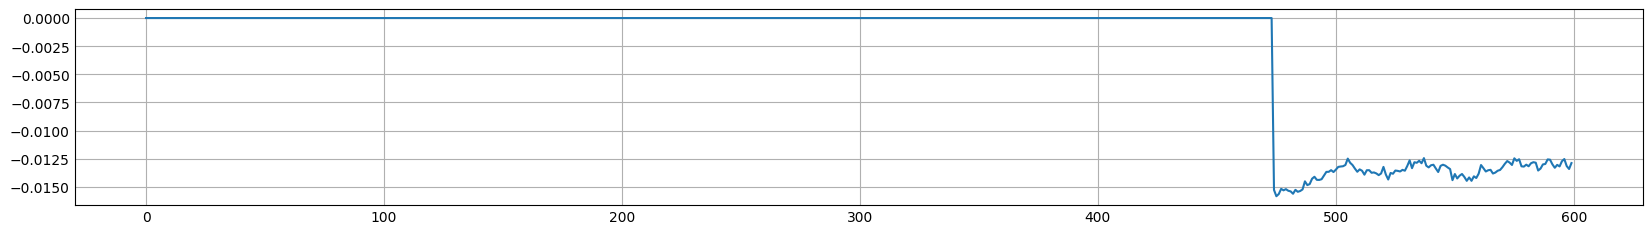

240 398
file: ../data/json/healthy/240_398_01.json pred: [0] real: 0 confusion: [1.1920929e-07]
file: ../data/json/healthy/240_398_02.json pred: [0] real: 0 confusion: [0.1020022]
file: ../data/json/healthy/240_398_03.json pred: [0] real: 0 confusion: [0.10699207]
file: ../data/json/healthy/240_398_04.json pred: [1] real: 0 confusion: [0.06265038]
file: ../data/json/healthy/240_398_05.json pred: [0] real: 0 confusion: [0.43126142]
file: ../data/json/healthy/240_398_06.json pred: [0] real: 0 confusion: [0.00941646]
file: ../data/json/healthy/240_398_07.json pred: [0] real: 0 confusion: [0.00076288]
file: ../data/json/healthy/240_398_08.json pred: [0] real: 0 confusion: [0.00378317]
file: ../data/json/healthy/240_398_09.json pred: [0] real: 0 confusion: [7.021427e-05]


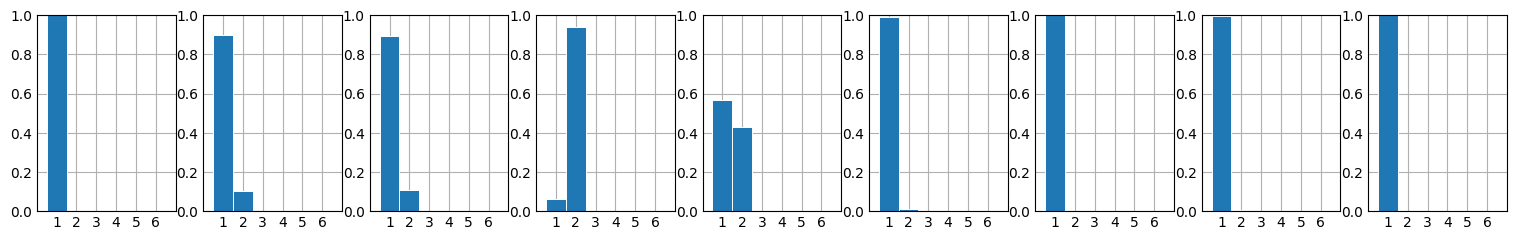

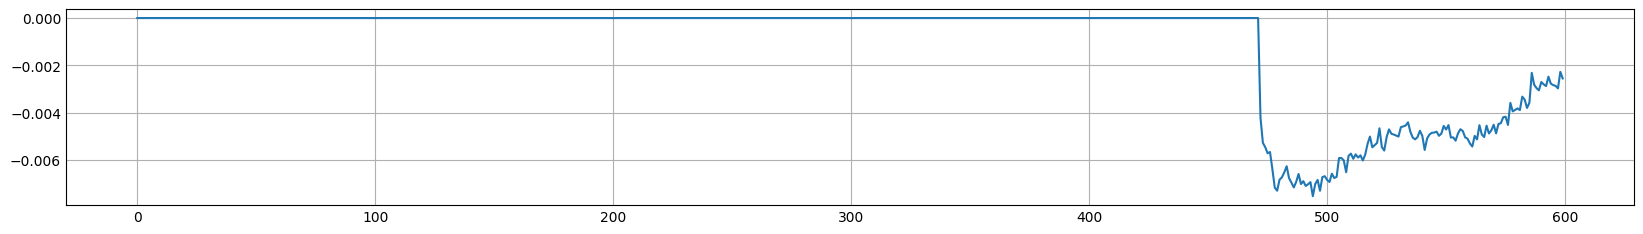

241 399
file: ../data/json/healthy/241_399_01.json pred: [0] real: 0 confusion: [1.7881393e-06]
file: ../data/json/healthy/241_399_02.json pred: [0] real: 0 confusion: [7.390976e-06]
file: ../data/json/healthy/241_399_03.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/241_399_04.json pred: [0] real: 0 confusion: [5.9604645e-08]
file: ../data/json/healthy/241_399_05.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/241_399_06.json pred: [0] real: 0 confusion: [5.543232e-06]
file: ../data/json/healthy/241_399_07.json pred: [0] real: 0 confusion: [2.3841858e-07]
file: ../data/json/healthy/241_399_08.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/241_399_09.json pred: [0] real: 0 confusion: [0.]


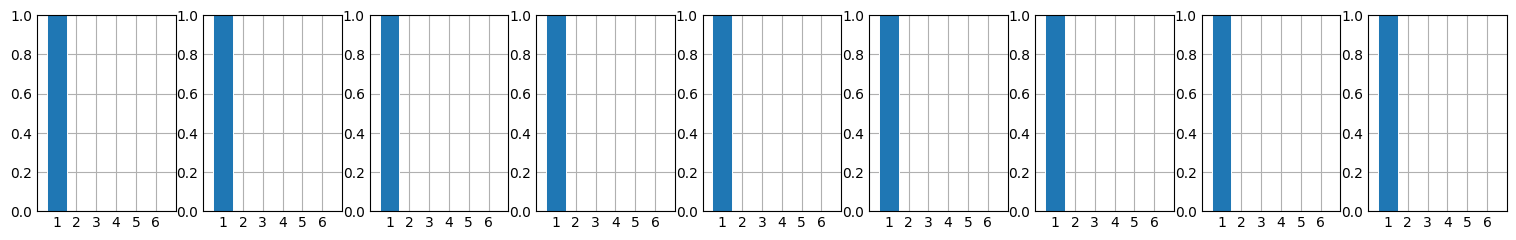

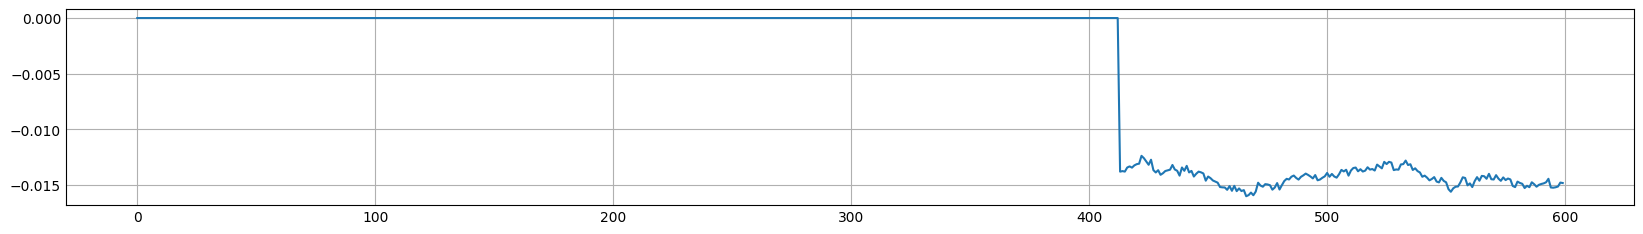

242 400
file: ../data/json/healthy/242_400_01.json pred: [2] real: 0 confusion: [0.02044833]
file: ../data/json/healthy/242_400_02.json pred: [2] real: 0 confusion: [0.0001238]
file: ../data/json/healthy/242_400_03.json pred: [2] real: 0 confusion: [3.540516e-05]
file: ../data/json/healthy/242_400_04.json pred: [2] real: 0 confusion: [2.0384789e-05]
file: ../data/json/healthy/242_400_05.json pred: [2] real: 0 confusion: [7.748604e-07]
file: ../data/json/healthy/242_400_06.json pred: [2] real: 0 confusion: [1.3232231e-05]
file: ../data/json/healthy/242_400_07.json pred: [2] real: 0 confusion: [3.33786e-06]
file: ../data/json/healthy/242_400_08.json pred: [2] real: 0 confusion: [0.03073102]
file: ../data/json/healthy/242_400_09.json pred: [0] real: 0 confusion: [0.0021444]


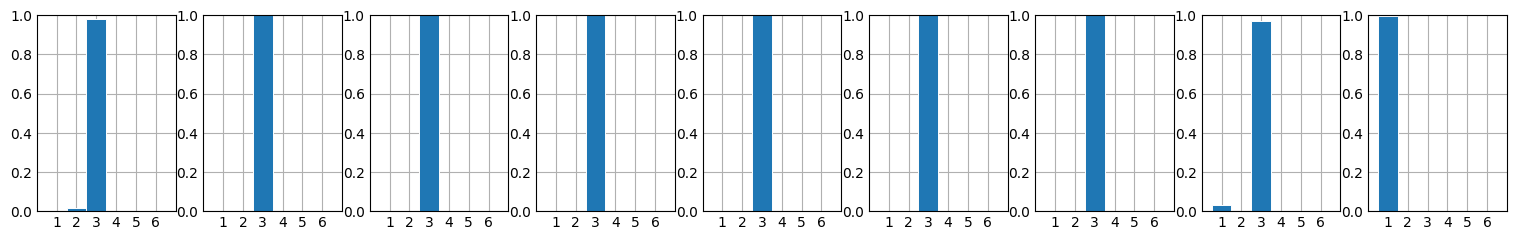

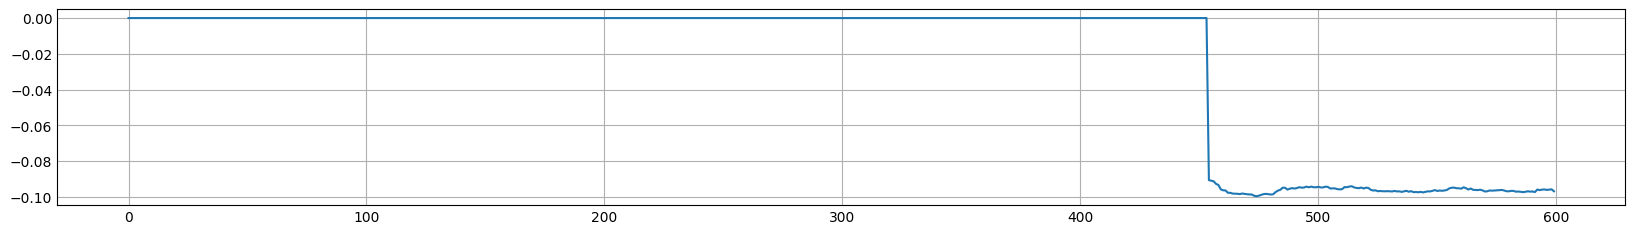

243 401
file: ../data/json/healthy/243_401_01.json pred: [1] real: 0 confusion: [0.00029176]
file: ../data/json/healthy/243_401_02.json pred: [1] real: 0 confusion: [0.0020234]
file: ../data/json/healthy/243_401_03.json pred: [3] real: 0 confusion: [0.11107558]
file: ../data/json/healthy/243_401_04.json pred: [1] real: 0 confusion: [0.5461198]
file: ../data/json/healthy/243_401_05.json pred: [1] real: 0 confusion: [0.14218748]
file: ../data/json/healthy/243_401_06.json pred: [0] real: 0 confusion: [0.14685124]
file: ../data/json/healthy/243_401_07.json pred: [1] real: 0 confusion: [0.21676654]
file: ../data/json/healthy/243_401_08.json pred: [1] real: 0 confusion: [0.54071915]
file: ../data/json/healthy/243_401_09.json pred: [0] real: 0 confusion: [0.00662011]


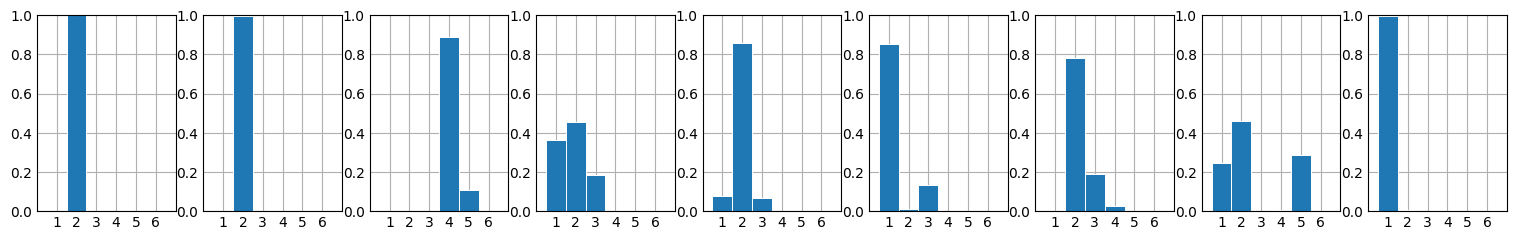

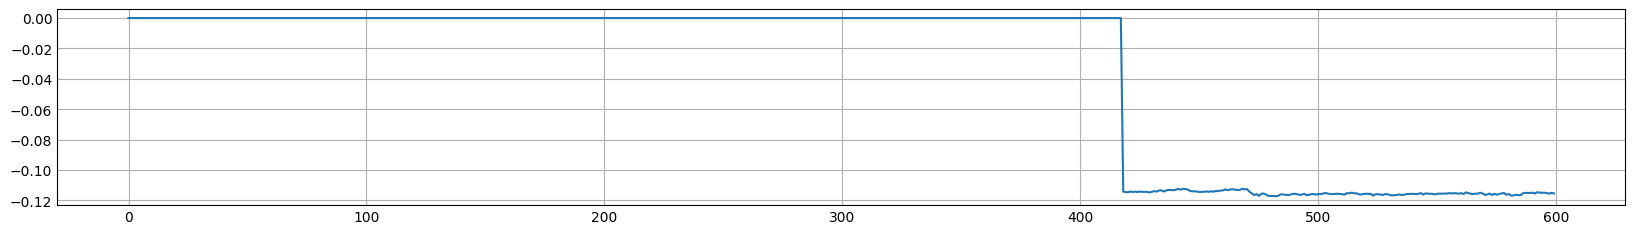

244 402
file: ../data/json/healthy/244_402_01.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/244_402_02.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/244_402_03.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/244_402_04.json pred: [0] real: 0 confusion: [0.0002045]
file: ../data/json/healthy/244_402_05.json pred: [0] real: 0 confusion: [0.00126141]
file: ../data/json/healthy/244_402_06.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/244_402_07.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/244_402_08.json pred: [0] real: 0 confusion: [0.00040895]
file: ../data/json/healthy/244_402_09.json pred: [0] real: 0 confusion: [1.0728836e-06]


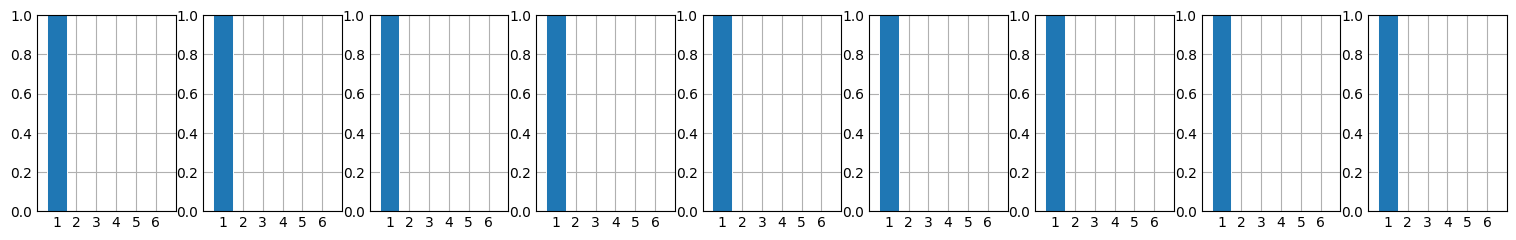

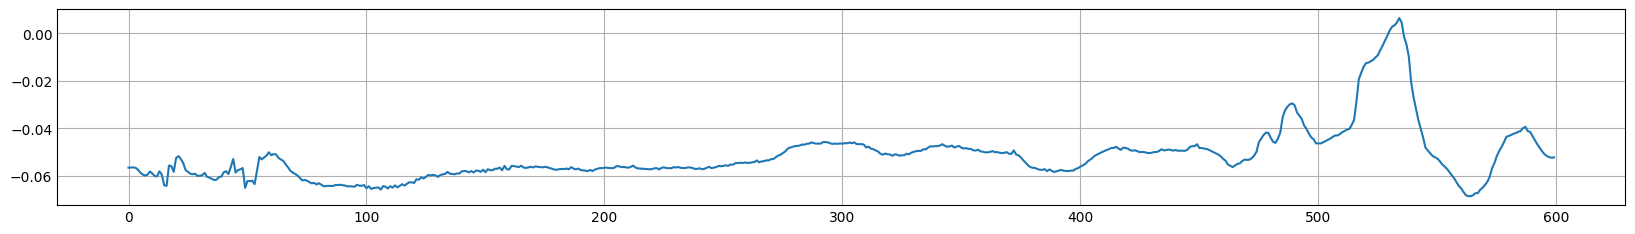

245 403
file: ../data/json/healthy/245_403_01.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/245_403_02.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/245_403_03.json pred: [0] real: 0 confusion: [3.7550926e-05]
file: ../data/json/healthy/245_403_04.json pred: [0] real: 0 confusion: [5.364418e-07]
file: ../data/json/healthy/245_403_05.json pred: [0] real: 0 confusion: [0.04096043]
file: ../data/json/healthy/245_403_06.json pred: [0] real: 0 confusion: [0.00133014]
file: ../data/json/healthy/245_403_07.json pred: [0] real: 0 confusion: [0.00735611]
file: ../data/json/healthy/245_403_08.json pred: [2] real: 0 confusion: [0.00446153]
file: ../data/json/healthy/245_403_09.json pred: [2] real: 0 confusion: [0.00083208]


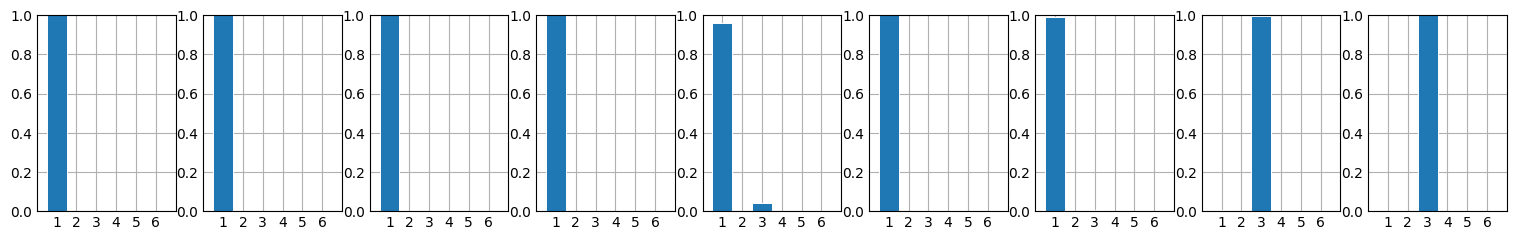

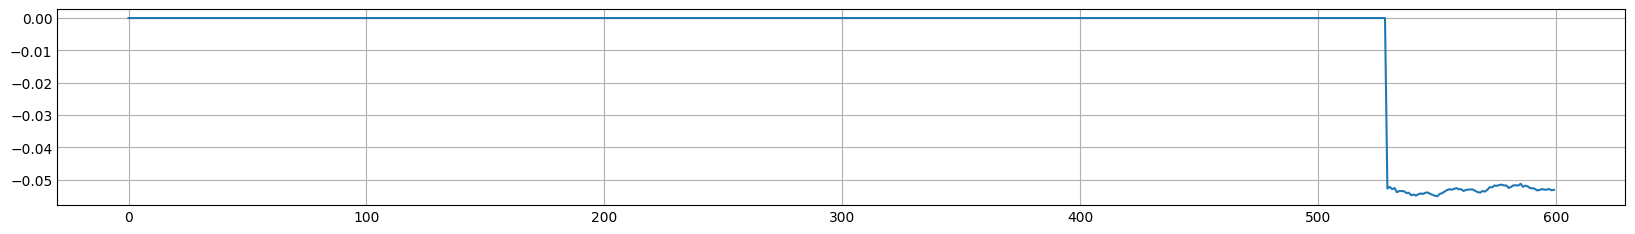

246 404
file: ../data/json/healthy/246_404_01.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/246_404_02.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/246_404_03.json pred: [0] real: 0 confusion: [8.34465e-07]
file: ../data/json/healthy/246_404_04.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/246_404_05.json pred: [0] real: 0 confusion: [5.9604645e-08]
file: ../data/json/healthy/246_404_06.json pred: [0] real: 0 confusion: [8.380413e-05]
file: ../data/json/healthy/246_404_07.json pred: [0] real: 0 confusion: [3.2901764e-05]
file: ../data/json/healthy/246_404_08.json pred: [0] real: 0 confusion: [5.9604645e-08]
file: ../data/json/healthy/246_404_09.json pred: [2] real: 0 confusion: [0.24686033]


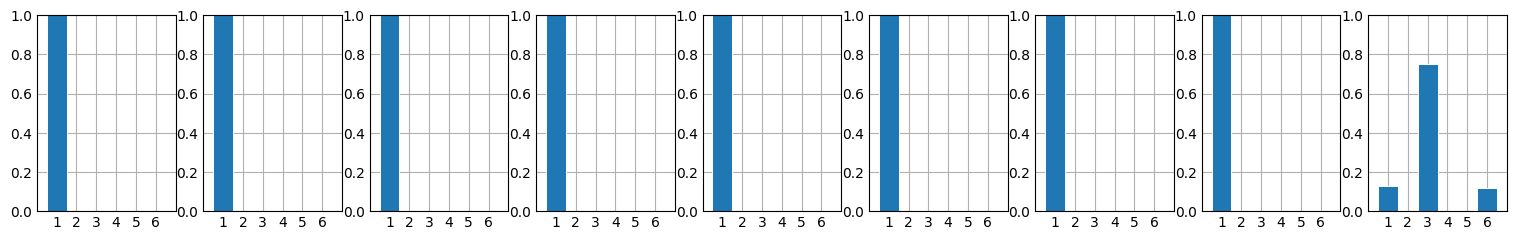

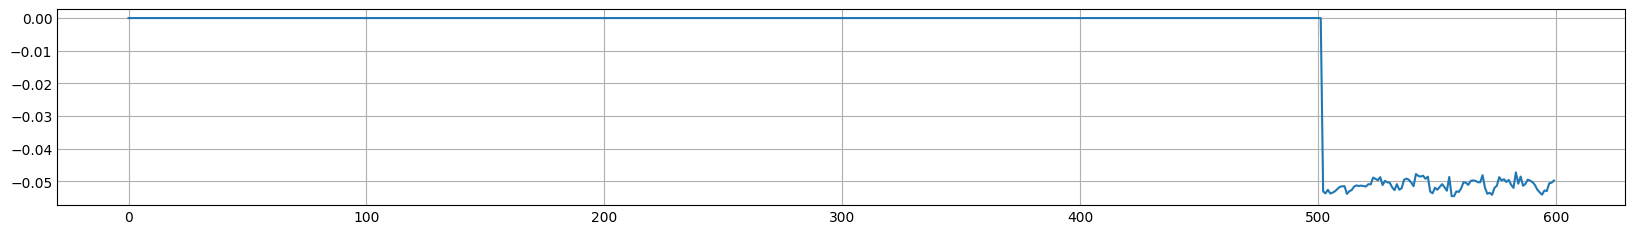

247 405
File ../data/json/healthy/247_405_01.json is missing
File ../data/json/healthy/247_405_02.json is missing
File ../data/json/healthy/247_405_03.json is missing
File ../data/json/healthy/247_405_04.json is missing
File ../data/json/healthy/247_405_05.json is missing
File ../data/json/healthy/247_405_06.json is missing
File ../data/json/healthy/247_405_07.json is missing
File ../data/json/healthy/247_405_08.json is missing
file: ../data/json/healthy/247_405_09.json pred: [0] real: 0 confusion: [1.1920929e-07]


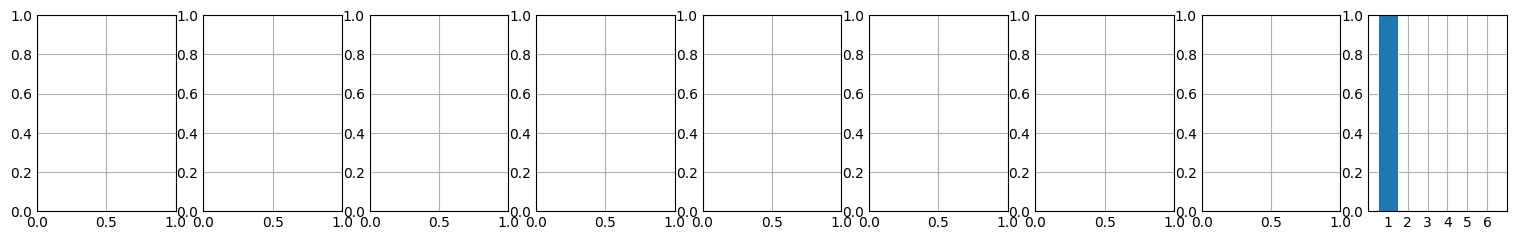

248 406
file: ../data/json/healthy/248_406_01.json pred: [0] real: 0 confusion: [0.00155193]
file: ../data/json/healthy/248_406_02.json pred: [0] real: 0 confusion: [0.03244412]
file: ../data/json/healthy/248_406_03.json pred: [5] real: 0 confusion: [0.00012517]
file: ../data/json/healthy/248_406_04.json pred: [0] real: 0 confusion: [0.10850787]
file: ../data/json/healthy/248_406_05.json pred: [0] real: 0 confusion: [0.42516118]
file: ../data/json/healthy/248_406_06.json pred: [3] real: 0 confusion: [0.13304758]
file: ../data/json/healthy/248_406_07.json pred: [4] real: 0 confusion: [0.39060205]
file: ../data/json/healthy/248_406_08.json pred: [3] real: 0 confusion: [0.]
file: ../data/json/healthy/248_406_09.json pred: [3] real: 0 confusion: [5.9604645e-07]


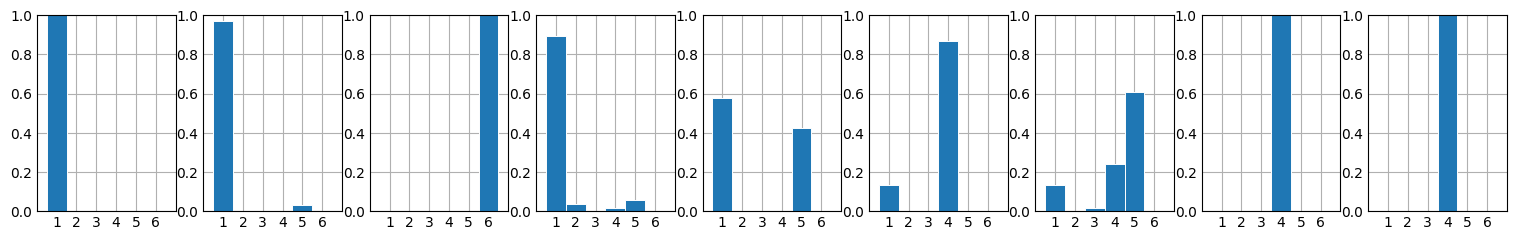

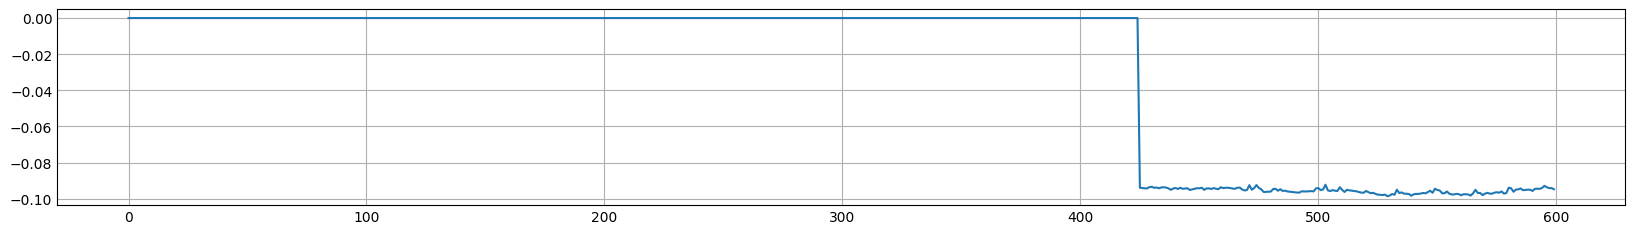

249 407
file: ../data/json/healthy/249_407_01.json pred: [2] real: 0 confusion: [0.00021642]
file: ../data/json/healthy/249_407_02.json pred: [2] real: 0 confusion: [0.01228219]
file: ../data/json/healthy/249_407_03.json pred: [2] real: 0 confusion: [0.01021171]
file: ../data/json/healthy/249_407_04.json pred: [2] real: 0 confusion: [6.866455e-05]
file: ../data/json/healthy/249_407_05.json pred: [2] real: 0 confusion: [7.688999e-05]
file: ../data/json/healthy/249_407_06.json pred: [2] real: 0 confusion: [2.4914742e-05]
file: ../data/json/healthy/249_407_07.json pred: [2] real: 0 confusion: [4.863739e-05]
file: ../data/json/healthy/249_407_08.json pred: [2] real: 0 confusion: [1.66893e-05]
file: ../data/json/healthy/249_407_09.json pred: [2] real: 0 confusion: [3.9935112e-05]


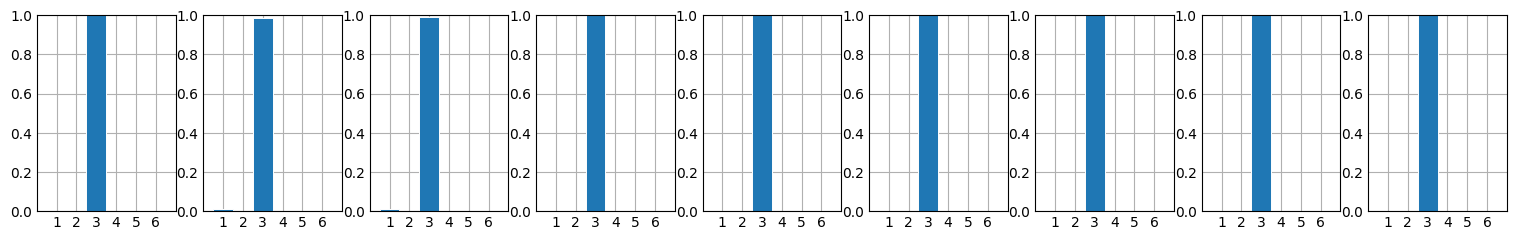

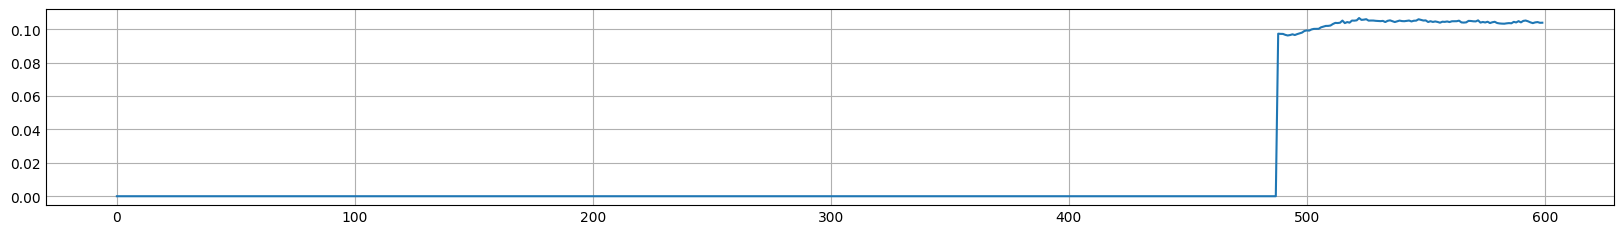

251 409
file: ../data/json/healthy/251_409_01.json pred: [2] real: 0 confusion: [0.2188651]
file: ../data/json/healthy/251_409_02.json pred: [0] real: 0 confusion: [0.00814468]
file: ../data/json/healthy/251_409_03.json pred: [0] real: 0 confusion: [0.00023991]
file: ../data/json/healthy/251_409_04.json pred: [0] real: 0 confusion: [6.6280365e-05]
file: ../data/json/healthy/251_409_05.json pred: [0] real: 0 confusion: [2.3841858e-07]
file: ../data/json/healthy/251_409_06.json pred: [0] real: 0 confusion: [3.4451485e-05]
file: ../data/json/healthy/251_409_07.json pred: [0] real: 0 confusion: [4.7683716e-06]
file: ../data/json/healthy/251_409_08.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/251_409_09.json pred: [0] real: 0 confusion: [8.940697e-07]


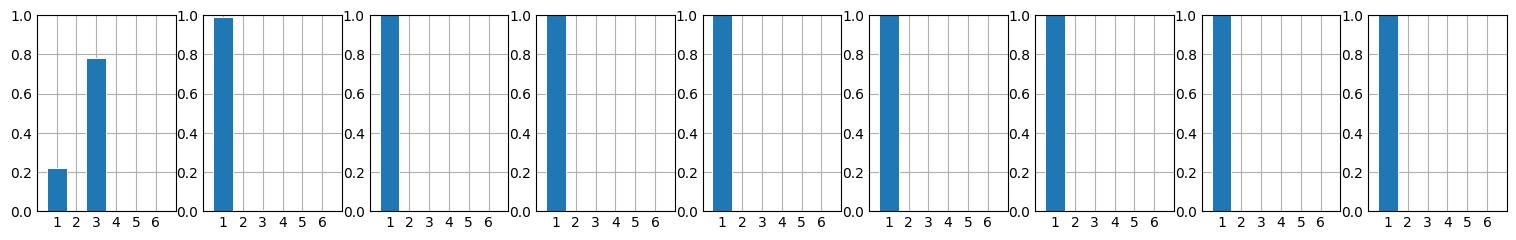

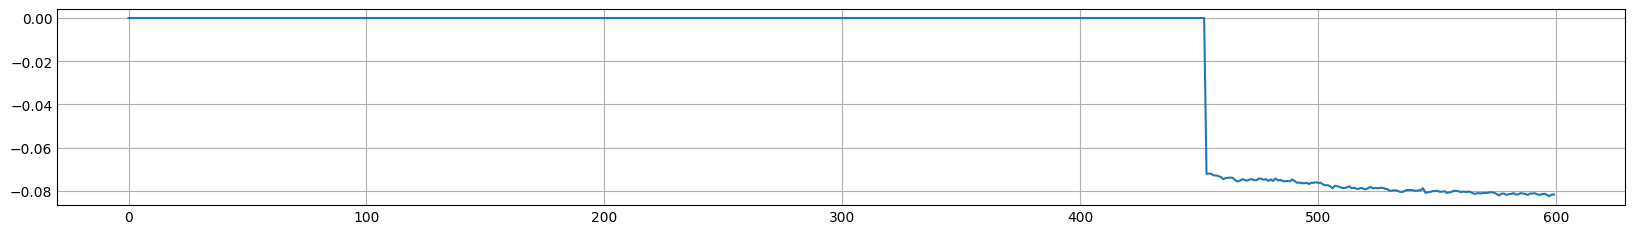

252 410
file: ../data/json/healthy/252_410_01.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/252_410_02.json pred: [0] real: 0 confusion: [1.0728836e-06]
file: ../data/json/healthy/252_410_03.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/252_410_04.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/252_410_05.json pred: [0] real: 0 confusion: [3.5762787e-07]
file: ../data/json/healthy/252_410_06.json pred: [0] real: 0 confusion: [3.5762787e-07]
file: ../data/json/healthy/252_410_07.json pred: [0] real: 0 confusion: [2.503395e-06]
file: ../data/json/healthy/252_410_08.json pred: [0] real: 0 confusion: [0.2079354]
file: ../data/json/healthy/252_410_09.json pred: [1] real: 0 confusion: [0.15324628]


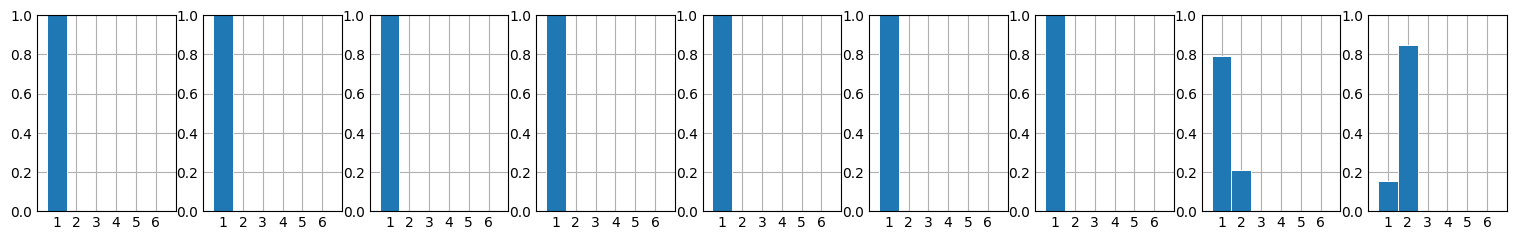

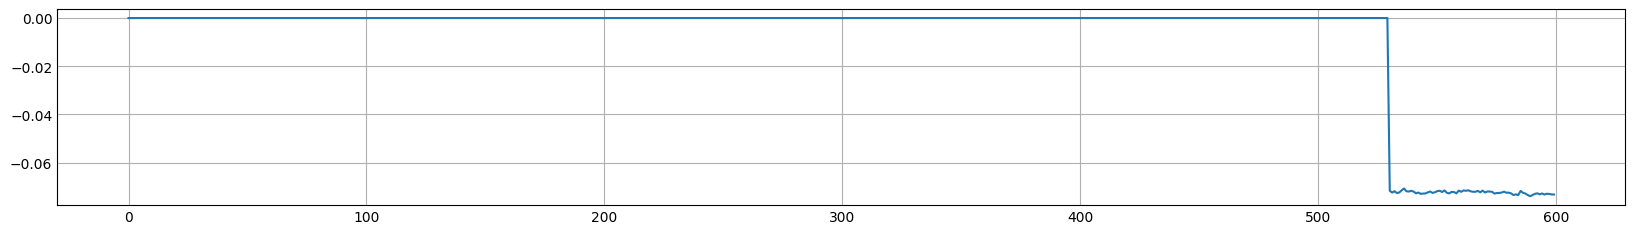

253 411
file: ../data/json/healthy/253_411_01.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/253_411_02.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/253_411_03.json pred: [0] real: 0 confusion: [0.00176758]
file: ../data/json/healthy/253_411_04.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/253_411_05.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/253_411_06.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/253_411_07.json pred: [0] real: 0 confusion: [0.]
file: ../data/json/healthy/253_411_08.json pred: [0] real: 0 confusion: [7.748604e-07]
file: ../data/json/healthy/253_411_09.json pred: [0] real: 0 confusion: [0.]


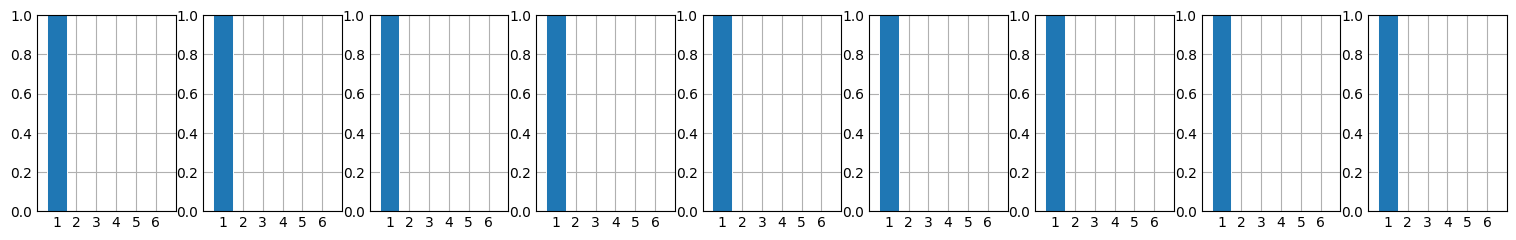

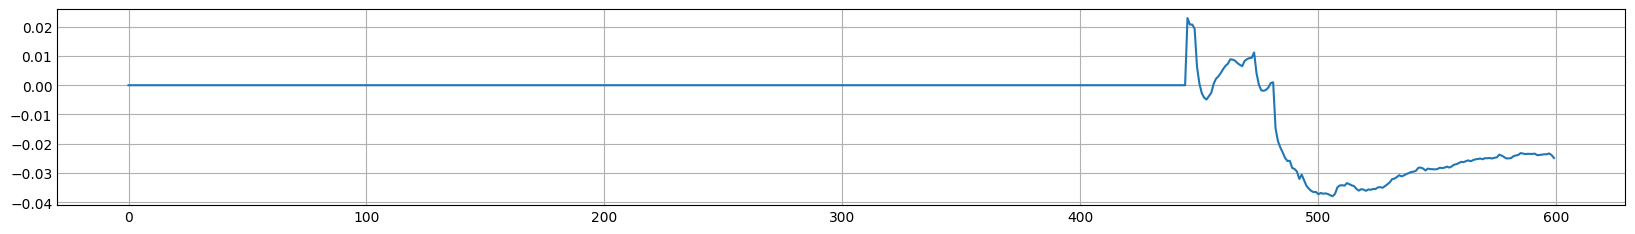

254 412
file: ../data/json/healthy/254_412_01.json pred: [1] real: 0 confusion: [0.39376444]
file: ../data/json/healthy/254_412_02.json pred: [1] real: 0 confusion: [0.00322449]
file: ../data/json/healthy/254_412_03.json pred: [1] real: 0 confusion: [0.10145408]
file: ../data/json/healthy/254_412_04.json pred: [1] real: 0 confusion: [0.42023873]
file: ../data/json/healthy/254_412_05.json pred: [0] real: 0 confusion: [0.019813]
file: ../data/json/healthy/254_412_06.json pred: [1] real: 0 confusion: [0.00215769]
file: ../data/json/healthy/254_412_07.json pred: [0] real: 0 confusion: [0.00889438]
file: ../data/json/healthy/254_412_08.json pred: [1] real: 0 confusion: [0.51552516]
file: ../data/json/healthy/254_412_09.json pred: [0] real: 0 confusion: [0.32749087]


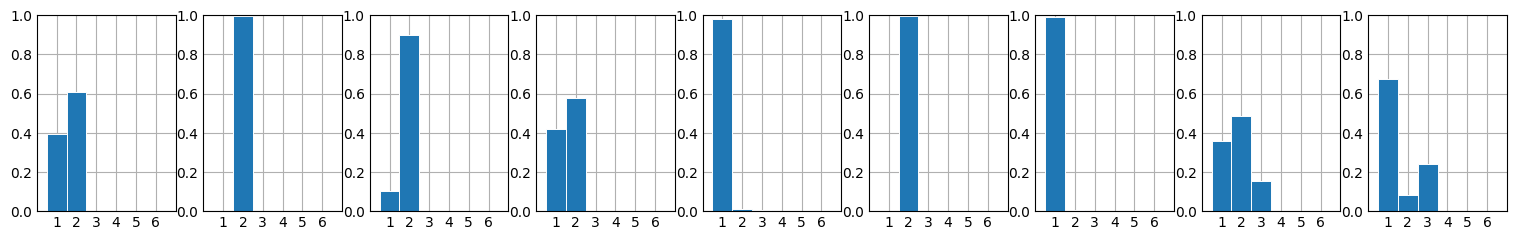

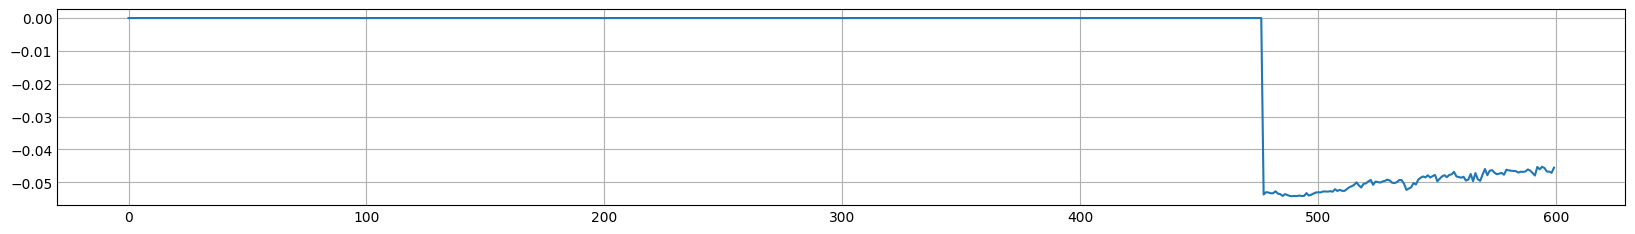

255 413
file: ../data/json/healthy/255_413_01.json pred: [1] real: 0 confusion: [0.04831815]
file: ../data/json/healthy/255_413_02.json pred: [1] real: 0 confusion: [0.19883722]
file: ../data/json/healthy/255_413_03.json pred: [1] real: 0 confusion: [0.47881424]
file: ../data/json/healthy/255_413_04.json pred: [1] real: 0 confusion: [0.02826738]
file: ../data/json/healthy/255_413_05.json pred: [1] real: 0 confusion: [0.12360871]
file: ../data/json/healthy/255_413_06.json pred: [2] real: 0 confusion: [0.5519508]
file: ../data/json/healthy/255_413_07.json pred: [0] real: 0 confusion: [0.37855822]
file: ../data/json/healthy/255_413_08.json pred: [2] real: 0 confusion: [0.29426908]
file: ../data/json/healthy/255_413_09.json pred: [0] real: 0 confusion: [0.5282004]


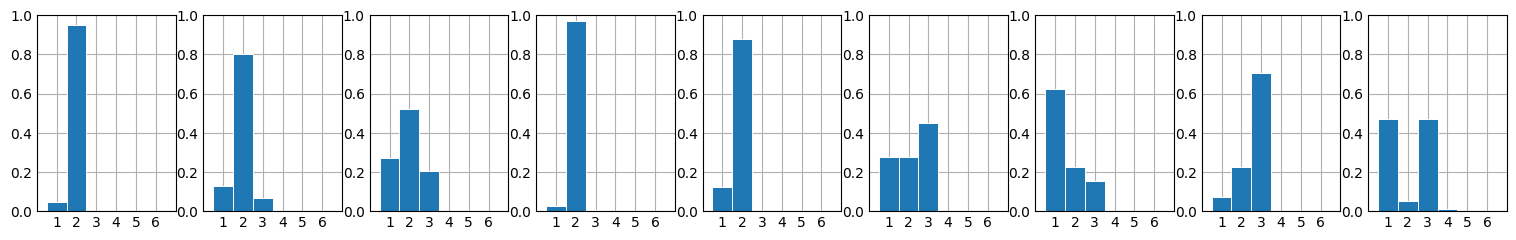

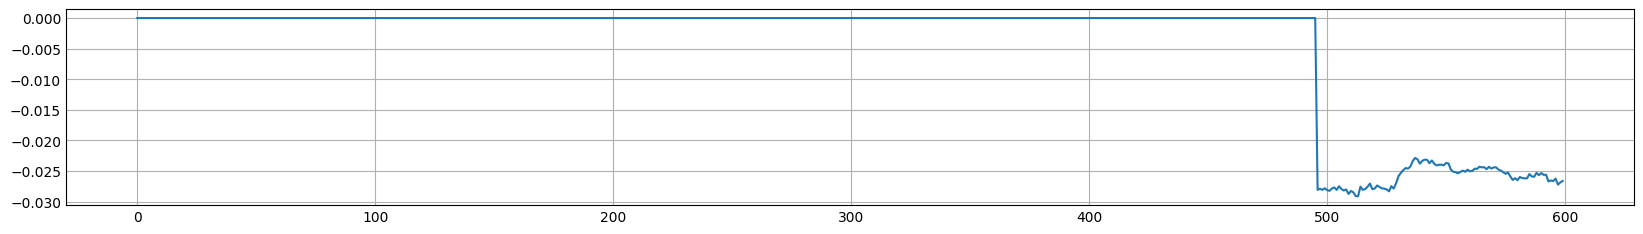

In [19]:
inference_results = []
patient_ids = all_patients()
i = 0
for patient_id, session_id in patient_ids:
    i += 1
    print(patient_id, session_id)
    inference_results.extend(plot_patient(patient_id, session_id))
    #if i >= 2:
    #    break
#print(inference_results)

In [20]:
TODO
length of exercise
overal movement 
overal movement normalized by 

SyntaxError: invalid syntax (1106977774.py, line 2)

__END__